In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# # Define paths
# output_dir_non_winsor = './OoS_metrics_rf/non_winsorized'
# output_dir_winsor = './OoS_metrics_rf/winsorized'


In [ ]:
#### ## pdc off
### testing old technique


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plta
import seaborn as sns
from scipy.stats import mstats


custom_colors = {
    'CatBoost': 'blue',
    'LightGBM': 'green',
    'Random Forest': 'orange',
    'GBM': 'purple',
    'XGBoost': 'pink'
}

# Base path
base_path = 'C:\\Users\\shafiullah.qureshi\\OneDrive - Government of Alberta\\Documents\\nowcast_gdp\\Dynamic Feature Selection for Canadian GDP'

# Model folders
model_folders = [
    (f'{base_path}\\OoS_metrics_Catboost_off', 'CatBoost'),
    (f'{base_path}\\OoS_metrics_LightGBM_off', 'LightGBM'),
    (f'{base_path}\\OoS_metrics_rf_off', 'Random Forest'),
    (f'{base_path}\\OoS_metrics_GBM_off', 'GBM'),
    (f'{base_path}\\OoS_metrics_xgboost_off', 'XGBoost')
]

# Create output folder
output_folder = 'graph_pdc_off'
os.makedirs(output_folder, exist_ok=True)

# Horizons
horizons = ['tau_1', 'tau_3', 'tau_6', 'tau_9']
taus = [1, 3, 6, 9]
horizon_to_tau = {'tau_1': 1, 'tau_3': 3, 'tau_6': 6, 'tau_9': 9}

# List of metrics
metrics = ['rmse', 'mae', 'mad', 'r_sq']

# Mapping for nice labels
metric_labels = {
    'rmse': 'RMSE',
    'mae': 'MAE',
    'mad': 'MAD',
    'r_sq': 'R²'
}

# Rolling window size (as per Ba Chu's code)
ROLLING_WINDOW = 12
ROLLMEAN_WINDOW = 30
# Scale factor
SCALE = 100

# Winsorization functions
def winsorize_data(data, limits=(0.20, 0.20)):
    if len(data) == 0:
        return np.array([])
    return mstats.winsorize(data, limits=limits)

# Define function to calculate the interquartile range (from Ba Chu's code)
def find_iqr(x):
    q75 = np.percentile(x, 75)
    q25 = np.percentile(x, 25)
    return q75 - q25

# Define function to calculate the median (from Ba Chu's code)
def find_med(x):
    return np.percentile(x, 50)

# ============================================================================
# STEP 1: Load data and calculate metrics using ROLLING methodology
# ============================================================================

all_metrics_data = []
all_errors_data = {}
all_rolling_r_sq_data = {}
all_rolling_rmse_data = {}
all_rolling_mae_data = {}
all_rolling_mad_data = {}

# Store results for rolling charts
results = {tau: {'rmse': [], 'mae': [], 'mad': [], 'r_sq': [], 'ssample_end_date': []} for tau in taus}

for folder_path, model_name in model_folders:
    all_errors_data[model_name] = {}
    all_rolling_r_sq_data[model_name] = {}
    all_rolling_rmse_data[model_name] = {}
    all_rolling_mae_data[model_name] = {}
    all_rolling_mad_data[model_name] = {}

    for tau in taus:
        avp_file = f'{folder_path}\\actual_vs_predicted_tau_{tau}.csv'
        window_file = f'{folder_path}\\winsorized\\OoS_metrics_tau_{tau}_winsorized.csv'

        try:
            avp_df = pd.read_csv(avp_file)
            window_df = pd.read_csv(window_file)

            # Get actual and predicted values
            actual = pd.Series(avp_df['actual'].values)
            predicted = pd.Series(avp_df['predicted'].values)

            # Calculate individual errors
            errors = actual - predicted
            abs_errors = np.abs(errors)
            sq_errors = errors ** 2

            # ================================================================
            # ROLLING RMSE (Ba Chu's methodology)
            # ================================================================
            rolling_rmse = SCALE * np.sqrt(sq_errors.rolling(ROLLING_WINDOW).mean())
            rolling_rmse = rolling_rmse.dropna()

            # Apply winsorization
            rolling_rmse_winsorized = winsorize_data(rolling_rmse.values)

            # Get median and IQR
            median_rmse = find_med(rolling_rmse_winsorized)
            iqr_rmse = find_iqr(rolling_rmse_winsorized)

            # Store for plots
            all_rolling_rmse_data[model_name][tau] = rolling_rmse_winsorized

            # ================================================================
            # ROLLING MAE (Ba Chu's methodology)
            # ================================================================
            rolling_mae = SCALE * abs_errors.rolling(ROLLING_WINDOW).mean()
            rolling_mae = rolling_mae.dropna()

            # Apply winsorization
            rolling_mae_winsorized = winsorize_data(rolling_mae.values)

            # Get median and IQR
            median_mae = find_med(rolling_mae_winsorized)
            iqr_mae = find_iqr(rolling_mae_winsorized)

            # Store for plots
            all_rolling_mae_data[model_name][tau] = rolling_mae_winsorized

            # ================================================================
            # ROLLING MAD (median of absolute errors in rolling window)
            # ================================================================
            rolling_mad = SCALE * abs_errors.rolling(ROLLING_WINDOW).median()
            rolling_mad = rolling_mad.dropna()

            # Apply winsorization
            rolling_mad_winsorized = winsorize_data(rolling_mad.values)

            # Get median and IQR
            median_mad = find_med(rolling_mad_winsorized)
            iqr_mad = find_iqr(rolling_mad_winsorized)

            # Store for plots
            all_rolling_mad_data[model_name][tau] = rolling_mad_winsorized

            # ================================================================
            # ROLLING R² (Ba Chu's methodology) — Rolling-Mean benchmark (window=30)
            # ================================================================
            # Benchmark forecast = rolling mean of past GDP prior to each date (proxy using available 'actual' series)
            # Note: With only OoS 'actual' available, this is the closest in-file proxy to Ba Chu's gdp_df-based roll_mean.
            bench_pred = actual.shift(1).rolling(ROLLMEAN_WINDOW, min_periods=ROLLMEAN_WINDOW).mean()

            # Rolling RMSE for benchmark over the same RMSE rolling window (12)
            sq_errors_benchmark = (actual - bench_pred) ** 2
            rolling_rmse_benchmark = SCALE * np.sqrt(sq_errors_benchmark.rolling(ROLLING_WINDOW).mean())
            rolling_rmse_benchmark = rolling_rmse_benchmark.dropna()

            # Align lengths
            min_len = min(len(rolling_rmse), len(rolling_rmse_benchmark))
            rolling_rmse_aligned = rolling_rmse.iloc[-min_len:].values
            rolling_rmse_benchmark_aligned = rolling_rmse_benchmark.iloc[-min_len:].values

            # Calculate R² = 1 - (RMSE_model / RMSE_benchmark)²
            # (guard against division by zero)
            den = np.where(rolling_rmse_benchmark_aligned == 0, np.nan, rolling_rmse_benchmark_aligned)
            rolling_r_sq = 1 - np.power(rolling_rmse_aligned / den, 2)
            rolling_r_sq = rolling_r_sq[~np.isnan(rolling_r_sq)]

            # Apply winsorization
            rolling_r_sq_winsorized = winsorize_data(rolling_r_sq)

            # Get median and IQR
            median_r_sq = find_med(rolling_r_sq_winsorized)
            iqr_r_sq = find_iqr(rolling_r_sq_winsorized)

            # Store rolling R² for plots
            all_rolling_r_sq_data[model_name][tau] = rolling_r_sq_winsorized


            # ================================================================
            # Store metrics
            # ================================================================
            all_metrics_data.append({
                'Model': model_name,
                'Horizon': f'tau_{tau}',
                'tau': tau,
                'rmse': median_rmse,
                'mae': median_mae,
                'mad': median_mad,
                'r_sq': median_r_sq,
                'iqr_rmse': iqr_rmse,
                'iqr_mae': iqr_mae,
                'iqr_mad': iqr_mad,
                'iqr_r_sq': iqr_r_sq
            })

            # Store for boxplots
            all_errors_data[model_name][tau] = abs_errors.values

            # Store for rolling charts (only for first model)
            if model_name == 'CatBoost':
                results[tau]['rmse'] = rolling_rmse.tolist()
                results[tau]['mae'] = rolling_mae.tolist()
                results[tau]['mad'] = rolling_mad.tolist()
                results[tau]['r_sq'] = rolling_r_sq_winsorized.tolist()
                results[tau]['ssample_end_date'] = window_df['ssample_end_date'].tolist()

            print(f"Loaded: {model_name} tau={tau}, rolling points: {len(rolling_rmse)}")

        except FileNotFoundError as e:
            print(f"NOT FOUND: {e}")

# Create DataFrame
metrics_df = pd.DataFrame(all_metrics_data)

# ============================================================================
# STEP 2: Create combined_metrics_summary.csv
# ============================================================================

combined_summary_df = pd.DataFrame()

for horizon in horizons:
    tau = horizon_to_tau[horizon]
    for metric in metrics:
        iqr_col = f'iqr_{metric}'

        for folder_path, model_name in model_folders:
            model_data = metrics_df[(metrics_df['Model'] == model_name) & (metrics_df['tau'] == tau)]

            if len(model_data) > 0:
                value = model_data[metric].values[0]
                iqr = model_data[iqr_col].values[0]

                combined_summary_df = pd.concat([combined_summary_df, pd.DataFrame([{
                    'Horizon': horizon,
                    'Metric': metric,
                    'Model': model_name,
                    'Median': value,
                    'IQR': iqr
                }])], ignore_index=True)

combined_summary_df.to_csv(f'{output_folder}/combined_metrics_summary.csv', index=False)
print(f"\nSaved: {output_folder}/combined_metrics_summary.csv")

# ============================================================================
# STEP 3: Create sorted_metrics_summary.csv
# ============================================================================

sorted_df = combined_summary_df.sort_values(by=['Horizon', 'Metric', 'Model'])
sorted_df.to_csv(f'{output_folder}/sorted_metrics_summary.csv', index=False)
print(f"Saved: {output_folder}/sorted_metrics_summary.csv")

# ============================================================================
# STEP 4: Create final_formatted_output.xlsx (Excel only)
# ============================================================================

# Order: RMSE, MAD, MAE, R^2 for each horizon
metric_order = ['rmse', 'mad', 'mae', 'r_sq']
metric_labels_excel = {
    'rmse': 'RMSE',
    'mad': 'MAD',
    'mae': 'MAE',
    'r_sq': 'R^2'
}

# Model order as in Excel
model_order = ['GBM', 'XGBoost', 'CatBoost', 'Random Forest', 'LightGBM']

final_rows = []
for model_name in model_order:
    row = {'Model': model_name}
    for tau in taus:
        model_data = metrics_df[(metrics_df['Model'] == model_name) & (metrics_df['tau'] == tau)]
        if len(model_data) > 0:
            for metric in metric_order:
                iqr_col = f'iqr_{metric}'
                value = model_data[metric].values[0]
                iqr = model_data[iqr_col].values[0]
                col_name = f'{metric_labels_excel[metric]} (h={tau})'
                row[col_name] = f'{value:.4f}\n({iqr:.4f})'
    final_rows.append(row)

final_df = pd.DataFrame(final_rows)

# Reorder columns: Model, then RMSE/MAD/MAE/R^2 for each horizon
col_order = ['Model']
for tau in taus:
    for metric in metric_order:
        col_order.append(f'{metric_labels_excel[metric]} (h={tau})')

final_df = final_df[col_order]
final_df.to_csv(f'{output_folder}/final_formatted_output.csv', index=False)
print(f"Saved: {output_folder}/final_formatted_output.csv")

# ============================================================================
# STEP 5: Rolling line charts (ORIGINAL FORMAT)
# ============================================================================

# Rolling RMSE
plt.figure(figsize=(14, 8))
for tau, result in results.items():
    if result['rmse']:
        rmse_data = winsorize_data(np.array(result['rmse']))
        dates = pd.to_datetime(result['ssample_end_date'])
        # Align lengths
        min_len = min(len(rmse_data), len(dates))
        rmse_series = pd.Series(rmse_data[:min_len], index=dates[:min_len])
        rmse_series.plot(label=f'Step-{tau}')
    else:
        print(f"No RMSE data to plot for tau={tau}")

plt.title('Rolling RMSE (scaled by 10) with Winsorization out-of-sample for different forecast horizons')
plt.xlabel('End Date of Subsample')
plt.ylabel('RMSE (scaled by 10)')
plt.legend()
plt.grid(True)
plt.savefig(f'{output_folder}/rolling_rmse.png', bbox_inches='tight')
plt.show()

# Rolling MAE
plt.figure(figsize=(14, 8))
for tau, result in results.items():
    if result['mae']:
        mae_data = winsorize_data(np.array(result['mae']))
        dates = pd.to_datetime(result['ssample_end_date'])
        min_len = min(len(mae_data), len(dates))
        mae_series = pd.Series(mae_data[:min_len], index=dates[:min_len])
        mae_series.plot(label=f'Step-{tau}')
    else:
        print(f"No MAE data to plot for tau={tau}")

plt.title('Rolling MAE (scaled by 10) with Winsorization out-of-sample for different forecast horizons')
plt.xlabel('End Date of Subsample')
plt.ylabel('MAE (scaled by 10)')
plt.legend()
plt.grid(True)
plt.savefig(f'{output_folder}/rolling_mae.png', bbox_inches='tight')
plt.show()

# Rolling MAD
plt.figure(figsize=(14, 8))
for tau, result in results.items():
    if result['mad']:
        mad_data = winsorize_data(np.array(result['mad']))
        dates = pd.to_datetime(result['ssample_end_date'])
        min_len = min(len(mad_data), len(dates))
        mad_series = pd.Series(mad_data[:min_len], index=dates[:min_len])
        mad_series.plot(label=f'Step-{tau}')
    else:
        print(f"No MAD data to plot for tau={tau}")

plt.title('Rolling MAD (scaled by 10) with Winsorization out-of-sample for different forecast horizons')
plt.xlabel('End Date of Subsample')
plt.ylabel('MAD (scaled by 10)')
plt.legend()
plt.grid(True)
plt.savefig(f'{output_folder}/rolling_mad.png', bbox_inches='tight')
plt.show()

# Rolling R²
plt.figure(figsize=(14, 8))
for tau in taus:
    if 'CatBoost' in all_rolling_r_sq_data and tau in all_rolling_r_sq_data['CatBoost']:
        r_sq_data = all_rolling_r_sq_data['CatBoost'][tau]
        if len(r_sq_data) > 0:
            dates = pd.to_datetime(results[tau]['ssample_end_date'])
            min_len = min(len(r_sq_data), len(dates))
            r_sq_series = pd.Series(r_sq_data[:min_len], index=dates[:min_len])
            r_sq_series.plot(label=f'Step-{tau}')

plt.title('Rolling R² with Winsorization out-of-sample for different forecast horizons')
plt.xlabel('End Date of Subsample')
plt.ylabel('R²')
plt.legend()
plt.grid(True)
plt.savefig(f'{output_folder}/rolling_r_sq.png', bbox_inches='tight')
plt.show()

# ============================================================================
# STEP 6: Box plots - BY MODEL for each horizon
# ============================================================================

# Box plots for RMSE - comparing models at each horizon
for tau in taus:
    plt.figure(figsize=(14, 8))
    data_to_plot = []
    model_labels_list = []

    for folder_path, model_name in model_folders:
        if model_name in all_rolling_rmse_data and tau in all_rolling_rmse_data[model_name]:
            data = all_rolling_rmse_data[model_name][tau]
            data_to_plot.append(data)
            model_labels_list.append(model_name)

    if data_to_plot:
        box = plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=model_labels_list)
        for patch, model_name in zip(box['boxes'], model_labels_list):
            patch.set_facecolor(custom_colors.get(model_name, 'grey'))

        plt.xlabel('Model', fontsize=14)
        plt.ylabel('RMSE', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.savefig(f'{output_folder}/rmse_tau_{tau}.png', bbox_inches='tight')
        plt.close()
        print(f"Saved: rmse_tau_{tau}.png")

# Box plots for MAE - comparing models at each horizon
for tau in taus:
    plt.figure(figsize=(14, 8))
    data_to_plot = []
    model_labels_list = []

    for folder_path, model_name in model_folders:
        if model_name in all_rolling_mae_data and tau in all_rolling_mae_data[model_name]:
            data = all_rolling_mae_data[model_name][tau]
            data_to_plot.append(data)
            model_labels_list.append(model_name)

    if data_to_plot:
        box = plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=model_labels_list)
        for patch, model_name in zip(box['boxes'], model_labels_list):
            patch.set_facecolor(custom_colors.get(model_name, 'grey'))

        plt.xlabel('Model', fontsize=14)
        plt.ylabel('MAE', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.savefig(f'{output_folder}/mae_tau_{tau}.png', bbox_inches='tight')
        plt.close()
        print(f"Saved: mae_tau_{tau}.png")

# Box plots for MAD - comparing models at each horizon
for tau in taus:
    plt.figure(figsize=(14, 8))
    data_to_plot = []
    model_labels_list = []

    for folder_path, model_name in model_folders:
        if model_name in all_rolling_mad_data and tau in all_rolling_mad_data[model_name]:
            data = all_rolling_mad_data[model_name][tau]
            data_to_plot.append(data)
            model_labels_list.append(model_name)

    if data_to_plot:
        box = plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=model_labels_list)
        for patch, model_name in zip(box['boxes'], model_labels_list):
            patch.set_facecolor(custom_colors.get(model_name, 'grey'))

        plt.xlabel('Model', fontsize=14)
        plt.ylabel('MAD', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.savefig(f'{output_folder}/mad_tau_{tau}.png', bbox_inches='tight')
        plt.close()
        print(f"Saved: mad_tau_{tau}.png")

# Box plot for R² - comparing models at each horizon
for tau in taus:
    plt.figure(figsize=(14, 8))
    data_to_plot = []
    model_labels_list = []

    for folder_path, model_name in model_folders:
        if model_name in all_rolling_r_sq_data and tau in all_rolling_r_sq_data[model_name]:
            data = all_rolling_r_sq_data[model_name][tau]
            if len(data) > 0:
                data_to_plot.append(data)
                model_labels_list.append(model_name)

    if data_to_plot:
        box = plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=model_labels_list)
        for patch, model_name in zip(box['boxes'], model_labels_list):
            patch.set_facecolor(custom_colors.get(model_name, 'grey'))

        plt.xlabel('Model', fontsize=14)
        plt.ylabel('R²', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.savefig(f'{output_folder}/r_sq_tau_{tau}.png', bbox_inches='tight')
        plt.close()
        print(f"Saved: r_sq_tau_{tau}.png")

# ============================================================================
# STEP 7: Print Summary WITH IQR
# ============================================================================

print("\n" + "="*130)
print("FINAL SUMMARY - Rolling RMSE/MAE/MAD (scaled by 10) + Rolling OoS R² (Ba Chu's methodology)")
print(f"Rolling window size: {ROLLING_WINDOW}")
print("="*130)

for tau in taus:
    print(f"\n--- Horizon h={tau} ---")
    print(f"{'Model':<15} {'RMSE×10':<14} {'(IQR)':<14} {'MAE×10':<14} {'(IQR)':<14} {'MAD×10':<14} {'(IQR)':<14} {'R²':<14} {'(IQR)':<14}")
    print("-"*130)

    subset = metrics_df[metrics_df['tau'] == tau]
    for _, row in subset.iterrows():
        print(f"{row['Model']:<15} {row['rmse']:<14.4f} {row['iqr_rmse']:<14.4f} {row['mae']:<14.4f} {row['iqr_mae']:<14.4f} {row['mad']:<14.4f} {row['iqr_mad']:<14.4f} {row['r_sq']:<14.4f} {row['iqr_r_sq']:<14.4f}")

print("\n" + "="*130)
print("Note: RMSE, MAE, MAD are scaled by 10 for easier comparison")
print("      All metrics use ROLLING window methodology (Ba Chu's approach)")
print("      Reported values are MEDIAN of rolling series")
print("      IQR computed from rolling series")
print("="*130)
print("Files saved to:", output_folder)
print("="*130)

NOT FOUND: [Errno 2] No such file or directory: 'C:\\Users\\shafiullah.qureshi\\OneDrive - Government of Alberta\\Documents\\nowcast_gdp\\Dynamic Feature Selection for Canadian GDP\\OoS_metrics_Catboost_off\\winsorized\\OoS_metrics_tau_1_winsorized.csv'
NOT FOUND: [Errno 2] No such file or directory: 'C:\\Users\\shafiullah.qureshi\\OneDrive - Government of Alberta\\Documents\\nowcast_gdp\\Dynamic Feature Selection for Canadian GDP\\OoS_metrics_Catboost_off\\winsorized\\OoS_metrics_tau_3_winsorized.csv'
NOT FOUND: [Errno 2] No such file or directory: 'C:\\Users\\shafiullah.qureshi\\OneDrive - Government of Alberta\\Documents\\nowcast_gdp\\Dynamic Feature Selection for Canadian GDP\\OoS_metrics_Catboost_off\\winsorized\\OoS_metrics_tau_6_winsorized.csv'
NOT FOUND: [Errno 2] No such file or directory: 'C:\\Users\\shafiullah.qureshi\\OneDrive - Government of Alberta\\Documents\\nowcast_gdp\\Dynamic Feature Selection for Canadian GDP\\OoS_metrics_Catboost_off\\winsorized\\OoS_metrics_tau_9_

KeyError: 'Model'

Loaded: CatBoost tau=1, rolling points: 98
Loaded: CatBoost tau=3, rolling points: 316
Loaded: CatBoost tau=6, rolling points: 643
Loaded: CatBoost tau=9, rolling points: 970
Loaded: LightGBM tau=1, rolling points: 98
Loaded: LightGBM tau=3, rolling points: 316
Loaded: LightGBM tau=6, rolling points: 643
Loaded: LightGBM tau=9, rolling points: 970
Loaded: Random Forest tau=1, rolling points: 98
Loaded: Random Forest tau=3, rolling points: 316
Loaded: Random Forest tau=6, rolling points: 643
Loaded: Random Forest tau=9, rolling points: 970
Loaded: GBM tau=1, rolling points: 98
Loaded: GBM tau=3, rolling points: 316
Loaded: GBM tau=6, rolling points: 643
Loaded: GBM tau=9, rolling points: 970
Loaded: XGBoost tau=1, rolling points: 98
Loaded: XGBoost tau=3, rolling points: 316
Loaded: XGBoost tau=6, rolling points: 643
Loaded: XGBoost tau=9, rolling points: 970

Saved: graph_pdc_gt/combined_metrics_summary.csv
Saved: graph_pdc_gt/sorted_metrics_summary.csv
Saved: graph_pdc_gt/final_format

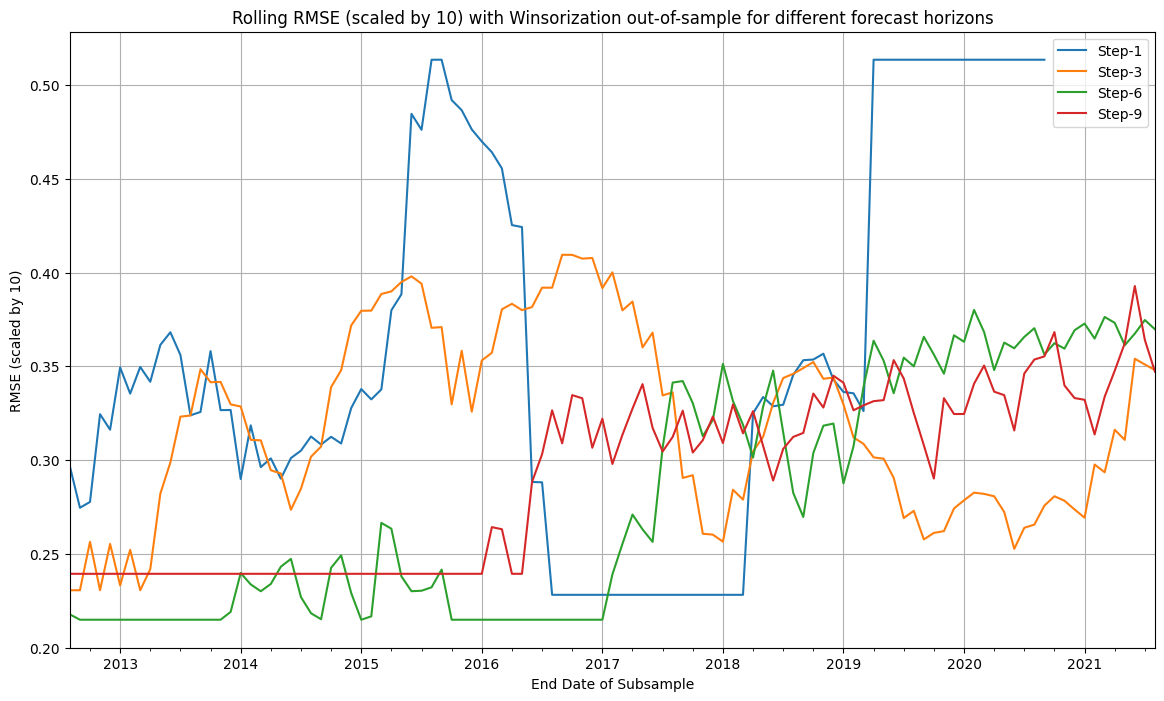

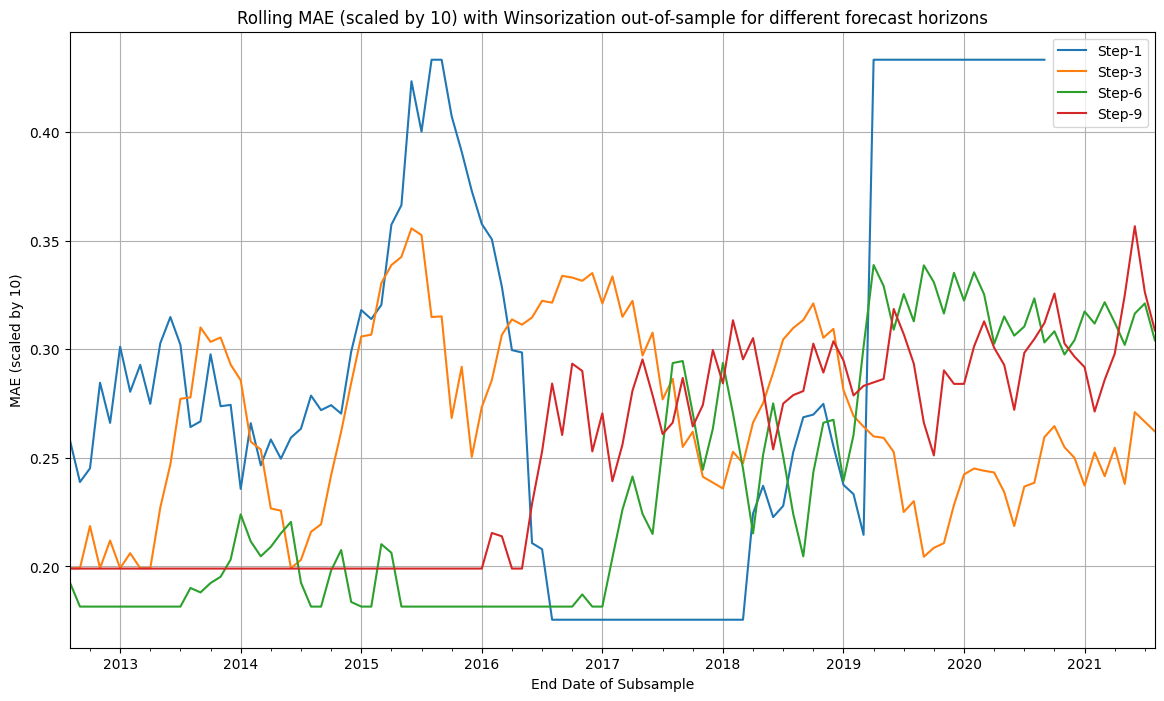

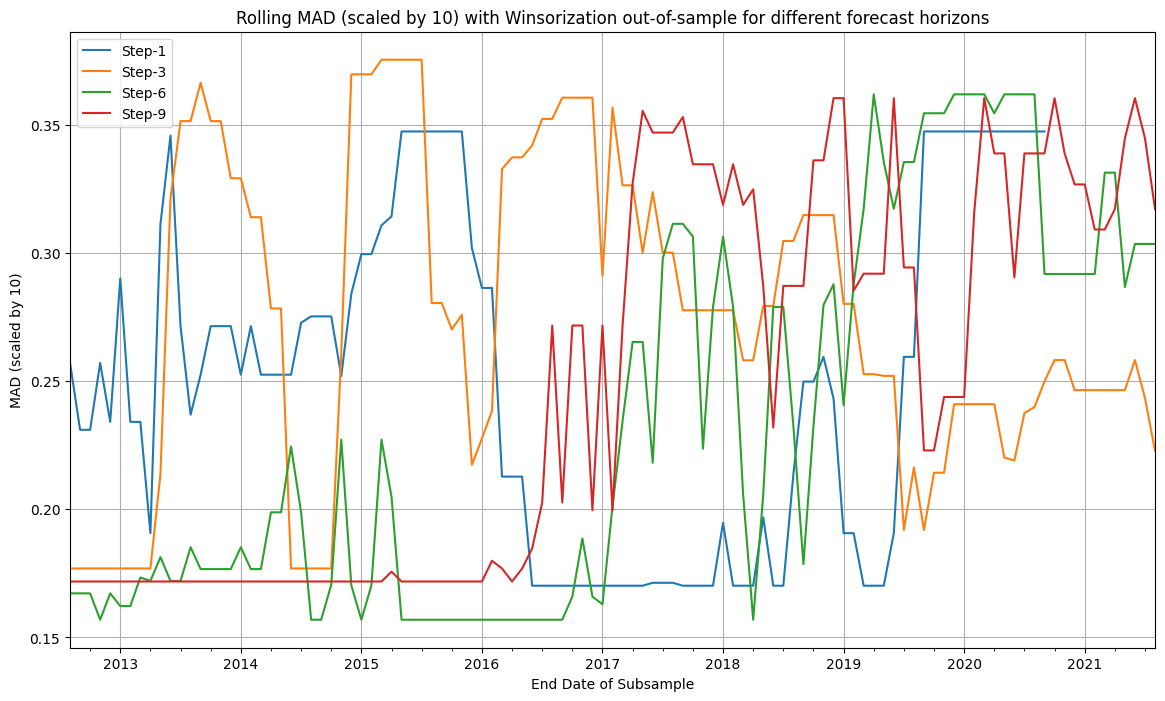

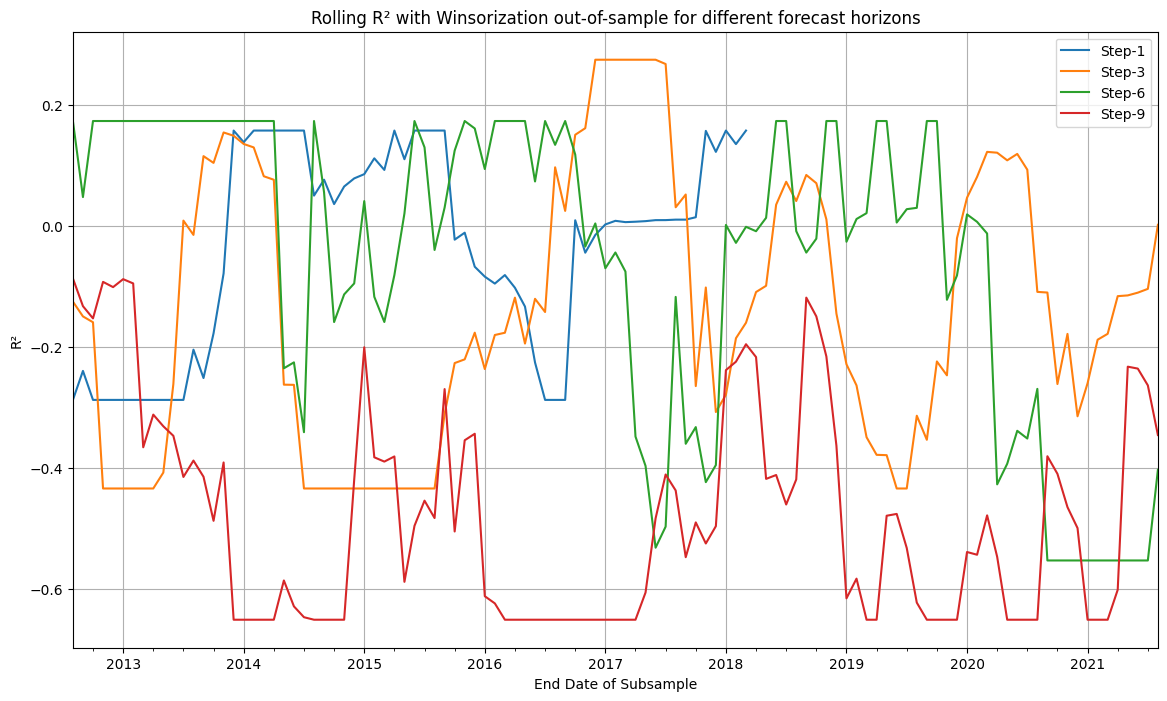

Saved: rmse_tau_1.png
Saved: rmse_tau_3.png
Saved: rmse_tau_6.png
Saved: rmse_tau_9.png
Saved: mae_tau_1.png
Saved: mae_tau_3.png
Saved: mae_tau_6.png
Saved: mae_tau_9.png
Saved: mad_tau_1.png
Saved: mad_tau_3.png
Saved: mad_tau_6.png
Saved: mad_tau_9.png
Saved: r_sq_tau_1.png
Saved: r_sq_tau_3.png
Saved: r_sq_tau_6.png
Saved: r_sq_tau_9.png

FINAL SUMMARY - Rolling RMSE/MAE/MAD (scaled by 10) + Rolling OoS R² (Ba Chu's methodology)
Rolling window size: 12

--- Horizon h=1 ---
Model           RMSE×10        (IQR)          MAE×10         (IQR)          MAD×10         (IQR)          R²             (IQR)         
----------------------------------------------------------------------------------------------------------------------------------
CatBoost        0.3346         0.1846         0.2741         0.1461         0.2526         0.1302         0.0080         0.3353        
LightGBM        0.3523         0.1805         0.2849         0.1173         0.2590         0.1155         -0.1609  

In [ ]:
### pdc gt

#### ## pdc off
### testing old technique


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plta
import seaborn as sns
from scipy.stats import mstats


custom_colors = {
    'CatBoost': 'blue',
    'LightGBM': 'green',
    'Random Forest': 'orange',
    'GBM': 'purple',
    'XGBoost': 'pink'
}

# Base path
base_path = 'C:\\Users\\shafiullah.qureshi\\OneDrive - Government of Alberta\\Documents\\nowcast_gdp\\Dynamic Feature Selection for Canadian GDP'

# Model folders
model_folders = [
    (f'{base_path}\\OoS_metrics_Catboost_gt', 'CatBoost'),
    (f'{base_path}\\OoS_metrics_LightGBM_gt', 'LightGBM'),
    (f'{base_path}\\OoS_metrics_rf_gt', 'Random Forest'),
    (f'{base_path}\\OoS_metrics_GBM_gt', 'GBM'),
    (f'{base_path}\\OoS_metrics_xgboost_gt', 'XGBoost')
]

# Create output folder
output_folder = 'graph_pdc_gt'
os.makedirs(output_folder, exist_ok=True)

# Horizons
horizons = ['tau_1', 'tau_3', 'tau_6', 'tau_9']
taus = [1, 3, 6, 9]
horizon_to_tau = {'tau_1': 1, 'tau_3': 3, 'tau_6': 6, 'tau_9': 9}

# List of metrics
metrics = ['rmse', 'mae', 'mad', 'r_sq']

# Mapping for nice labels
metric_labels = {
    'rmse': 'RMSE',
    'mae': 'MAE',
    'mad': 'MAD',
    'r_sq': 'R²'
}

# Rolling window size (as per Ba Chu's code)
ROLLING_WINDOW = 12
ROLLMEAN_WINDOW = 30
# Scale factor
SCALE = 100

# Winsorization functions
def winsorize_data(data, limits=(0.20, 0.20)):
    if len(data) == 0:
        return np.array([])
    return mstats.winsorize(data, limits=limits)

# Define function to calculate the interquartile range (from Ba Chu's code)
def find_iqr(x):
    q75 = np.percentile(x, 75)
    q25 = np.percentile(x, 25)
    return q75 - q25

# Define function to calculate the median (from Ba Chu's code)
def find_med(x):
    return np.percentile(x, 50)

# ============================================================================
# STEP 1: Load data and calculate metrics using ROLLING methodology
# ============================================================================

all_metrics_data = []
all_errors_data = {}
all_rolling_r_sq_data = {}
all_rolling_rmse_data = {}
all_rolling_mae_data = {}
all_rolling_mad_data = {}

# Store results for rolling charts
results = {tau: {'rmse': [], 'mae': [], 'mad': [], 'r_sq': [], 'ssample_end_date': []} for tau in taus}

for folder_path, model_name in model_folders:
    all_errors_data[model_name] = {}
    all_rolling_r_sq_data[model_name] = {}
    all_rolling_rmse_data[model_name] = {}
    all_rolling_mae_data[model_name] = {}
    all_rolling_mad_data[model_name] = {}

    for tau in taus:
        avp_file = f'{folder_path}\\actual_vs_predicted_tau_{tau}.csv'
        window_file = f'{folder_path}\\winsorized\\OoS_metrics_tau_{tau}_winsorized.csv'

        try:
            avp_df = pd.read_csv(avp_file)
            window_df = pd.read_csv(window_file)

            # Get actual and predicted values
            actual = pd.Series(avp_df['actual'].values)
            predicted = pd.Series(avp_df['predicted'].values)

            # Calculate individual errors
            errors = actual - predicted
            abs_errors = np.abs(errors)
            sq_errors = errors ** 2

            # ================================================================
            # ROLLING RMSE (Ba Chu's methodology)
            # ================================================================
            rolling_rmse = SCALE * np.sqrt(sq_errors.rolling(ROLLING_WINDOW).mean())
            rolling_rmse = rolling_rmse.dropna()

            # Apply winsorization
            rolling_rmse_winsorized = winsorize_data(rolling_rmse.values)

            # Get median and IQR
            median_rmse = find_med(rolling_rmse_winsorized)
            iqr_rmse = find_iqr(rolling_rmse_winsorized)

            # Store for plots
            all_rolling_rmse_data[model_name][tau] = rolling_rmse_winsorized

            # ================================================================
            # ROLLING MAE (Ba Chu's methodology)
            # ================================================================
            rolling_mae = SCALE * abs_errors.rolling(ROLLING_WINDOW).mean()
            rolling_mae = rolling_mae.dropna()

            # Apply winsorization
            rolling_mae_winsorized = winsorize_data(rolling_mae.values)

            # Get median and IQR
            median_mae = find_med(rolling_mae_winsorized)
            iqr_mae = find_iqr(rolling_mae_winsorized)

            # Store for plots
            all_rolling_mae_data[model_name][tau] = rolling_mae_winsorized

            # ================================================================
            # ROLLING MAD (median of absolute errors in rolling window)
            # ================================================================
            rolling_mad = SCALE * abs_errors.rolling(ROLLING_WINDOW).median()
            rolling_mad = rolling_mad.dropna()

            # Apply winsorization
            rolling_mad_winsorized = winsorize_data(rolling_mad.values)

            # Get median and IQR
            median_mad = find_med(rolling_mad_winsorized)
            iqr_mad = find_iqr(rolling_mad_winsorized)

            # Store for plots
            all_rolling_mad_data[model_name][tau] = rolling_mad_winsorized

            # ================================================================
            # ROLLING R² (Ba Chu's methodology) — Rolling-Mean benchmark (window=30)
            # ================================================================
            # Benchmark forecast = rolling mean of past GDP prior to each date (proxy using available 'actual' series)
            # Note: With only OoS 'actual' available, this is the closest in-file proxy to Ba Chu's gdp_df-based roll_mean.
            bench_pred = actual.shift(1).rolling(ROLLMEAN_WINDOW, min_periods=ROLLMEAN_WINDOW).mean()

            # Rolling RMSE for benchmark over the same RMSE rolling window (12)
            sq_errors_benchmark = (actual - bench_pred) ** 2
            rolling_rmse_benchmark = SCALE * np.sqrt(sq_errors_benchmark.rolling(ROLLING_WINDOW).mean())
            rolling_rmse_benchmark = rolling_rmse_benchmark.dropna()

            # Align lengths
            min_len = min(len(rolling_rmse), len(rolling_rmse_benchmark))
            rolling_rmse_aligned = rolling_rmse.iloc[-min_len:].values
            rolling_rmse_benchmark_aligned = rolling_rmse_benchmark.iloc[-min_len:].values

            # Calculate R² = 1 - (RMSE_model / RMSE_benchmark)²
            # (guard against division by zero)
            den = np.where(rolling_rmse_benchmark_aligned == 0, np.nan, rolling_rmse_benchmark_aligned)
            rolling_r_sq = 1 - np.power(rolling_rmse_aligned / den, 2)
            rolling_r_sq = rolling_r_sq[~np.isnan(rolling_r_sq)]

            # Apply winsorization
            rolling_r_sq_winsorized = winsorize_data(rolling_r_sq)

            # Get median and IQR
            median_r_sq = find_med(rolling_r_sq_winsorized)
            iqr_r_sq = find_iqr(rolling_r_sq_winsorized)

            # Store rolling R² for plots
            all_rolling_r_sq_data[model_name][tau] = rolling_r_sq_winsorized


            # ================================================================
            # Store metrics
            # ================================================================
            all_metrics_data.append({
                'Model': model_name,
                'Horizon': f'tau_{tau}',
                'tau': tau,
                'rmse': median_rmse,
                'mae': median_mae,
                'mad': median_mad,
                'r_sq': median_r_sq,
                'iqr_rmse': iqr_rmse,
                'iqr_mae': iqr_mae,
                'iqr_mad': iqr_mad,
                'iqr_r_sq': iqr_r_sq
            })

            # Store for boxplots
            all_errors_data[model_name][tau] = abs_errors.values

            # Store for rolling charts (only for first model)
            if model_name == 'CatBoost':
                results[tau]['rmse'] = rolling_rmse.tolist()
                results[tau]['mae'] = rolling_mae.tolist()
                results[tau]['mad'] = rolling_mad.tolist()
                results[tau]['r_sq'] = rolling_r_sq_winsorized.tolist()
                results[tau]['ssample_end_date'] = window_df['ssample_end_date'].tolist()

            print(f"Loaded: {model_name} tau={tau}, rolling points: {len(rolling_rmse)}")

        except FileNotFoundError as e:
            print(f"NOT FOUND: {e}")

# Create DataFrame
metrics_df = pd.DataFrame(all_metrics_data)

# ============================================================================
# STEP 2: Create combined_metrics_summary.csv
# ============================================================================

combined_summary_df = pd.DataFrame()

for horizon in horizons:
    tau = horizon_to_tau[horizon]
    for metric in metrics:
        iqr_col = f'iqr_{metric}'

        for folder_path, model_name in model_folders:
            model_data = metrics_df[(metrics_df['Model'] == model_name) & (metrics_df['tau'] == tau)]

            if len(model_data) > 0:
                value = model_data[metric].values[0]
                iqr = model_data[iqr_col].values[0]

                combined_summary_df = pd.concat([combined_summary_df, pd.DataFrame([{
                    'Horizon': horizon,
                    'Metric': metric,
                    'Model': model_name,
                    'Median': value,
                    'IQR': iqr
                }])], ignore_index=True)

combined_summary_df.to_csv(f'{output_folder}/combined_metrics_summary.csv', index=False)
print(f"\nSaved: {output_folder}/combined_metrics_summary.csv")

# ============================================================================
# STEP 3: Create sorted_metrics_summary.csv
# ============================================================================

sorted_df = combined_summary_df.sort_values(by=['Horizon', 'Metric', 'Model'])
sorted_df.to_csv(f'{output_folder}/sorted_metrics_summary.csv', index=False)
print(f"Saved: {output_folder}/sorted_metrics_summary.csv")

# ============================================================================
# STEP 4: Create final_formatted_output.xlsx (Excel only)
# ============================================================================

# Order: RMSE, MAD, MAE, R^2 for each horizon
metric_order = ['rmse', 'mad', 'mae', 'r_sq']
metric_labels_excel = {
    'rmse': 'RMSE',
    'mad': 'MAD',
    'mae': 'MAE',
    'r_sq': 'R^2'
}

# Model order as in Excel
model_order = ['GBM', 'XGBoost', 'CatBoost', 'Random Forest', 'LightGBM']

final_rows = []
for model_name in model_order:
    row = {'Model': model_name}
    for tau in taus:
        model_data = metrics_df[(metrics_df['Model'] == model_name) & (metrics_df['tau'] == tau)]
        if len(model_data) > 0:
            for metric in metric_order:
                iqr_col = f'iqr_{metric}'
                value = model_data[metric].values[0]
                iqr = model_data[iqr_col].values[0]
                col_name = f'{metric_labels_excel[metric]} (h={tau})'
                row[col_name] = f'{value:.4f}\n({iqr:.4f})'
    final_rows.append(row)

final_df = pd.DataFrame(final_rows)

# Reorder columns: Model, then RMSE/MAD/MAE/R^2 for each horizon
col_order = ['Model']
for tau in taus:
    for metric in metric_order:
        col_order.append(f'{metric_labels_excel[metric]} (h={tau})')

final_df = final_df[col_order]
final_df.to_csv(f'{output_folder}/final_formatted_output.csv', index=False)
print(f"Saved: {output_folder}/final_formatted_output.csv")

# ============================================================================
# STEP 5: Rolling line charts (ORIGINAL FORMAT)
# ============================================================================

# Rolling RMSE
plt.figure(figsize=(14, 8))
for tau, result in results.items():
    if result['rmse']:
        rmse_data = winsorize_data(np.array(result['rmse']))
        dates = pd.to_datetime(result['ssample_end_date'])
        # Align lengths
        min_len = min(len(rmse_data), len(dates))
        rmse_series = pd.Series(rmse_data[:min_len], index=dates[:min_len])
        rmse_series.plot(label=f'Step-{tau}')
    else:
        print(f"No RMSE data to plot for tau={tau}")

plt.title('Rolling RMSE (scaled by 10) with Winsorization out-of-sample for different forecast horizons')
plt.xlabel('End Date of Subsample')
plt.ylabel('RMSE (scaled by 10)')
plt.legend()
plt.grid(True)
plt.savefig(f'{output_folder}/rolling_rmse.png', bbox_inches='tight')
plt.show()

# Rolling MAE
plt.figure(figsize=(14, 8))
for tau, result in results.items():
    if result['mae']:
        mae_data = winsorize_data(np.array(result['mae']))
        dates = pd.to_datetime(result['ssample_end_date'])
        min_len = min(len(mae_data), len(dates))
        mae_series = pd.Series(mae_data[:min_len], index=dates[:min_len])
        mae_series.plot(label=f'Step-{tau}')
    else:
        print(f"No MAE data to plot for tau={tau}")

plt.title('Rolling MAE (scaled by 10) with Winsorization out-of-sample for different forecast horizons')
plt.xlabel('End Date of Subsample')
plt.ylabel('MAE (scaled by 10)')
plt.legend()
plt.grid(True)
plt.savefig(f'{output_folder}/rolling_mae.png', bbox_inches='tight')
plt.show()

# Rolling MAD
plt.figure(figsize=(14, 8))
for tau, result in results.items():
    if result['mad']:
        mad_data = winsorize_data(np.array(result['mad']))
        dates = pd.to_datetime(result['ssample_end_date'])
        min_len = min(len(mad_data), len(dates))
        mad_series = pd.Series(mad_data[:min_len], index=dates[:min_len])
        mad_series.plot(label=f'Step-{tau}')
    else:
        print(f"No MAD data to plot for tau={tau}")

plt.title('Rolling MAD (scaled by 10) with Winsorization out-of-sample for different forecast horizons')
plt.xlabel('End Date of Subsample')
plt.ylabel('MAD (scaled by 10)')
plt.legend()
plt.grid(True)
plt.savefig(f'{output_folder}/rolling_mad.png', bbox_inches='tight')
plt.show()

# Rolling R²
plt.figure(figsize=(14, 8))
for tau in taus:
    if 'CatBoost' in all_rolling_r_sq_data and tau in all_rolling_r_sq_data['CatBoost']:
        r_sq_data = all_rolling_r_sq_data['CatBoost'][tau]
        if len(r_sq_data) > 0:
            dates = pd.to_datetime(results[tau]['ssample_end_date'])
            min_len = min(len(r_sq_data), len(dates))
            r_sq_series = pd.Series(r_sq_data[:min_len], index=dates[:min_len])
            r_sq_series.plot(label=f'Step-{tau}')

plt.title('Rolling R² with Winsorization out-of-sample for different forecast horizons')
plt.xlabel('End Date of Subsample')
plt.ylabel('R²')
plt.legend()
plt.grid(True)
plt.savefig(f'{output_folder}/rolling_r_sq.png', bbox_inches='tight')
plt.show()

# ============================================================================
# STEP 6: Box plots - BY MODEL for each horizon
# ============================================================================

# Box plots for RMSE - comparing models at each horizon
for tau in taus:
    plt.figure(figsize=(14, 8))
    data_to_plot = []
    model_labels_list = []

    for folder_path, model_name in model_folders:
        if model_name in all_rolling_rmse_data and tau in all_rolling_rmse_data[model_name]:
            data = all_rolling_rmse_data[model_name][tau]
            data_to_plot.append(data)
            model_labels_list.append(model_name)

    if data_to_plot:
        box = plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=model_labels_list)
        for patch, model_name in zip(box['boxes'], model_labels_list):
            patch.set_facecolor(custom_colors.get(model_name, 'grey'))

        plt.xlabel('Model', fontsize=14)
        plt.ylabel('RMSE', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.savefig(f'{output_folder}/rmse_tau_{tau}.png', bbox_inches='tight')
        plt.close()
        print(f"Saved: rmse_tau_{tau}.png")

# Box plots for MAE - comparing models at each horizon
for tau in taus:
    plt.figure(figsize=(14, 8))
    data_to_plot = []
    model_labels_list = []

    for folder_path, model_name in model_folders:
        if model_name in all_rolling_mae_data and tau in all_rolling_mae_data[model_name]:
            data = all_rolling_mae_data[model_name][tau]
            data_to_plot.append(data)
            model_labels_list.append(model_name)

    if data_to_plot:
        box = plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=model_labels_list)
        for patch, model_name in zip(box['boxes'], model_labels_list):
            patch.set_facecolor(custom_colors.get(model_name, 'grey'))

        plt.xlabel('Model', fontsize=14)
        plt.ylabel('MAE', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.savefig(f'{output_folder}/mae_tau_{tau}.png', bbox_inches='tight')
        plt.close()
        print(f"Saved: mae_tau_{tau}.png")

# Box plots for MAD - comparing models at each horizon
for tau in taus:
    plt.figure(figsize=(14, 8))
    data_to_plot = []
    model_labels_list = []

    for folder_path, model_name in model_folders:
        if model_name in all_rolling_mad_data and tau in all_rolling_mad_data[model_name]:
            data = all_rolling_mad_data[model_name][tau]
            data_to_plot.append(data)
            model_labels_list.append(model_name)

    if data_to_plot:
        box = plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=model_labels_list)
        for patch, model_name in zip(box['boxes'], model_labels_list):
            patch.set_facecolor(custom_colors.get(model_name, 'grey'))

        plt.xlabel('Model', fontsize=14)
        plt.ylabel('MAD', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.savefig(f'{output_folder}/mad_tau_{tau}.png', bbox_inches='tight')
        plt.close()
        print(f"Saved: mad_tau_{tau}.png")

# Box plot for R² - comparing models at each horizon
for tau in taus:
    plt.figure(figsize=(14, 8))
    data_to_plot = []
    model_labels_list = []

    for folder_path, model_name in model_folders:
        if model_name in all_rolling_r_sq_data and tau in all_rolling_r_sq_data[model_name]:
            data = all_rolling_r_sq_data[model_name][tau]
            if len(data) > 0:
                data_to_plot.append(data)
                model_labels_list.append(model_name)

    if data_to_plot:
        box = plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=model_labels_list)
        for patch, model_name in zip(box['boxes'], model_labels_list):
            patch.set_facecolor(custom_colors.get(model_name, 'grey'))

        plt.xlabel('Model', fontsize=14)
        plt.ylabel('R²', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.savefig(f'{output_folder}/r_sq_tau_{tau}.png', bbox_inches='tight')
        plt.close()
        print(f"Saved: r_sq_tau_{tau}.png")

# ============================================================================
# STEP 7: Print Summary WITH IQR
# ============================================================================

print("\n" + "="*130)
print("FINAL SUMMARY - Rolling RMSE/MAE/MAD (scaled by 10) + Rolling OoS R² (Ba Chu's methodology)")
print(f"Rolling window size: {ROLLING_WINDOW}")
print("="*130)

for tau in taus:
    print(f"\n--- Horizon h={tau} ---")
    print(f"{'Model':<15} {'RMSE×10':<14} {'(IQR)':<14} {'MAE×10':<14} {'(IQR)':<14} {'MAD×10':<14} {'(IQR)':<14} {'R²':<14} {'(IQR)':<14}")
    print("-"*130)

    subset = metrics_df[metrics_df['tau'] == tau]
    for _, row in subset.iterrows():
        print(f"{row['Model']:<15} {row['rmse']:<14.4f} {row['iqr_rmse']:<14.4f} {row['mae']:<14.4f} {row['iqr_mae']:<14.4f} {row['mad']:<14.4f} {row['iqr_mad']:<14.4f} {row['r_sq']:<14.4f} {row['iqr_r_sq']:<14.4f}")

print("\n" + "="*130)
print("Note: RMSE, MAE, MAD are scaled by 10 for easier comparison")
print("      All metrics use ROLLING window methodology (Ba Chu's approach)")
print("      Reported values are MEDIAN of rolling series")
print("      IQR computed from rolling series")
print("="*130)
print("Files saved to:", output_folder)
print("="*130)

Loaded: CatBoost tau=1, rolling points: 98
Loaded: CatBoost tau=3, rolling points: 316
Loaded: CatBoost tau=6, rolling points: 643
Loaded: CatBoost tau=9, rolling points: 970
Loaded: LightGBM tau=1, rolling points: 98
Loaded: LightGBM tau=3, rolling points: 316
Loaded: LightGBM tau=6, rolling points: 643
Loaded: LightGBM tau=9, rolling points: 970
Loaded: Random Forest tau=1, rolling points: 98
Loaded: Random Forest tau=3, rolling points: 316
Loaded: Random Forest tau=6, rolling points: 643
Loaded: Random Forest tau=9, rolling points: 970
Loaded: GBM tau=1, rolling points: 98
Loaded: GBM tau=3, rolling points: 316
Loaded: GBM tau=6, rolling points: 643
Loaded: GBM tau=9, rolling points: 970
Loaded: XGBoost tau=1, rolling points: 98
Loaded: XGBoost tau=3, rolling points: 316
Loaded: XGBoost tau=6, rolling points: 643
Loaded: XGBoost tau=9, rolling points: 970

Saved: graph_pdc_gt_off/combined_metrics_summary.csv
Saved: graph_pdc_gt_off/sorted_metrics_summary.csv
Saved: graph_pdc_gt_off/

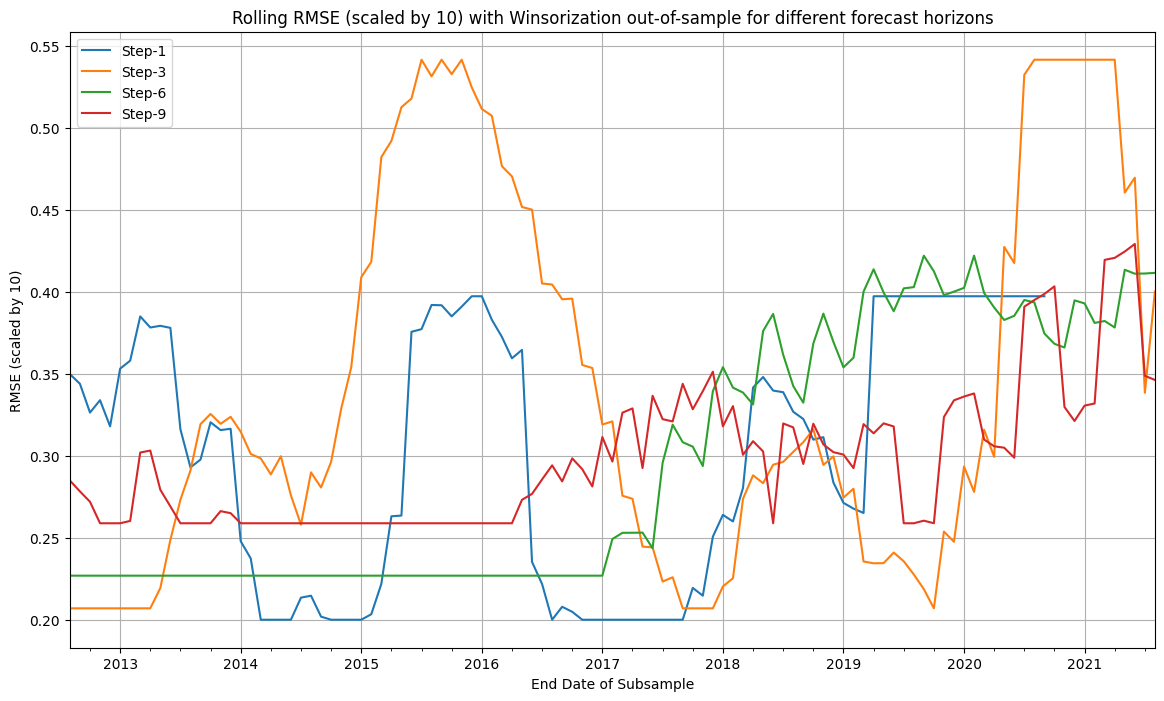

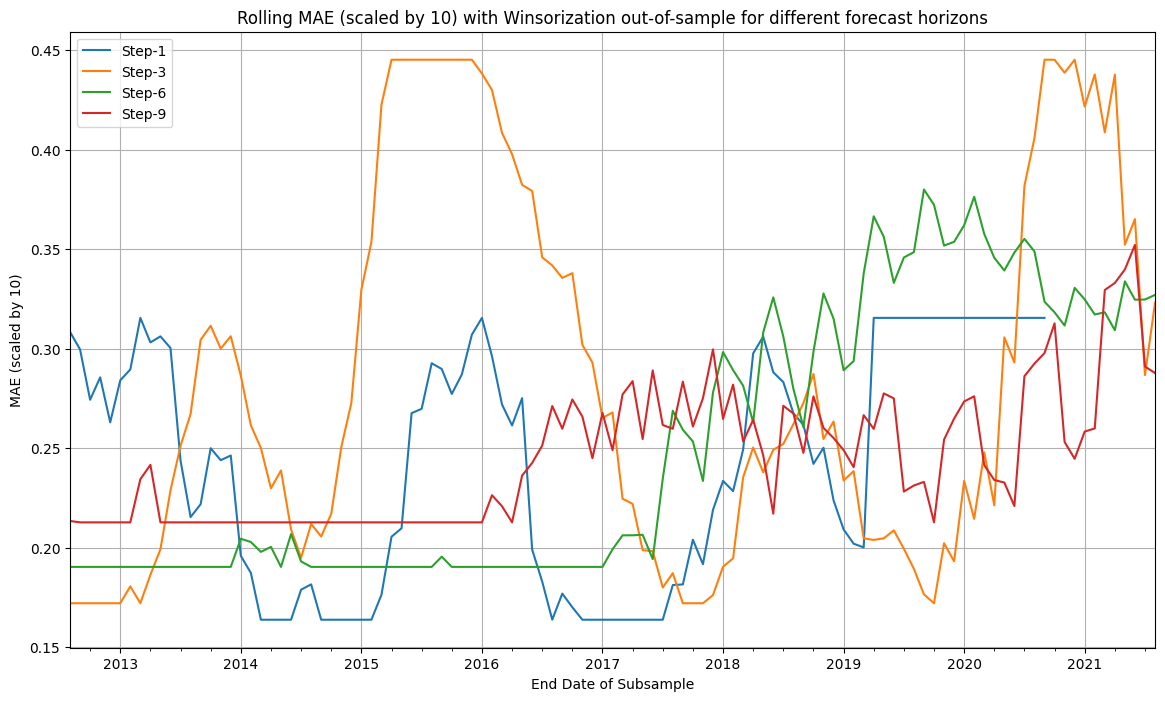

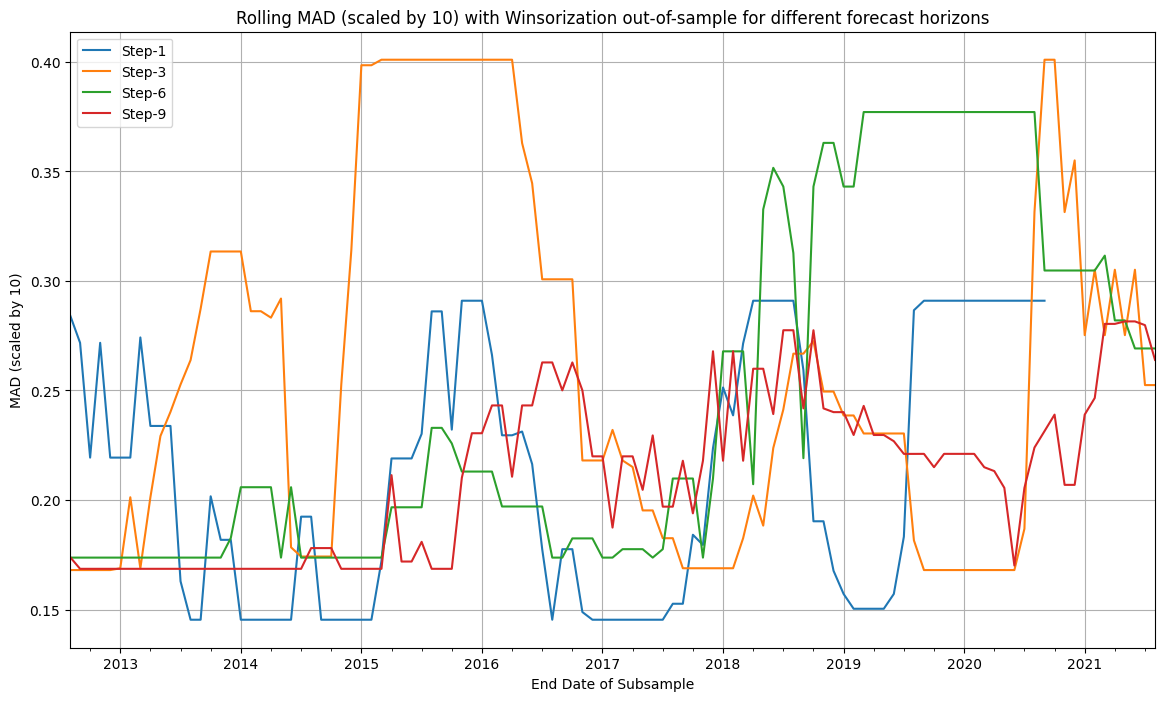

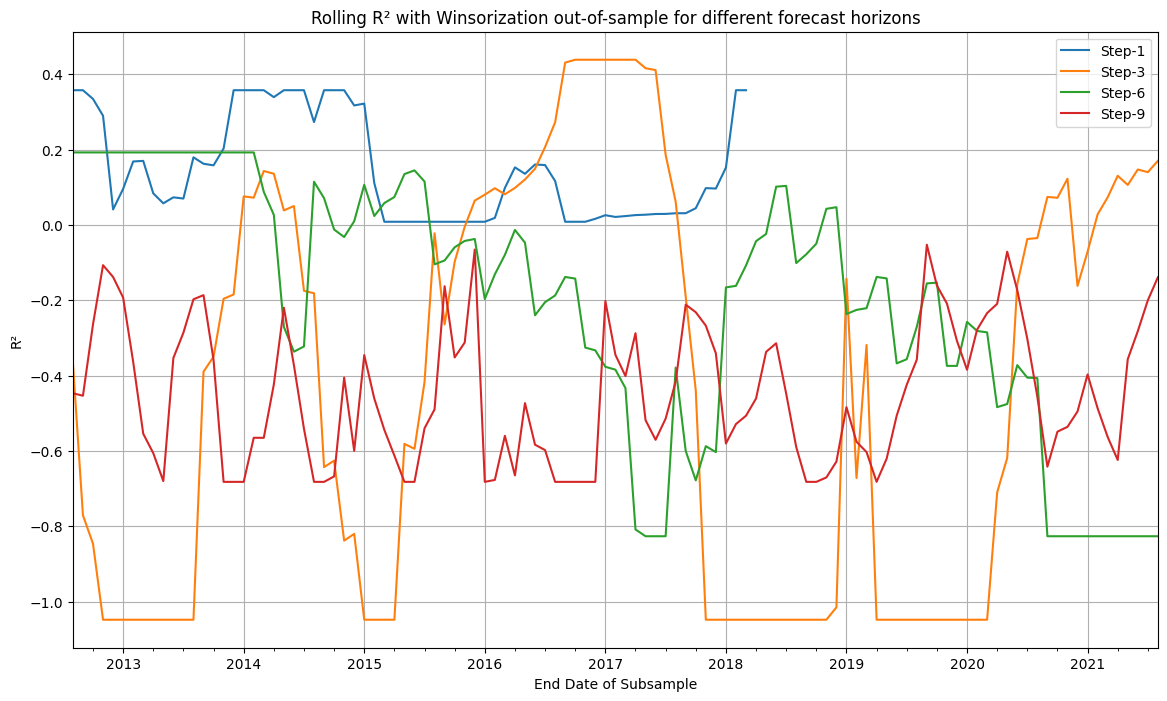

Saved: rmse_tau_1.png
Saved: rmse_tau_3.png
Saved: rmse_tau_6.png
Saved: rmse_tau_9.png
Saved: mae_tau_1.png
Saved: mae_tau_3.png
Saved: mae_tau_6.png
Saved: mae_tau_9.png
Saved: mad_tau_1.png
Saved: mad_tau_3.png
Saved: mad_tau_6.png
Saved: mad_tau_9.png
Saved: r_sq_tau_1.png
Saved: r_sq_tau_3.png
Saved: r_sq_tau_6.png
Saved: r_sq_tau_9.png

FINAL SUMMARY - Rolling RMSE/MAE/MAD (scaled by 10) + Rolling OoS R² (Ba Chu's methodology)
Rolling window size: 12

--- Horizon h=1 ---
Model           RMSE×10        (IQR)          MAE×10         (IQR)          MAD×10         (IQR)          R²             (IQR)         
----------------------------------------------------------------------------------------------------------------------------------
CatBoost        0.3165         0.1707         0.2497         0.1211         0.2177         0.1315         0.0979         0.2955        
LightGBM        0.3146         0.1771         0.2512         0.1218         0.2025         0.1150         0.0655   

In [ ]:
## pdc get gt off

### pdc gt

#### ## pdc off
### testing old technique


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plta
import seaborn as sns
from scipy.stats import mstats


custom_colors = {
    'CatBoost': 'blue',
    'LightGBM': 'green',
    'Random Forest': 'orange',
    'GBM': 'purple',
    'XGBoost': 'pink'
}

# Base path
base_path = 'C:\\Users\\shafiullah.qureshi\\OneDrive - Government of Alberta\\Documents\\nowcast_gdp\\Dynamic Feature Selection for Canadian GDP'

# Model folders
model_folders = [
    (f'{base_path}\\OoS_metrics_Catboost_gt_off', 'CatBoost'),
    (f'{base_path}\\OoS_metrics_LightGBM_gt_off', 'LightGBM'),
    (f'{base_path}\\OoS_metrics_rf_gt_off', 'Random Forest'),
    (f'{base_path}\\OoS_metrics_GBM_gt_off', 'GBM'),
    (f'{base_path}\\OoS_metrics_xgboost_gt_off', 'XGBoost')
]

# Create output folder
output_folder = 'graph_pdc_gt_off'
os.makedirs(output_folder, exist_ok=True)

# Horizons
horizons = ['tau_1', 'tau_3', 'tau_6', 'tau_9']
taus = [1, 3, 6, 9]
horizon_to_tau = {'tau_1': 1, 'tau_3': 3, 'tau_6': 6, 'tau_9': 9}

# List of metrics
metrics = ['rmse', 'mae', 'mad', 'r_sq']

# Mapping for nice labels
metric_labels = {
    'rmse': 'RMSE',
    'mae': 'MAE',
    'mad': 'MAD',
    'r_sq': 'R²'
}

# Rolling window size (as per Ba Chu's code)
ROLLING_WINDOW = 12
ROLLMEAN_WINDOW = 30
# Scale factor
SCALE = 100

# Winsorization functions
def winsorize_data(data, limits=(0.20, 0.20)):
    if len(data) == 0:
        return np.array([])
    return mstats.winsorize(data, limits=limits)

# Define function to calculate the interquartile range (from Ba Chu's code)
def find_iqr(x):
    q75 = np.percentile(x, 75)
    q25 = np.percentile(x, 25)
    return q75 - q25

# Define function to calculate the median (from Ba Chu's code)
def find_med(x):
    return np.percentile(x, 50)

# ============================================================================
# STEP 1: Load data and calculate metrics using ROLLING methodology
# ============================================================================

all_metrics_data = []
all_errors_data = {}
all_rolling_r_sq_data = {}
all_rolling_rmse_data = {}
all_rolling_mae_data = {}
all_rolling_mad_data = {}

# Store results for rolling charts
results = {tau: {'rmse': [], 'mae': [], 'mad': [], 'r_sq': [], 'ssample_end_date': []} for tau in taus}

for folder_path, model_name in model_folders:
    all_errors_data[model_name] = {}
    all_rolling_r_sq_data[model_name] = {}
    all_rolling_rmse_data[model_name] = {}
    all_rolling_mae_data[model_name] = {}
    all_rolling_mad_data[model_name] = {}

    for tau in taus:
        avp_file = f'{folder_path}\\actual_vs_predicted_tau_{tau}.csv'
        window_file = f'{folder_path}\\winsorized\\OoS_metrics_tau_{tau}_winsorized.csv'

        try:
            avp_df = pd.read_csv(avp_file)
            window_df = pd.read_csv(window_file)

            # Get actual and predicted values
            actual = pd.Series(avp_df['actual'].values)
            predicted = pd.Series(avp_df['predicted'].values)

            # Calculate individual errors
            errors = actual - predicted
            abs_errors = np.abs(errors)
            sq_errors = errors ** 2

            # ================================================================
            # ROLLING RMSE (Ba Chu's methodology)
            # ================================================================
            rolling_rmse = SCALE * np.sqrt(sq_errors.rolling(ROLLING_WINDOW).mean())
            rolling_rmse = rolling_rmse.dropna()

            # Apply winsorization
            rolling_rmse_winsorized = winsorize_data(rolling_rmse.values)

            # Get median and IQR
            median_rmse = find_med(rolling_rmse_winsorized)
            iqr_rmse = find_iqr(rolling_rmse_winsorized)

            # Store for plots
            all_rolling_rmse_data[model_name][tau] = rolling_rmse_winsorized

            # ================================================================
            # ROLLING MAE (Ba Chu's methodology)
            # ================================================================
            rolling_mae = SCALE * abs_errors.rolling(ROLLING_WINDOW).mean()
            rolling_mae = rolling_mae.dropna()

            # Apply winsorization
            rolling_mae_winsorized = winsorize_data(rolling_mae.values)

            # Get median and IQR
            median_mae = find_med(rolling_mae_winsorized)
            iqr_mae = find_iqr(rolling_mae_winsorized)

            # Store for plots
            all_rolling_mae_data[model_name][tau] = rolling_mae_winsorized

            # ================================================================
            # ROLLING MAD (median of absolute errors in rolling window)
            # ================================================================
            rolling_mad = SCALE * abs_errors.rolling(ROLLING_WINDOW).median()
            rolling_mad = rolling_mad.dropna()

            # Apply winsorization
            rolling_mad_winsorized = winsorize_data(rolling_mad.values)

            # Get median and IQR
            median_mad = find_med(rolling_mad_winsorized)
            iqr_mad = find_iqr(rolling_mad_winsorized)

            # Store for plots
            all_rolling_mad_data[model_name][tau] = rolling_mad_winsorized

            # ================================================================
            # ROLLING R² (Ba Chu's methodology) — Rolling-Mean benchmark (window=30)
            # ================================================================
            # Benchmark forecast = rolling mean of past GDP prior to each date (proxy using available 'actual' series)
            # Note: With only OoS 'actual' available, this is the closest in-file proxy to Ba Chu's gdp_df-based roll_mean.
            bench_pred = actual.shift(1).rolling(ROLLMEAN_WINDOW, min_periods=ROLLMEAN_WINDOW).mean()

            # Rolling RMSE for benchmark over the same RMSE rolling window (12)
            sq_errors_benchmark = (actual - bench_pred) ** 2
            rolling_rmse_benchmark = SCALE * np.sqrt(sq_errors_benchmark.rolling(ROLLING_WINDOW).mean())
            rolling_rmse_benchmark = rolling_rmse_benchmark.dropna()

            # Align lengths
            min_len = min(len(rolling_rmse), len(rolling_rmse_benchmark))
            rolling_rmse_aligned = rolling_rmse.iloc[-min_len:].values
            rolling_rmse_benchmark_aligned = rolling_rmse_benchmark.iloc[-min_len:].values

            # Calculate R² = 1 - (RMSE_model / RMSE_benchmark)²
            # (guard against division by zero)
            den = np.where(rolling_rmse_benchmark_aligned == 0, np.nan, rolling_rmse_benchmark_aligned)
            rolling_r_sq = 1 - np.power(rolling_rmse_aligned / den, 2)
            rolling_r_sq = rolling_r_sq[~np.isnan(rolling_r_sq)]

            # Apply winsorization
            rolling_r_sq_winsorized = winsorize_data(rolling_r_sq)

            # Get median and IQR
            median_r_sq = find_med(rolling_r_sq_winsorized)
            iqr_r_sq = find_iqr(rolling_r_sq_winsorized)

            # Store rolling R² for plots
            all_rolling_r_sq_data[model_name][tau] = rolling_r_sq_winsorized


            # ================================================================
            # Store metrics
            # ================================================================
            all_metrics_data.append({
                'Model': model_name,
                'Horizon': f'tau_{tau}',
                'tau': tau,
                'rmse': median_rmse,
                'mae': median_mae,
                'mad': median_mad,
                'r_sq': median_r_sq,
                'iqr_rmse': iqr_rmse,
                'iqr_mae': iqr_mae,
                'iqr_mad': iqr_mad,
                'iqr_r_sq': iqr_r_sq
            })

            # Store for boxplots
            all_errors_data[model_name][tau] = abs_errors.values

            # Store for rolling charts (only for first model)
            if model_name == 'CatBoost':
                results[tau]['rmse'] = rolling_rmse.tolist()
                results[tau]['mae'] = rolling_mae.tolist()
                results[tau]['mad'] = rolling_mad.tolist()
                results[tau]['r_sq'] = rolling_r_sq_winsorized.tolist()
                results[tau]['ssample_end_date'] = window_df['ssample_end_date'].tolist()

            print(f"Loaded: {model_name} tau={tau}, rolling points: {len(rolling_rmse)}")

        except FileNotFoundError as e:
            print(f"NOT FOUND: {e}")

# Create DataFrame
metrics_df = pd.DataFrame(all_metrics_data)

# ============================================================================
# STEP 2: Create combined_metrics_summary.csv
# ============================================================================

combined_summary_df = pd.DataFrame()

for horizon in horizons:
    tau = horizon_to_tau[horizon]
    for metric in metrics:
        iqr_col = f'iqr_{metric}'

        for folder_path, model_name in model_folders:
            model_data = metrics_df[(metrics_df['Model'] == model_name) & (metrics_df['tau'] == tau)]

            if len(model_data) > 0:
                value = model_data[metric].values[0]
                iqr = model_data[iqr_col].values[0]

                combined_summary_df = pd.concat([combined_summary_df, pd.DataFrame([{
                    'Horizon': horizon,
                    'Metric': metric,
                    'Model': model_name,
                    'Median': value,
                    'IQR': iqr
                }])], ignore_index=True)

combined_summary_df.to_csv(f'{output_folder}/combined_metrics_summary.csv', index=False)
print(f"\nSaved: {output_folder}/combined_metrics_summary.csv")

# ============================================================================
# STEP 3: Create sorted_metrics_summary.csv
# ============================================================================

sorted_df = combined_summary_df.sort_values(by=['Horizon', 'Metric', 'Model'])
sorted_df.to_csv(f'{output_folder}/sorted_metrics_summary.csv', index=False)
print(f"Saved: {output_folder}/sorted_metrics_summary.csv")

# ============================================================================
# STEP 4: Create final_formatted_output.xlsx (Excel only)
# ============================================================================

# Order: RMSE, MAD, MAE, R^2 for each horizon
metric_order = ['rmse', 'mad', 'mae', 'r_sq']
metric_labels_excel = {
    'rmse': 'RMSE',
    'mad': 'MAD',
    'mae': 'MAE',
    'r_sq': 'R^2'
}

# Model order as in Excel
model_order = ['GBM', 'XGBoost', 'CatBoost', 'Random Forest', 'LightGBM']

final_rows = []
for model_name in model_order:
    row = {'Model': model_name}
    for tau in taus:
        model_data = metrics_df[(metrics_df['Model'] == model_name) & (metrics_df['tau'] == tau)]
        if len(model_data) > 0:
            for metric in metric_order:
                iqr_col = f'iqr_{metric}'
                value = model_data[metric].values[0]
                iqr = model_data[iqr_col].values[0]
                col_name = f'{metric_labels_excel[metric]} (h={tau})'
                row[col_name] = f'{value:.4f}\n({iqr:.4f})'
    final_rows.append(row)

final_df = pd.DataFrame(final_rows)

# Reorder columns: Model, then RMSE/MAD/MAE/R^2 for each horizon
col_order = ['Model']
for tau in taus:
    for metric in metric_order:
        col_order.append(f'{metric_labels_excel[metric]} (h={tau})')

final_df = final_df[col_order]
final_df.to_csv(f'{output_folder}/final_formatted_output.csv', index=False)
print(f"Saved: {output_folder}/final_formatted_output.csv")

# ============================================================================
# STEP 5: Rolling line charts (ORIGINAL FORMAT)
# ============================================================================

# Rolling RMSE
plt.figure(figsize=(14, 8))
for tau, result in results.items():
    if result['rmse']:
        rmse_data = winsorize_data(np.array(result['rmse']))
        dates = pd.to_datetime(result['ssample_end_date'])
        # Align lengths
        min_len = min(len(rmse_data), len(dates))
        rmse_series = pd.Series(rmse_data[:min_len], index=dates[:min_len])
        rmse_series.plot(label=f'Step-{tau}')
    else:
        print(f"No RMSE data to plot for tau={tau}")

plt.title('Rolling RMSE (scaled by 10) with Winsorization out-of-sample for different forecast horizons')
plt.xlabel('End Date of Subsample')
plt.ylabel('RMSE (scaled by 10)')
plt.legend()
plt.grid(True)
plt.savefig(f'{output_folder}/rolling_rmse.png', bbox_inches='tight')
plt.show()

# Rolling MAE
plt.figure(figsize=(14, 8))
for tau, result in results.items():
    if result['mae']:
        mae_data = winsorize_data(np.array(result['mae']))
        dates = pd.to_datetime(result['ssample_end_date'])
        min_len = min(len(mae_data), len(dates))
        mae_series = pd.Series(mae_data[:min_len], index=dates[:min_len])
        mae_series.plot(label=f'Step-{tau}')
    else:
        print(f"No MAE data to plot for tau={tau}")

plt.title('Rolling MAE (scaled by 10) with Winsorization out-of-sample for different forecast horizons')
plt.xlabel('End Date of Subsample')
plt.ylabel('MAE (scaled by 10)')
plt.legend()
plt.grid(True)
plt.savefig(f'{output_folder}/rolling_mae.png', bbox_inches='tight')
plt.show()

# Rolling MAD
plt.figure(figsize=(14, 8))
for tau, result in results.items():
    if result['mad']:
        mad_data = winsorize_data(np.array(result['mad']))
        dates = pd.to_datetime(result['ssample_end_date'])
        min_len = min(len(mad_data), len(dates))
        mad_series = pd.Series(mad_data[:min_len], index=dates[:min_len])
        mad_series.plot(label=f'Step-{tau}')
    else:
        print(f"No MAD data to plot for tau={tau}")

plt.title('Rolling MAD (scaled by 10) with Winsorization out-of-sample for different forecast horizons')
plt.xlabel('End Date of Subsample')
plt.ylabel('MAD (scaled by 10)')
plt.legend()
plt.grid(True)
plt.savefig(f'{output_folder}/rolling_mad.png', bbox_inches='tight')
plt.show()

# Rolling R²
plt.figure(figsize=(14, 8))
for tau in taus:
    if 'CatBoost' in all_rolling_r_sq_data and tau in all_rolling_r_sq_data['CatBoost']:
        r_sq_data = all_rolling_r_sq_data['CatBoost'][tau]
        if len(r_sq_data) > 0:
            dates = pd.to_datetime(results[tau]['ssample_end_date'])
            min_len = min(len(r_sq_data), len(dates))
            r_sq_series = pd.Series(r_sq_data[:min_len], index=dates[:min_len])
            r_sq_series.plot(label=f'Step-{tau}')

plt.title('Rolling R² with Winsorization out-of-sample for different forecast horizons')
plt.xlabel('End Date of Subsample')
plt.ylabel('R²')
plt.legend()
plt.grid(True)
plt.savefig(f'{output_folder}/rolling_r_sq.png', bbox_inches='tight')
plt.show()

# ============================================================================
# STEP 6: Box plots - BY MODEL for each horizon
# ============================================================================

# Box plots for RMSE - comparing models at each horizon
for tau in taus:
    plt.figure(figsize=(14, 8))
    data_to_plot = []
    model_labels_list = []

    for folder_path, model_name in model_folders:
        if model_name in all_rolling_rmse_data and tau in all_rolling_rmse_data[model_name]:
            data = all_rolling_rmse_data[model_name][tau]
            data_to_plot.append(data)
            model_labels_list.append(model_name)

    if data_to_plot:
        box = plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=model_labels_list)
        for patch, model_name in zip(box['boxes'], model_labels_list):
            patch.set_facecolor(custom_colors.get(model_name, 'grey'))

        plt.xlabel('Model', fontsize=14)
        plt.ylabel('RMSE', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.savefig(f'{output_folder}/rmse_tau_{tau}.png', bbox_inches='tight')
        plt.close()
        print(f"Saved: rmse_tau_{tau}.png")

# Box plots for MAE - comparing models at each horizon
for tau in taus:
    plt.figure(figsize=(14, 8))
    data_to_plot = []
    model_labels_list = []

    for folder_path, model_name in model_folders:
        if model_name in all_rolling_mae_data and tau in all_rolling_mae_data[model_name]:
            data = all_rolling_mae_data[model_name][tau]
            data_to_plot.append(data)
            model_labels_list.append(model_name)

    if data_to_plot:
        box = plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=model_labels_list)
        for patch, model_name in zip(box['boxes'], model_labels_list):
            patch.set_facecolor(custom_colors.get(model_name, 'grey'))

        plt.xlabel('Model', fontsize=14)
        plt.ylabel('MAE', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.savefig(f'{output_folder}/mae_tau_{tau}.png', bbox_inches='tight')
        plt.close()
        print(f"Saved: mae_tau_{tau}.png")

# Box plots for MAD - comparing models at each horizon
for tau in taus:
    plt.figure(figsize=(14, 8))
    data_to_plot = []
    model_labels_list = []

    for folder_path, model_name in model_folders:
        if model_name in all_rolling_mad_data and tau in all_rolling_mad_data[model_name]:
            data = all_rolling_mad_data[model_name][tau]
            data_to_plot.append(data)
            model_labels_list.append(model_name)

    if data_to_plot:
        box = plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=model_labels_list)
        for patch, model_name in zip(box['boxes'], model_labels_list):
            patch.set_facecolor(custom_colors.get(model_name, 'grey'))

        plt.xlabel('Model', fontsize=14)
        plt.ylabel('MAD', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.savefig(f'{output_folder}/mad_tau_{tau}.png', bbox_inches='tight')
        plt.close()
        print(f"Saved: mad_tau_{tau}.png")

# Box plot for R² - comparing models at each horizon
for tau in taus:
    plt.figure(figsize=(14, 8))
    data_to_plot = []
    model_labels_list = []

    for folder_path, model_name in model_folders:
        if model_name in all_rolling_r_sq_data and tau in all_rolling_r_sq_data[model_name]:
            data = all_rolling_r_sq_data[model_name][tau]
            if len(data) > 0:
                data_to_plot.append(data)
                model_labels_list.append(model_name)

    if data_to_plot:
        box = plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=model_labels_list)
        for patch, model_name in zip(box['boxes'], model_labels_list):
            patch.set_facecolor(custom_colors.get(model_name, 'grey'))

        plt.xlabel('Model', fontsize=14)
        plt.ylabel('R²', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.savefig(f'{output_folder}/r_sq_tau_{tau}.png', bbox_inches='tight')
        plt.close()
        print(f"Saved: r_sq_tau_{tau}.png")

# ============================================================================
# STEP 7: Print Summary WITH IQR
# ============================================================================

print("\n" + "="*130)
print("FINAL SUMMARY - Rolling RMSE/MAE/MAD (scaled by 10) + Rolling OoS R² (Ba Chu's methodology)")
print(f"Rolling window size: {ROLLING_WINDOW}")
print("="*130)

for tau in taus:
    print(f"\n--- Horizon h={tau} ---")
    print(f"{'Model':<15} {'RMSE×10':<14} {'(IQR)':<14} {'MAE×10':<14} {'(IQR)':<14} {'MAD×10':<14} {'(IQR)':<14} {'R²':<14} {'(IQR)':<14}")
    print("-"*130)

    subset = metrics_df[metrics_df['tau'] == tau]
    for _, row in subset.iterrows():
        print(f"{row['Model']:<15} {row['rmse']:<14.4f} {row['iqr_rmse']:<14.4f} {row['mae']:<14.4f} {row['iqr_mae']:<14.4f} {row['mad']:<14.4f} {row['iqr_mad']:<14.4f} {row['r_sq']:<14.4f} {row['iqr_r_sq']:<14.4f}")

print("\n" + "="*130)
print("Note: RMSE, MAE, MAD are scaled by 10 for easier comparison")
print("      All metrics use ROLLING window methodology (Ba Chu's approach)")
print("      Reported values are MEDIAN of rolling series")
print("      IQR computed from rolling series")
print("="*130)
print("Files saved to:", output_folder)
print("="*130)

In [ ]:
## Diebold-Mariano Test for Official Data
## Pairwise Model Comparisons Only

import os
## Diebold-Mariano Test for Official Data
## Pairwise Model Comparisons Only

import os
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# Diebold-Mariano Test Function
# ============================================================================
def diebold_mariano_test(e1, e2, h=1, loss='MSE'):
    """
    Diebold-Mariano test for comparing forecast accuracy with HLN correction.

    Parameters:
    -----------
    e1 : array-like
        Forecast errors from model 1 (aligned)
    e2 : array-like
        Forecast errors from model 2 (aligned)
    h : int
        Forecast horizon (for HAC variance correction)
    loss : str
        'MSE' for squared errors, 'MAE' for absolute errors

    Returns:
    --------
    dm_stat : float
        Diebold-Mariano test statistic
    p_value : float
        Two-sided p-value
    """
    e1 = np.asarray(e1, dtype=float)
    e2 = np.asarray(e2, dtype=float)

    # Ensure equal length (should be true after alignment)
    n = min(len(e1), len(e2))
    e1 = e1[:n]
    e2 = e2[:n]

    # Calculate loss differential
    if loss == 'MSE':
        d = e1**2 - e2**2
    elif loss == 'MAE':
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("loss must be 'MSE' or 'MAE'")

    # Drop NaNs (safety)
    d = d[~np.isnan(d)]
    n = len(d)
    if n < 10:
        return np.nan, np.nan

    d_mean = np.mean(d)

    # HAC variance estimation (Newey-West)
    gamma_0 = np.var(d, ddof=1)
    gamma_sum = 0.0

    # Use max(h, int(floor(4*(n/100)^(2/9)))) for lag length
    # This is more robust for multi-step forecasts
    max_lag = max(h, int(np.floor(4 * (n/100)**(2/9))))

    # Bartlett kernel up to max_lag
    for k in range(1, min(max_lag, n)):
        # FIXED: autocovariance denominator should be n, not (n-1)
        gamma_k = np.sum((d[k:] - d_mean) * (d[:-k] - d_mean)) / n
        weight = 1 - k / (max_lag + 1)
        gamma_sum += 2 * weight * gamma_k

    var_d = (gamma_0 + gamma_sum) / n

    # Handle edge cases
    if not np.isfinite(var_d) or var_d <= 0:
        var_d = gamma_0 / n

    # Standard DM statistic
    dm_stat = d_mean / np.sqrt(var_d)

    # CRITICAL FIX: Harvey-Leybourne-Newbold (1998) small-sample correction
    # This adjusts for finite sample bias in multi-step forecasts
    hlm_correction = np.sqrt((n + 1 - 2*h + h*(h-1)/n) / n)
    modified_dm = dm_stat * hlm_correction

    # CRITICAL FIX: Use t-distribution instead of normal for small samples
    # Degrees of freedom = n - 1
    p_value = 2 * (1 - stats.t.cdf(np.abs(modified_dm), df=n-1))

    return modified_dm, p_value


def dm_test_with_details(e1, e2, model1_name, model2_name, h=1, loss='MSE'):
    """
    Run DM test and return formatted results.
    """
    dm_stat, p_value = diebold_mariano_test(e1, e2, h=h, loss=loss)

    if not np.isfinite(dm_stat) or not np.isfinite(p_value):
        return {
            'Model 1': model1_name,
            'Model 2': model2_name,
            'DM Statistic': np.nan,
            'p-value': np.nan,
            'Significance': '',
            'Better Model': 'Insufficient data'
        }

    # Determine significance
    if p_value < 0.01:
        sig = '***'
    elif p_value < 0.05:
        sig = '**'
    elif p_value < 0.10:
        sig = '*'
    else:
        sig = ''

    # Negative DM => Model 1 better (since d = loss1 - loss2)
    better = model1_name if dm_stat < 0 else model2_name

    return {
        'Model 1': model1_name,
        'Model 2': model2_name,
        'DM Statistic': dm_stat,
        'p-value': p_value,
        'Significance': sig,
        'Better Model': better if p_value < 0.10 else 'No significant difference'
    }


# ============================================================================
# Configuration
# ============================================================================

# Base path (UNCHANGED)
base_path = r'C:\Users\shafiullah.qureshi\OneDrive - Government of Alberta\Documents\nowcast_gdp\Dynamic Feature Selection for Canadian GDP'

# Model folders (UNCHANGED)
model_folders = {
    'CatBoost': f'{base_path}\\OoS_metrics_Catboost_off',
    'LightGBM': f'{base_path}\\OoS_metrics_LightGBM_off',
    'Random Forest': f'{base_path}\\OoS_metrics_rf_off',
    'GBM': f'{base_path}\\OoS_metrics_GBM_off',
    'XGBoost': f'{base_path}\\OoS_metrics_xgboost_off',
    'ARIMA': f'{base_path}\\OoS_metrics_ARIMA_off'
}

# Output folder (UNCHANGED)
output_folder = 'graph_pdc_off'
os.makedirs(output_folder, exist_ok=True)

# Horizons (UNCHANGED)
taus = [1, 3, 6, 9]


# ============================================================================
# Load Data (FIXED: store indexed Series, not numpy arrays)
# ============================================================================

print("Loading forecast errors...")
print("=" * 80)

all_errors = {}

# Preferred alignment keys (use first one that exists in file)
ALIGN_KEYS = ['date', 'window_end', 'sstart', 'send', 'slice_id']

for model_name, folder_path in model_folders.items():
    all_errors[model_name] = {}

    for tau in taus:
        avp_file = f'{folder_path}\\actual_vs_predicted_tau_{tau}.csv'

        try:
            avp_df = pd.read_csv(avp_file)
            avp_df.columns = avp_df.columns.str.strip()

            # If file contains multiple horizons, filter properly
            if 'horizon_step' in avp_df.columns:
                avp_df = avp_df[avp_df['horizon_step'] == tau].copy()

            # Choose alignment key
            key_col = next((c for c in ALIGN_KEYS if c in avp_df.columns), None)
            if key_col is None:
                raise ValueError(f"{model_name} tau={tau}: No alignment key found. Need one of {ALIGN_KEYS}")

            # Build index
            idx = avp_df[key_col]
            if key_col in ['date', 'window_end', 'sstart', 'send']:
                idx = pd.to_datetime(idx)

            # Compute errors
            # Store actuals and predictions separately (not pre-computed errors)
            actuals = avp_df['actual'].astype(float).values
            predictions = avp_df['predicted'].astype(float).values

            # Store as DataFrames with index
            s = pd.DataFrame({'actual': actuals, 'predicted': predictions}, index=idx).sort_index()

            # Drop duplicate index entries if any
            s = s[~s.index.duplicated(keep='last')]

            # Drop NaNs
            s = s.dropna()

            # Drop duplicate index entries if any
            s = s[~s.index.duplicated(keep='last')]

            # Drop NaNs
            s = s.dropna()

            all_errors[model_name][tau] = s
            print(f"Loaded: {model_name} tau={tau}, n={len(s)} (key={key_col})")

        except FileNotFoundError:
            print(f"NOT FOUND: {model_name} tau={tau}")
        except Exception as e:
            print(f"ERROR loading {model_name} tau={tau}: {e}")


# ============================================================================
# Run Diebold-Mariano Tests (Pairwise Only)
# ============================================================================

print("\n" + "=" * 80)
print("DIEBOLD-MARIANO TEST RESULTS")
print("Pairwise Model Comparisons")
print("=" * 80)

all_results = []
models = list(model_folders.keys())

for tau in taus:
    print(f"\n{'=' * 80}")
    print(f"HORIZON τ = {tau}")
    print(f"{'=' * 80}")

    print(f"\n{'Model 1':<15} {'Model 2':<15} {'DM Stat':<12} {'p-value':<12} {'Sig':<6} {'Better Model':<24} {'n_common':<8}")
    print("-" * 105)

    for i, model1 in enumerate(models):
        for model2 in models[i + 1:]:

            # Skip if a model didn't load for this horizon
            if tau not in all_errors.get(model1, {}) or tau not in all_errors.get(model2, {}):
                print(f"{model1:<15} {model2:<15} {'SKIP':<12} {'-':<12} {'-':<6} {'Missing tau file':<24} {'-':<8}")
                continue

            s1 = all_errors[model1][tau]   # Series
            s2 = all_errors[model2][tau]   # Series

            # Align on common index
            common_idx = s1.index.intersection(s2.index)

            if len(common_idx) < 30:
                print(f"{model1:<15} {model2:<15} {'SKIP':<12} {'-':<12} {'-':<6} {'Too few common points':<24} {len(common_idx):<8}")
                continue

            # Use Model 1's actual as the common actual (they should be identical)
            actual_common = s1.loc[common_idx]['actual'].to_numpy()
            pred1 = s1.loc[common_idx]['predicted'].to_numpy()
            pred2 = s2.loc[common_idx]['predicted'].to_numpy()

            # Compute errors using SAME actual for both models
            e1 = actual_common - pred1
            e2 = actual_common - pred2

            result = dm_test_with_details(e1, e2, model1, model2, h=tau, loss='MSE')
            result['Horizon'] = tau
            result['n_common'] = len(common_idx)
            all_results.append(result)

            dm_stat = result['DM Statistic']
            p_val = result['p-value']
            sig = result['Significance']
            better = result['Better Model']

            if np.isfinite(dm_stat) and np.isfinite(p_val):
                print(f"{model1:<15} {model2:<15} {dm_stat:<12.4f} {p_val:<12.4f} {sig:<6} {better:<24} {len(common_idx):<8}")
            else:
                print(f"{model1:<15} {model2:<15} {'NaN':<12} {'NaN':<12} {sig:<6} {better:<24} {len(common_idx):<8}")


# ============================================================================
# Save Results
# ============================================================================

results_df = pd.DataFrame(all_results)
results_df.to_csv(f'{output_folder}/dm_test_pairwise_results.csv', index=False)
print(f"\n\nSaved: {output_folder}/dm_test_pairwise_results.csv")


# ============================================================================
# Summary: Significant Results Only
# ============================================================================

print("\n" + "=" * 80)
print("SIGNIFICANT RESULTS SUMMARY")
print("=" * 80)

sig_results = results_df[(results_df['Significance'] != '') & (results_df['Better Model'] != 'Insufficient data')]

print(f"\nTotal comparisons saved: {len(results_df)}")
print(f"Significant at 10%: {len(sig_results)}")
print(f"Significant at 5%: {len(results_df[pd.to_numeric(results_df['p-value'], errors='coerce') < 0.05])}")
print(f"Significant at 1%: {len(results_df[pd.to_numeric(results_df['p-value'], errors='coerce') < 0.01])}")

if len(sig_results) > 0:
    print("\n" + "-" * 80)
    print("Significant Pairwise Comparisons:")
    print("-" * 80)
    for _, row in sig_results.iterrows():
        print(f"  τ={row['Horizon']}: {row['Model 1']} vs {row['Model 2']} → {row['Better Model']} (DM={row['DM Statistic']:.3f}, p={row['p-value']:.4f}) {row['Significance']}  n={row['n_common']}")


# ============================================================================
# Model Win Count Summary
# ============================================================================

print("\n" + "=" * 80)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 80)

win_counts = {model: {'wins': 0, 'losses': 0, 'ties': 0} for model in models}

for _, row in results_df.iterrows():
    if row.get('Significance', '') != '' and row.get('Better Model') not in ['No significant difference', 'Insufficient data']:
        winner = row['Better Model']
        loser = row['Model 1'] if row['Model 2'] == winner else row['Model 2']
        win_counts[winner]['wins'] += 1
        win_counts[loser]['losses'] += 1
    else:
        # Treat as tie (including insufficient data)
        win_counts[row['Model 1']]['ties'] += 1
        win_counts[row['Model 2']]['ties'] += 1

print(f"\n{'Model':<15} {'Wins':<10} {'Losses':<10} {'Ties':<10}")
print("-" * 45)
for model in models:
    print(f"{model:<15} {win_counts[model]['wins']:<10} {win_counts[model]['losses']:<10} {win_counts[model]['ties']:<10}")


# ============================================================================
# Best Model by Horizon (significant wins)
# ============================================================================

print("\n" + "=" * 80)
print("BEST MODEL BY HORIZON")
print("=" * 80)

for tau in taus:
    tau_results = sig_results[sig_results['Horizon'] == tau]

    if len(tau_results) > 0:
        horizon_wins = {}
        for _, row in tau_results.iterrows():
            winner = row['Better Model']
            horizon_wins[winner] = horizon_wins.get(winner, 0) + 1

        best_model = max(horizon_wins, key=horizon_wins.get)
        print(f"τ = {tau}: {best_model} ({horizon_wins[best_model]} significant wins)")
    else:
        print(f"τ = {tau}: No significant differences (or insufficient aligned data)")


# ============================================================================
# Final Summary for Paper
# ============================================================================

print("\n" + "=" * 80)
print("CONCLUSION FOR PAPER")
print("=" * 80)

overall_wins = {model: win_counts[model]['wins'] for model in models}
best_overall = max(overall_wins, key=overall_wins.get)

print(f"\nBest Overall Model (by significant DM wins): {best_overall}")
print(f"Total Significant Wins: {overall_wins[best_overall]}")
print(f"\nKey Finding: {best_overall} significantly outperforms other models (based on aligned DM tests).")

print("\n" + "=" * 80)
print("Note: Negative DM statistic = Model 1 is better")
print("      Positive DM statistic = Model 2 is better")
print("      ***, **, * = significant at 1%, 5%, 10% levels")
print("=" * 80)
print("Files saved to:", output_folder)
print("=" * 80)


Loading forecast errors...
Loaded: CatBoost tau=1, n=121 (key=date)
Loaded: CatBoost tau=3, n=119 (key=date)
Loaded: CatBoost tau=6, n=116 (key=date)
Loaded: CatBoost tau=9, n=113 (key=date)
Loaded: LightGBM tau=1, n=121 (key=date)
Loaded: LightGBM tau=3, n=119 (key=date)
Loaded: LightGBM tau=6, n=116 (key=date)
Loaded: LightGBM tau=9, n=113 (key=date)
Loaded: Random Forest tau=1, n=121 (key=date)
Loaded: Random Forest tau=3, n=119 (key=date)
Loaded: Random Forest tau=6, n=116 (key=date)
Loaded: Random Forest tau=9, n=113 (key=date)
Loaded: GBM tau=1, n=121 (key=date)
Loaded: GBM tau=3, n=119 (key=date)
Loaded: GBM tau=6, n=116 (key=date)
Loaded: GBM tau=9, n=113 (key=date)
Loaded: XGBoost tau=1, n=121 (key=date)
Loaded: XGBoost tau=3, n=119 (key=date)
Loaded: XGBoost tau=6, n=116 (key=date)
Loaded: XGBoost tau=9, n=113 (key=date)
Loaded: ARIMA tau=1, n=124 (key=date)
Loaded: ARIMA tau=3, n=122 (key=date)
Loaded: ARIMA tau=6, n=119 (key=date)
Loaded: ARIMA tau=9, n=116 (key=date)

DIEB

In [ ]:
## Diebold-Mariano Test for Official Data
## Pairwise Model Comparisons Only

import os
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# Diebold-Mariano Test Function
# ============================================================================

def diebold_mariano_test(e1, e2, h=1, loss='MSE'):
    """
    Diebold-Mariano test for comparing forecast accuracy.

    Parameters:
    -----------
    e1 : array-like
        Forecast errors from model 1 (aligned)
    e2 : array-like
        Forecast errors from model 2 (aligned)
    h : int
        Forecast horizon (for HAC variance correction)
    loss : str
        'MSE' for squared errors, 'MAE' for absolute errors

    Returns:
    --------
    dm_stat : float
        Diebold-Mariano test statistic
    p_value : float
        Two-sided p-value
    """
    e1 = np.asarray(e1, dtype=float)
    e2 = np.asarray(e2, dtype=float)

    # Ensure equal length (should be true after alignment)
    n = min(len(e1), len(e2))
    e1 = e1[:n]
    e2 = e2[:n]

    # Calculate loss differential
    if loss == 'MSE':
        d = e1**2 - e2**2
    elif loss == 'MAE':
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("loss must be 'MSE' or 'MAE'")

    # Drop NaNs (safety)
    d = d[~np.isnan(d)]
    n = len(d)
    if n < 10:
        return np.nan, np.nan

    d_mean = np.mean(d)

    # HAC variance estimation (Newey-West)
    gamma_0 = np.var(d, ddof=1)
    gamma_sum = 0.0

    # Bartlett kernel up to lag (h-1)
    for k in range(1, h):
        # autocovariance at lag k
        gamma_k = np.sum((d[k:] - d_mean) * (d[:-k] - d_mean)) / (n - 1)
        weight = 1 - k / h
        gamma_sum += 2 * weight * gamma_k

    var_d = (gamma_0 + gamma_sum) / n

    # Handle edge cases
    if not np.isfinite(var_d) or var_d <= 0:
        var_d = gamma_0 / n

    dm_stat = d_mean / np.sqrt(var_d)
    p_value = 2 * (1 - stats.norm.cdf(np.abs(dm_stat)))

    return dm_stat, p_value


def dm_test_with_details(e1, e2, model1_name, model2_name, h=1, loss='MSE'):
    """
    Run DM test and return formatted results.
    """
    dm_stat, p_value = diebold_mariano_test(e1, e2, h=h, loss=loss)

    if not np.isfinite(dm_stat) or not np.isfinite(p_value):
        return {
            'Model 1': model1_name,
            'Model 2': model2_name,
            'DM Statistic': np.nan,
            'p-value': np.nan,
            'Significance': '',
            'Better Model': 'Insufficient data'
        }

    # Determine significance
    if p_value < 0.01:
        sig = '***'
    elif p_value < 0.05:
        sig = '**'
    elif p_value < 0.10:
        sig = '*'
    else:
        sig = ''

    # Negative DM => Model 1 better (since d = loss1 - loss2)
    better = model1_name if dm_stat < 0 else model2_name

    return {
        'Model 1': model1_name,
        'Model 2': model2_name,
        'DM Statistic': dm_stat,
        'p-value': p_value,
        'Significance': sig,
        'Better Model': better if p_value < 0.10 else 'No significant difference'
    }


# ============================================================================
# Configuration
# ============================================================================

# Base path (UNCHANGED)
base_path = r'C:\Users\shafiullah.qureshi\OneDrive - Government of Alberta\Documents\nowcast_gdp\Dynamic Feature Selection for Canadian GDP'

# Model folders (UNCHANGED)
model_folders = {
    'CatBoost': f'{base_path}\\OoS_metrics_Catboost_gt',
    'LightGBM': f'{base_path}\\OoS_metrics_LightGBM_gt',
    'Random Forest': f'{base_path}\\OoS_metrics_rf_gt',
    'GBM': f'{base_path}\\OoS_metrics_GBM_gt',
    'XGBoost': f'{base_path}\\OoS_metrics_xgboost_gt',
    'ARIMA': f'{base_path}\\OoS_metrics_ARIMA_gt'
}

# Output folder (UNCHANGED)
output_folder = 'graph_pdc_gt'
os.makedirs(output_folder, exist_ok=True)

# Horizons (UNCHANGED)
taus = [1, 3, 6, 9]


# ============================================================================
# Load Data (FIXED: store indexed Series, not numpy arrays)
# ============================================================================

print("Loading forecast errors...")
print("=" * 80)

all_errors = {}

# Preferred alignment keys (use first one that exists in file)
ALIGN_KEYS = ['date', 'window_end', 'sstart', 'send', 'slice_id']

for model_name, folder_path in model_folders.items():
    all_errors[model_name] = {}

    for tau in taus:
        avp_file = f'{folder_path}\\actual_vs_predicted_tau_{tau}.csv'

        try:
            avp_df = pd.read_csv(avp_file)
            avp_df.columns = avp_df.columns.str.strip()

            # If file contains multiple horizons, filter properly
            if 'horizon_step' in avp_df.columns:
                avp_df = avp_df[avp_df['horizon_step'] == tau].copy()

            # Choose alignment key
            key_col = next((c for c in ALIGN_KEYS if c in avp_df.columns), None)
            if key_col is None:
                raise ValueError(f"{model_name} tau={tau}: No alignment key found. Need one of {ALIGN_KEYS}")

            # Build index
            idx = avp_df[key_col]
            if key_col in ['date', 'window_end', 'sstart', 'send']:
                idx = pd.to_datetime(idx)

            # Compute errors
            # Store actuals and predictions separately (not pre-computed errors)
            actuals = avp_df['actual'].astype(float).values
            predictions = avp_df['predicted'].astype(float).values

            # Store as DataFrames with index
            s = pd.DataFrame({'actual': actuals, 'predicted': predictions}, index=idx).sort_index()

            # Drop duplicate index entries if any
            s = s[~s.index.duplicated(keep='last')]

            # Drop NaNs
            s = s.dropna()

            # Drop duplicate index entries if any
            s = s[~s.index.duplicated(keep='last')]

            # Drop NaNs
            s = s.dropna()

            all_errors[model_name][tau] = s
            print(f"Loaded: {model_name} tau={tau}, n={len(s)} (key={key_col})")

        except FileNotFoundError:
            print(f"NOT FOUND: {model_name} tau={tau}")
        except Exception as e:
            print(f"ERROR loading {model_name} tau={tau}: {e}")


# ============================================================================
# Run Diebold-Mariano Tests (Pairwise Only)
# ============================================================================

print("\n" + "=" * 80)
print("DIEBOLD-MARIANO TEST RESULTS")
print("Pairwise Model Comparisons")
print("=" * 80)

all_results = []
models = list(model_folders.keys())

for tau in taus:
    print(f"\n{'=' * 80}")
    print(f"HORIZON τ = {tau}")
    print(f"{'=' * 80}")

    print(f"\n{'Model 1':<15} {'Model 2':<15} {'DM Stat':<12} {'p-value':<12} {'Sig':<6} {'Better Model':<24} {'n_common':<8}")
    print("-" * 105)

    for i, model1 in enumerate(models):
        for model2 in models[i + 1:]:

            # Skip if a model didn't load for this horizon
            if tau not in all_errors.get(model1, {}) or tau not in all_errors.get(model2, {}):
                print(f"{model1:<15} {model2:<15} {'SKIP':<12} {'-':<12} {'-':<6} {'Missing tau file':<24} {'-':<8}")
                continue

            s1 = all_errors[model1][tau]   # Series
            s2 = all_errors[model2][tau]   # Series

            # Align on common index
            common_idx = s1.index.intersection(s2.index)

            if len(common_idx) < 30:
                print(f"{model1:<15} {model2:<15} {'SKIP':<12} {'-':<12} {'-':<6} {'Too few common points':<24} {len(common_idx):<8}")
                continue

            # Use Model 1's actual as the common actual (they should be identical)
            actual_common = s1.loc[common_idx]['actual'].to_numpy()
            pred1 = s1.loc[common_idx]['predicted'].to_numpy()
            pred2 = s2.loc[common_idx]['predicted'].to_numpy()

            # Compute errors using SAME actual for both models
            e1 = actual_common - pred1
            e2 = actual_common - pred2

            result = dm_test_with_details(e1, e2, model1, model2, h=tau, loss='MSE')
            result['Horizon'] = tau
            result['n_common'] = len(common_idx)
            all_results.append(result)

            dm_stat = result['DM Statistic']
            p_val = result['p-value']
            sig = result['Significance']
            better = result['Better Model']

            if np.isfinite(dm_stat) and np.isfinite(p_val):
                print(f"{model1:<15} {model2:<15} {dm_stat:<12.4f} {p_val:<12.4f} {sig:<6} {better:<24} {len(common_idx):<8}")
            else:
                print(f"{model1:<15} {model2:<15} {'NaN':<12} {'NaN':<12} {sig:<6} {better:<24} {len(common_idx):<8}")


# ============================================================================
# Save Results
# ============================================================================

results_df = pd.DataFrame(all_results)
results_df.to_csv(f'{output_folder}/dm_test_pairwise_results.csv', index=False)
print(f"\n\nSaved: {output_folder}/dm_test_pairwise_results.csv")


# ============================================================================
# Summary: Significant Results Only
# ============================================================================

print("\n" + "=" * 80)
print("SIGNIFICANT RESULTS SUMMARY")
print("=" * 80)

sig_results = results_df[(results_df['Significance'] != '') & (results_df['Better Model'] != 'Insufficient data')]

print(f"\nTotal comparisons saved: {len(results_df)}")
print(f"Significant at 10%: {len(sig_results)}")
print(f"Significant at 5%: {len(results_df[pd.to_numeric(results_df['p-value'], errors='coerce') < 0.05])}")
print(f"Significant at 1%: {len(results_df[pd.to_numeric(results_df['p-value'], errors='coerce') < 0.01])}")

if len(sig_results) > 0:
    print("\n" + "-" * 80)
    print("Significant Pairwise Comparisons:")
    print("-" * 80)
    for _, row in sig_results.iterrows():
        print(f"  τ={row['Horizon']}: {row['Model 1']} vs {row['Model 2']} → {row['Better Model']} (DM={row['DM Statistic']:.3f}, p={row['p-value']:.4f}) {row['Significance']}  n={row['n_common']}")


# ============================================================================
# Model Win Count Summary
# ============================================================================

print("\n" + "=" * 80)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 80)

win_counts = {model: {'wins': 0, 'losses': 0, 'ties': 0} for model in models}

for _, row in results_df.iterrows():
    if row.get('Significance', '') != '' and row.get('Better Model') not in ['No significant difference', 'Insufficient data']:
        winner = row['Better Model']
        loser = row['Model 1'] if row['Model 2'] == winner else row['Model 2']
        win_counts[winner]['wins'] += 1
        win_counts[loser]['losses'] += 1
    else:
        # Treat as tie (including insufficient data)
        win_counts[row['Model 1']]['ties'] += 1
        win_counts[row['Model 2']]['ties'] += 1

print(f"\n{'Model':<15} {'Wins':<10} {'Losses':<10} {'Ties':<10}")
print("-" * 45)
for model in models:
    print(f"{model:<15} {win_counts[model]['wins']:<10} {win_counts[model]['losses']:<10} {win_counts[model]['ties']:<10}")


# ============================================================================
# Best Model by Horizon (significant wins)
# ============================================================================

print("\n" + "=" * 80)
print("BEST MODEL BY HORIZON")
print("=" * 80)

for tau in taus:
    tau_results = sig_results[sig_results['Horizon'] == tau]

    if len(tau_results) > 0:
        horizon_wins = {}
        for _, row in tau_results.iterrows():
            winner = row['Better Model']
            horizon_wins[winner] = horizon_wins.get(winner, 0) + 1

        best_model = max(horizon_wins, key=horizon_wins.get)
        print(f"τ = {tau}: {best_model} ({horizon_wins[best_model]} significant wins)")
    else:
        print(f"τ = {tau}: No significant differences (or insufficient aligned data)")


# ============================================================================
# Final Summary for Paper
# ============================================================================

print("\n" + "=" * 80)
print("CONCLUSION FOR PAPER")
print("=" * 80)

overall_wins = {model: win_counts[model]['wins'] for model in models}
best_overall = max(overall_wins, key=overall_wins.get)

print(f"\nBest Overall Model (by significant DM wins): {best_overall}")
print(f"Total Significant Wins: {overall_wins[best_overall]}")
print(f"\nKey Finding: {best_overall} significantly outperforms other models (based on aligned DM tests).")

print("\n" + "=" * 80)
print("Note: Negative DM statistic = Model 1 is better")
print("      Positive DM statistic = Model 2 is better")
print("      ***, **, * = significant at 1%, 5%, 10% levels")
print("=" * 80)
print("Files saved to:", output_folder)
print("=" * 80)


Loading forecast errors...
Loaded: CatBoost tau=1, n=121 (key=date)
Loaded: CatBoost tau=3, n=119 (key=date)
Loaded: CatBoost tau=6, n=116 (key=date)
Loaded: CatBoost tau=9, n=113 (key=date)
Loaded: LightGBM tau=1, n=121 (key=date)
Loaded: LightGBM tau=3, n=119 (key=date)
Loaded: LightGBM tau=6, n=116 (key=date)
Loaded: LightGBM tau=9, n=113 (key=date)
Loaded: Random Forest tau=1, n=121 (key=date)
Loaded: Random Forest tau=3, n=119 (key=date)
Loaded: Random Forest tau=6, n=116 (key=date)
Loaded: Random Forest tau=9, n=113 (key=date)
Loaded: GBM tau=1, n=121 (key=date)
Loaded: GBM tau=3, n=119 (key=date)
Loaded: GBM tau=6, n=116 (key=date)
Loaded: GBM tau=9, n=113 (key=date)
Loaded: XGBoost tau=1, n=121 (key=date)
Loaded: XGBoost tau=3, n=119 (key=date)
Loaded: XGBoost tau=6, n=116 (key=date)
Loaded: XGBoost tau=9, n=113 (key=date)
Loaded: ARIMA tau=1, n=124 (key=date)
Loaded: ARIMA tau=3, n=122 (key=date)
Loaded: ARIMA tau=6, n=119 (key=date)
Loaded: ARIMA tau=9, n=116 (key=date)

DIEB

In [ ]:
## Diebold-Mariano Test for Official Data
## Pairwise Model Comparisons Only

import os
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# Diebold-Mariano Test Function
# ============================================================================

def diebold_mariano_test(e1, e2, h=1, loss='MSE'):
    """
    Diebold-Mariano test for comparing forecast accuracy.

    Parameters:
    -----------
    e1 : array-like
        Forecast errors from model 1 (aligned)
    e2 : array-like
        Forecast errors from model 2 (aligned)
    h : int
        Forecast horizon (for HAC variance correction)
    loss : str
        'MSE' for squared errors, 'MAE' for absolute errors

    Returns:
    --------
    dm_stat : float
        Diebold-Mariano test statistic
    p_value : float
        Two-sided p-value
    """
    e1 = np.asarray(e1, dtype=float)
    e2 = np.asarray(e2, dtype=float)

    # Ensure equal length (should be true after alignment)
    n = min(len(e1), len(e2))
    e1 = e1[:n]
    e2 = e2[:n]

    # Calculate loss differential
    if loss == 'MSE':
        d = e1**2 - e2**2
    elif loss == 'MAE':
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("loss must be 'MSE' or 'MAE'")

    # Drop NaNs (safety)
    d = d[~np.isnan(d)]
    n = len(d)
    if n < 10:
        return np.nan, np.nan

    d_mean = np.mean(d)

    # HAC variance estimation (Newey-West)
    gamma_0 = np.var(d, ddof=1)
    gamma_sum = 0.0

    # Bartlett kernel up to lag (h-1)
    for k in range(1, h):
        # autocovariance at lag k
        gamma_k = np.sum((d[k:] - d_mean) * (d[:-k] - d_mean)) / (n - 1)
        weight = 1 - k / h
        gamma_sum += 2 * weight * gamma_k

    var_d = (gamma_0 + gamma_sum) / n

    # Handle edge cases
    if not np.isfinite(var_d) or var_d <= 0:
        var_d = gamma_0 / n

    dm_stat = d_mean / np.sqrt(var_d)
    p_value = 2 * (1 - stats.norm.cdf(np.abs(dm_stat)))

    return dm_stat, p_value


def dm_test_with_details(e1, e2, model1_name, model2_name, h=1, loss='MSE'):
    """
    Run DM test and return formatted results.
    """
    dm_stat, p_value = diebold_mariano_test(e1, e2, h=h, loss=loss)

    if not np.isfinite(dm_stat) or not np.isfinite(p_value):
        return {
            'Model 1': model1_name,
            'Model 2': model2_name,
            'DM Statistic': np.nan,
            'p-value': np.nan,
            'Significance': '',
            'Better Model': 'Insufficient data'
        }

    # Determine significance
    if p_value < 0.01:
        sig = '***'
    elif p_value < 0.05:
        sig = '**'
    elif p_value < 0.10:
        sig = '*'
    else:
        sig = ''

    # Negative DM => Model 1 better (since d = loss1 - loss2)
    better = model1_name if dm_stat < 0 else model2_name

    return {
        'Model 1': model1_name,
        'Model 2': model2_name,
        'DM Statistic': dm_stat,
        'p-value': p_value,
        'Significance': sig,
        'Better Model': better if p_value < 0.10 else 'No significant difference'
    }


# ============================================================================
# Configuration
# ============================================================================

# Base path (UNCHANGED)
base_path = 'C:\\Users\\shafiullah.qureshi\\OneDrive - Government of Alberta\\Documents\\nowcast_gdp\\Dynamic Feature Selection for Canadian GDP'

# Model folders for Official data
model_folders = {
    'CatBoost': f'{base_path}\\OoS_metrics_Catboost_gt_off',
    'LightGBM': f'{base_path}\\OoS_metrics_LightGBM_gt_off',
    'Random Forest': f'{base_path}\\OoS_metrics_rf_gt_off',
    'GBM': f'{base_path}\\OoS_metrics_GBM_gt_off',
    'XGBoost': f'{base_path}\\OoS_metrics_xgboost_gt_off',
     'ARIMA': f'{base_path}\\OoS_metrics_ARIMA_gt_off'
}

# Output folder
output_folder = 'graph_pdc_gt_off'
os.makedirs(output_folder, exist_ok=True)

# Horizons (UNCHANGED)
taus = [1, 3, 6, 9]


# ============================================================================
# Load Data (FIXED: store indexed Series, not numpy arrays)
# ============================================================================

print("Loading forecast errors...")
print("=" * 80)

all_errors = {}

# Preferred alignment keys (use first one that exists in file)
ALIGN_KEYS = ['date', 'window_end', 'sstart', 'send', 'slice_id']

for model_name, folder_path in model_folders.items():
    all_errors[model_name] = {}

    for tau in taus:
        avp_file = f'{folder_path}\\actual_vs_predicted_tau_{tau}.csv'

        try:
            avp_df = pd.read_csv(avp_file)
            avp_df.columns = avp_df.columns.str.strip()

            # If file contains multiple horizons, filter properly
            if 'horizon_step' in avp_df.columns:
                avp_df = avp_df[avp_df['horizon_step'] == tau].copy()

            # Choose alignment key
            key_col = next((c for c in ALIGN_KEYS if c in avp_df.columns), None)
            if key_col is None:
                raise ValueError(f"{model_name} tau={tau}: No alignment key found. Need one of {ALIGN_KEYS}")

            # Build index
            idx = avp_df[key_col]
            if key_col in ['date', 'window_end', 'sstart', 'send']:
                idx = pd.to_datetime(idx)

            # Compute errors
            # Store actuals and predictions separately (not pre-computed errors)
            actuals = avp_df['actual'].astype(float).values
            predictions = avp_df['predicted'].astype(float).values

            # Store as DataFrames with index
            s = pd.DataFrame({'actual': actuals, 'predicted': predictions}, index=idx).sort_index()

            # Drop duplicate index entries if any
            s = s[~s.index.duplicated(keep='last')]

            # Drop NaNs
            s = s.dropna()
            # Drop duplicate index entries if any
            s = s[~s.index.duplicated(keep='last')]

            # Drop NaNs
            s = s.dropna()

            all_errors[model_name][tau] = s
            print(f"Loaded: {model_name} tau={tau}, n={len(s)} (key={key_col})")

        except FileNotFoundError:
            print(f"NOT FOUND: {model_name} tau={tau}")
        except Exception as e:
            print(f"ERROR loading {model_name} tau={tau}: {e}")


# ============================================================================
# Run Diebold-Mariano Tests (Pairwise Only)
# ============================================================================

print("\n" + "=" * 80)
print("DIEBOLD-MARIANO TEST RESULTS")
print("Pairwise Model Comparisons")
print("=" * 80)

all_results = []
models = list(model_folders.keys())

for tau in taus:
    print(f"\n{'=' * 80}")
    print(f"HORIZON τ = {tau}")
    print(f"{'=' * 80}")

    print(f"\n{'Model 1':<15} {'Model 2':<15} {'DM Stat':<12} {'p-value':<12} {'Sig':<6} {'Better Model':<24} {'n_common':<8}")
    print("-" * 105)

    for i, model1 in enumerate(models):
        for model2 in models[i + 1:]:

            # Skip if a model didn't load for this horizon
            if tau not in all_errors.get(model1, {}) or tau not in all_errors.get(model2, {}):
                print(f"{model1:<15} {model2:<15} {'SKIP':<12} {'-':<12} {'-':<6} {'Missing tau file':<24} {'-':<8}")
                continue

            s1 = all_errors[model1][tau]   # Series
            s2 = all_errors[model2][tau]   # Series

            # Align on common index
            common_idx = s1.index.intersection(s2.index)

            if len(common_idx) < 30:
                print(f"{model1:<15} {model2:<15} {'SKIP':<12} {'-':<12} {'-':<6} {'Too few common points':<24} {len(common_idx):<8}")
                continue

            # Use Model 1's actual as the common actual (they should be identical)
            actual_common = s1.loc[common_idx]['actual'].to_numpy()
            pred1 = s1.loc[common_idx]['predicted'].to_numpy()
            pred2 = s2.loc[common_idx]['predicted'].to_numpy()

            # Compute errors using SAME actual for both models
            e1 = actual_common - pred1
            e2 = actual_common - pred2

            result = dm_test_with_details(e1, e2, model1, model2, h=tau, loss='MSE')
            result['Horizon'] = tau
            result['n_common'] = len(common_idx)
            all_results.append(result)

            dm_stat = result['DM Statistic']
            p_val = result['p-value']
            sig = result['Significance']
            better = result['Better Model']

            if np.isfinite(dm_stat) and np.isfinite(p_val):
                print(f"{model1:<15} {model2:<15} {dm_stat:<12.4f} {p_val:<12.4f} {sig:<6} {better:<24} {len(common_idx):<8}")
            else:
                print(f"{model1:<15} {model2:<15} {'NaN':<12} {'NaN':<12} {sig:<6} {better:<24} {len(common_idx):<8}")


# ============================================================================
# Save Results
# ============================================================================

results_df = pd.DataFrame(all_results)
results_df.to_csv(f'{output_folder}/dm_test_pairwise_results.csv', index=False)
print(f"\n\nSaved: {output_folder}/dm_test_pairwise_results.csv")


# ============================================================================
# Summary: Significant Results Only
# ============================================================================

print("\n" + "=" * 80)
print("SIGNIFICANT RESULTS SUMMARY")
print("=" * 80)

sig_results = results_df[(results_df['Significance'] != '') & (results_df['Better Model'] != 'Insufficient data')]

print(f"\nTotal comparisons saved: {len(results_df)}")
print(f"Significant at 10%: {len(sig_results)}")
print(f"Significant at 5%: {len(results_df[pd.to_numeric(results_df['p-value'], errors='coerce') < 0.05])}")
print(f"Significant at 1%: {len(results_df[pd.to_numeric(results_df['p-value'], errors='coerce') < 0.01])}")

if len(sig_results) > 0:
    print("\n" + "-" * 80)
    print("Significant Pairwise Comparisons:")
    print("-" * 80)
    for _, row in sig_results.iterrows():
        print(f"  τ={row['Horizon']}: {row['Model 1']} vs {row['Model 2']} → {row['Better Model']} (DM={row['DM Statistic']:.3f}, p={row['p-value']:.4f}) {row['Significance']}  n={row['n_common']}")


# ============================================================================
# Model Win Count Summary
# ============================================================================

print("\n" + "=" * 80)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 80)

win_counts = {model: {'wins': 0, 'losses': 0, 'ties': 0} for model in models}

for _, row in results_df.iterrows():
    if row.get('Significance', '') != '' and row.get('Better Model') not in ['No significant difference', 'Insufficient data']:
        winner = row['Better Model']
        loser = row['Model 1'] if row['Model 2'] == winner else row['Model 2']
        win_counts[winner]['wins'] += 1
        win_counts[loser]['losses'] += 1
    else:
        # Treat as tie (including insufficient data)
        win_counts[row['Model 1']]['ties'] += 1
        win_counts[row['Model 2']]['ties'] += 1

print(f"\n{'Model':<15} {'Wins':<10} {'Losses':<10} {'Ties':<10}")
print("-" * 45)
for model in models:
    print(f"{model:<15} {win_counts[model]['wins']:<10} {win_counts[model]['losses']:<10} {win_counts[model]['ties']:<10}")


# ============================================================================
# Best Model by Horizon (significant wins)
# ============================================================================

print("\n" + "=" * 80)
print("BEST MODEL BY HORIZON")
print("=" * 80)

for tau in taus:
    tau_results = sig_results[sig_results['Horizon'] == tau]

    if len(tau_results) > 0:
        horizon_wins = {}
        for _, row in tau_results.iterrows():
            winner = row['Better Model']
            horizon_wins[winner] = horizon_wins.get(winner, 0) + 1

        best_model = max(horizon_wins, key=horizon_wins.get)
        print(f"τ = {tau}: {best_model} ({horizon_wins[best_model]} significant wins)")
    else:
        print(f"τ = {tau}: No significant differences (or insufficient aligned data)")


# ============================================================================
# Final Summary for Paper
# ============================================================================

print("\n" + "=" * 80)
print("CONCLUSION FOR PAPER")
print("=" * 80)

overall_wins = {model: win_counts[model]['wins'] for model in models}
best_overall = max(overall_wins, key=overall_wins.get)

print(f"\nBest Overall Model (by significant DM wins): {best_overall}")
print(f"Total Significant Wins: {overall_wins[best_overall]}")
print(f"\nKey Finding: {best_overall} significantly outperforms other models (based on aligned DM tests).")

print("\n" + "=" * 80)
print("Note: Negative DM statistic = Model 1 is better")
print("      Positive DM statistic = Model 2 is better")
print("      ***, **, * = significant at 1%, 5%, 10% levels")
print("=" * 80)
print("Files saved to:", output_folder)
print("=" * 80)


Loading forecast errors...
Loaded: CatBoost tau=1, n=121 (key=date)
Loaded: CatBoost tau=3, n=119 (key=date)
Loaded: CatBoost tau=6, n=116 (key=date)
Loaded: CatBoost tau=9, n=113 (key=date)
Loaded: LightGBM tau=1, n=121 (key=date)
Loaded: LightGBM tau=3, n=119 (key=date)
Loaded: LightGBM tau=6, n=116 (key=date)
Loaded: LightGBM tau=9, n=113 (key=date)
Loaded: Random Forest tau=1, n=121 (key=date)
Loaded: Random Forest tau=3, n=119 (key=date)
Loaded: Random Forest tau=6, n=116 (key=date)
Loaded: Random Forest tau=9, n=113 (key=date)
Loaded: GBM tau=1, n=121 (key=date)
Loaded: GBM tau=3, n=119 (key=date)
Loaded: GBM tau=6, n=116 (key=date)
Loaded: GBM tau=9, n=113 (key=date)
Loaded: XGBoost tau=1, n=121 (key=date)
Loaded: XGBoost tau=3, n=119 (key=date)
Loaded: XGBoost tau=6, n=116 (key=date)
Loaded: XGBoost tau=9, n=113 (key=date)
Loaded: ARIMA tau=1, n=124 (key=date)
Loaded: ARIMA tau=3, n=122 (key=date)
Loaded: ARIMA tau=6, n=119 (key=date)
Loaded: ARIMA tau=9, n=116 (key=date)

DIEB

In [ ]:
# ==========================================================================================
# Diebold–Mariano Test (CONSISTENT with your rolling-metrics pipeline)
# - Uses ONE forecast per target date (latest-origin proxy: max(sstart, inner_idx))
# - Optional alignment of target dates across ALL models per horizon
# - DM with HLN correction + t-dist p-values
# - HAC lag = h-1 (overlapping multi-step)
# - OPTION: print ONLY significant rows (removes "No significant difference" from console)
# - Saves: dm_results_all.csv and dm_results_sig_alpha_0.1.csv
# ==========================================================================================

import os
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mstats

warnings.filterwarnings("ignore")

# ==========================================================================================
# CONFIG
# ==========================================================================================
base_path = r'C:\Users\shafiullah.qureshi\OneDrive - Government of Alberta\Documents\nowcast_gdp\Dynamic Feature Selection for Canadian GDP'

model_folders = {
    'CatBoost': f'{base_path}\\OoS_metrics_Catboost_off',
    'LightGBM': f'{base_path}\\OoS_metrics_LightGBM_off',
    'Random Forest': f'{base_path}\\OoS_metrics_rf_off',
    'GBM': f'{base_path}\\OoS_metrics_GBM_off',
    'XGBoost': f'{base_path}\\OoS_metrics_xgboost_off',
    'ARIMA': f'{base_path}\\OoS_metrics_ARIMA_off'
}

taus = [1, 3, 6, 9]

output_folder = os.path.join(base_path, "graph_pdc_off")
os.makedirs(output_folder, exist_ok=True)

# Fairness: enforce SAME target-date set across all models per horizon
ALIGN_DATES_ACROSS_ALL_MODELS = True

# Winsor DM (robustness, consistent with your rolling script)
RUN_WINSORIZED_DM = True
WINSOR_LIMITS = (0.20, 0.20)

# HAC lag selection (recommended for overlapping h-step forecasts)
HAC_LAG_MODE = "h-1"   # options: "h-1", "auto", "max(h-1,auto)"

# Reporting controls (this removes non-significant lines from console)
ALPHA = 0.10
PRINT_ONLY_SIGNIFICANT = True

# Which blocks to show
SHOW_RAW = False       # if True, print RAW table too
SHOW_WINSOR = True     # if True, print WINSOR table
import numpy as np
import pandas as pd

def rmse_as_is(df):
    e = df["actual"].values - df["predicted"].values
    e = e[np.isfinite(e)]
    return float(np.sqrt(np.mean(e**2)))

def rmse_shift_check(df, tau):
    # If date is origin date, predicted[t] should match actual[t+tau]
    d = df.sort_values("date").reset_index(drop=True).copy()
    a_shift = d["actual"].shift(-tau)
    ok = a_shift.notna() & d["predicted"].notna()
    e_shift = a_shift[ok].values - d.loc[ok, "predicted"].values
    return float(np.sqrt(np.mean(e_shift**2)))

def debug_pair(one_per_date_by_tau, tau, m1, m2):
    df1 = one_per_date_by_tau[tau][m1].copy()
    df2 = one_per_date_by_tau[tau][m2].copy()

    print(f"\n=== DEBUG tau={tau}: {m1} vs {m2} ===")
    print(f"{m1} RMSE(as-is):   {rmse_as_is(df1):.6f}")
    print(f"{m1} RMSE(shift):   {rmse_shift_check(df1, tau):.6f}")
    print(f"{m2} RMSE(as-is):   {rmse_as_is(df2):.6f}")
    print(f"{m2} RMSE(shift):   {rmse_shift_check(df2, tau):.6f}")

    print("Interpretation:")
    print("- If RMSE(shift) << RMSE(as-is), then that model’s 'date' is likely forecast ORIGIN, not TARGET.")
    print("- Both models must use the SAME meaning of 'date' before Table 6 and DM can agree.")

# ==========================================================================================
# HELPERS
# ==========================================================================================
def sig_stars(p):
    if not np.isfinite(p):
        return ""
    if p < 0.01:
        return "***"
    if p < 0.05:
        return "**"
    if p < 0.10:
        return "*"
    return ""

def _choose_hac_lag(n: int, h: int, mode: str) -> int:
    auto = int(np.floor(4 * (n / 100.0) ** (2 / 9))) if n > 0 else 0
    auto = max(auto, 0)

    if mode == "h-1":
        return max(h - 1, 0)
    if mode == "auto":
        return auto
    if mode == "max(h-1,auto)":
        return max(h - 1, auto, 0)
    raise ValueError("Invalid HAC_LAG_MODE")

# ==========================================================================================
# LOAD + COLLAPSE: ONE forecast per target date (matches your rolling pipeline)
# ==========================================================================================
def load_one_forecast_per_date(avp_file: str) -> pd.DataFrame:
    """
    Reads actual_vs_predicted_tau_k.csv and collapses to ONE forecast per target date.

    Rule (latest-origin proxy):
        For each target date, keep row with largest (sstart, inner_idx).
        Implemented by sorting and groupby tail(1).
    """
    df = pd.read_csv(avp_file)
    df.columns = df.columns.str.strip()

    if "date" not in df.columns:
        raise ValueError(f"'date' column missing in {avp_file}")

    df["date"] = pd.to_datetime(df["date"])

    # ensure origin-order columns exist
    if "sstart" not in df.columns:
        df["sstart"] = 0
    if "inner_idx" not in df.columns:
        df["inner_idx"] = np.arange(len(df))

    # numeric
    df["actual"] = pd.to_numeric(df["actual"], errors="coerce")
    df["predicted"] = pd.to_numeric(df["predicted"], errors="coerce")
    df = df.dropna(subset=["actual", "predicted"])

    # sort so last row per date is "latest"
    df = df.sort_values(["date", "sstart", "inner_idx"]).reset_index(drop=True)

    one = df.groupby("date", as_index=False).tail(1).reset_index(drop=True)
    one = one.sort_values("date").reset_index(drop=True)

    return one[["date", "actual", "predicted"]]

# ==========================================================================================
# DM TEST (HLN + HAC)  | d = loss1 - loss2
# ==========================================================================================
def diebold_mariano_test(e1, e2, h=1, loss="MSE", winsor_limits=None, hac_lag_mode="h-1"):
    e1 = np.asarray(e1, dtype=float)
    e2 = np.asarray(e2, dtype=float)

    n = min(len(e1), len(e2))
    e1, e2 = e1[:n], e2[:n]

    if loss == "MSE":
        d = e1**2 - e2**2
    elif loss == "MAE":
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("loss must be 'MSE' or 'MAE'")

    d = d[np.isfinite(d)]
    n = len(d)
    if n < 30:
        return np.nan, np.nan, n

    # optional winsorization of the loss differential
    if winsor_limits is not None:
        d = np.asarray(mstats.winsorize(d, limits=winsor_limits), dtype=float)

    d_mean = float(np.mean(d))
    d_demean = d - d_mean

    # Newey–West HAC long-run variance with Bartlett kernel
    L = _choose_hac_lag(n, h, hac_lag_mode)

    gamma0 = float(np.sum(d_demean * d_demean) / n)
    lr_var = gamma0

    for k in range(1, min(L, n - 1) + 1):
        gamma_k = float(np.sum(d_demean[k:] * d_demean[:-k]) / n)
        w = 1.0 - (k / (L + 1.0))
        lr_var += 2.0 * w * gamma_k

    var_dbar = lr_var / n
    if not np.isfinite(var_dbar) or var_dbar <= 0:
        return np.nan, np.nan, n

    dm = d_mean / np.sqrt(var_dbar)

    # Harvey–Leybourne–Newbold small-sample correction
    hlm = np.sqrt((n + 1 - 2 * h + (h * (h - 1)) / n) / n)
    mdm = dm * hlm

    # t distribution p-value
    p = 2.0 * (1.0 - stats.t.cdf(np.abs(mdm), df=n - 1))
    return float(mdm), float(p), n

# ==========================================================================================
# MAIN: LOAD SERIES
# ==========================================================================================
print("Loading one-forecast-per-date series...")
one_per_date = {tau: {} for tau in taus}

for model, folder in model_folders.items():
    for tau in taus:
        avp = os.path.join(folder, f"actual_vs_predicted_tau_{tau}.csv")
        if not os.path.exists(avp):
            print(f"NOT FOUND: {model} tau={tau}")
            continue
        try:
            df1 = load_one_forecast_per_date(avp)
            one_per_date[tau][model] = df1
            print(f"Loaded: {model:<13} tau={tau} | points={len(df1)}")
        except Exception as e:
            print(f"ERROR:  {model} tau={tau}: {e}")

# Align dates across all models per tau (recommended)
if ALIGN_DATES_ACROSS_ALL_MODELS:
    for tau in taus:
        models_here = list(one_per_date[tau].keys())
        if len(models_here) < 2:
            continue

        common = set(one_per_date[tau][models_here[0]]["date"])
        for m in models_here[1:]:
            common &= set(one_per_date[tau][m]["date"])
        common = sorted(list(common))

        for m in models_here:
            dfm = one_per_date[tau][m]
            dfm = dfm[dfm["date"].isin(common)].sort_values("date").reset_index(drop=True)
            one_per_date[tau][m] = dfm

        print(f"[ALIGN] tau={tau}: common target dates across all models = {len(common)}")

# ==========================================================================================
# RUN DM (pairwise)
# ==========================================================================================
models = list(model_folders.keys())
results = []

def run_pairwise_for_tau(tau, winsor_limits=None, label="RAW"):
    printed = 0
    total = 0

    print("\n" + "=" * 90)
    print(f"DM RESULTS ({label}) — tau={tau} | HAC_LAG_MODE={HAC_LAG_MODE} | HLN + t-dist | alpha={ALPHA}")
    print("=" * 90)
    print(f"{'Model 1':<15} {'Model 2':<15} {'DM':>10} {'p':>10} {'Sig':>6} {'Better':<18} {'n':>6}")
    print("-" * 90)

    for i, m1 in enumerate(models):
        for m2 in models[i + 1:]:
            if m1 not in one_per_date[tau] or m2 not in one_per_date[tau]:
                continue

            df1 = one_per_date[tau][m1]
            df2 = one_per_date[tau][m2]

            # If you disable global alignment, do pairwise alignment here
            if not ALIGN_DATES_ACROSS_ALL_MODELS:
                common = sorted(list(set(df1["date"]) & set(df2["date"])))
                if len(common) < 30:
                    continue
                df1 = df1[df1["date"].isin(common)].sort_values("date").reset_index(drop=True)
                df2 = df2[df2["date"].isin(common)].sort_values("date").reset_index(drop=True)

            # Common actual (use model-1 actual; should match)
            actual = df1["actual"].to_numpy(dtype=float)

            pred1 = df1["predicted"].to_numpy(dtype=float)
            pred2 = df2["predicted"].to_numpy(dtype=float)

            e1 = actual - pred1
            e2 = actual - pred2

            dm, pval, n = diebold_mariano_test(
                e1, e2,
                h=tau,
                loss="MSE",
                winsor_limits=winsor_limits,
                hac_lag_mode=HAC_LAG_MODE
            )

            if not (np.isfinite(dm) and np.isfinite(pval)):
                continue

            total += 1
            stars = sig_stars(pval)

            # Store ALL results (for the full CSV)
            results.append({
                "tau": tau,
                "dm_type": label,
                "Model 1": m1,
                "Model 2": m2,
                "DM": dm,
                "p": pval,
                "Sig": stars,
                "Better": (m1 if dm < 0 else m2) if (pval < ALPHA) else "No significant difference",
                "n": n
            })

            # Print only significant (removes "No significant difference" from console)
            if PRINT_ONLY_SIGNIFICANT and not (pval < ALPHA):
                continue

            better = m1 if dm < 0 else m2
            printed += 1
            print(f"{m1:<15} {m2:<15} {dm:>10.3f} {pval:>10.4f} {stars:>6} {better:<18} {n:>6}")

    if printed == 0:
        print(f"(No significant pairwise differences at alpha={ALPHA}.)")
    print(f"\nPrinted {printed} / {total} comparisons (filtered).")

# Run per horizon
for tau in taus:
    if SHOW_RAW:
        run_pairwise_for_tau(tau, winsor_limits=None, label="RAW")
    if SHOW_WINSOR and RUN_WINSORIZED_DM:
        run_pairwise_for_tau(tau, winsor_limits=WINSOR_LIMITS, label="WINSOR")

# ==========================================================================================
# SAVE OUTPUTS
# ==========================================================================================
res_df = pd.DataFrame(results)

out_all = os.path.join(output_folder, "dm_results_all.csv")
res_df.to_csv(out_all, index=False)

sig_df = res_df[pd.to_numeric(res_df["p"], errors="coerce") < ALPHA].copy()
out_sig = os.path.join(output_folder, f"dm_results_sig_alpha_{ALPHA}.csv")
sig_df.to_csv(out_sig, index=False)

print("\n" + "=" * 90)
print("SAVED FILES")
print("=" * 90)
print("All results:        ", out_all)
print("Significant only:   ", out_sig)
print("=" * 90)



TAU=6: DIAGNOSTIC (CatBoost vs XGBoost) + AUTO-FIX + DM(WINSOR)
CatBoost: semantics=TARGET | RMSE(as-is)=0.014539 | RMSE(shift)=0.015136
XGBoost : semantics=ORIGIN | RMSE(as-is)=0.016076 | RMSE(shift)=0.015364
Applied date shift to XGBoost (origin -> target).
First 5 actuals (CatBoost): [0.000489148, 0.001955952, -0.001295953, -9.46e-05, -0.000412342]
First 5 actuals (XGBoost) : [0.00461494, -0.000622397, -0.002631852, 0.002450932, 0.003396772]
-----------------------------------------------------------------------------------------------
DM(WINSOR) CatBoost vs XGBoost | tau=6 | DM=-6.570 | p=0.0000 *** | n=110 | Better=CatBoost

TAU=9: DIAGNOSTIC (CatBoost vs XGBoost) + AUTO-FIX + DM(WINSOR)
CatBoost: semantics=TARGET | RMSE(as-is)=0.014752 | RMSE(shift)=0.015827
XGBoost : semantics=ORIGIN | RMSE(as-is)=0.016280 | RMSE(shift)=0.015790
Applied date shift to XGBoost (origin -> target).
First 5 actuals (CatBoost): [-5.12e-05, 0.004900913, 0.004478509, 0.004021497, 0.001115173]
First 5 a

In [ ]:
# ==========================================================================================
# Diebold–Mariano Test with Date Definition Check and Fix
# - Diagnoses if models use ORIGIN vs TARGET date
# - Auto-corrects ORIGIN dates to TARGET dates
# - Uses ONE forecast per target date (latest-origin proxy)
# - DM with HLN correction + t-dist p-values
# - HAC lag = h-1
# - Winsorization option
# ==========================================================================================

import os
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mstats

warnings.filterwarnings("ignore")

# ==========================================================================================
# CONFIG
# ==========================================================================================
base_path = r'C:\Users\shafiullah.qureshi\OneDrive - Government of Alberta\Documents\nowcast_gdp\Dynamic Feature Selection for Canadian GDP'

model_folders = {
    'CatBoost': f'{base_path}\\OoS_metrics_Catboost_off',
    'LightGBM': f'{base_path}\\OoS_metrics_LightGBM_off',
    'Random Forest': f'{base_path}\\OoS_metrics_rf_off',
    'GBM': f'{base_path}\\OoS_metrics_GBM_off',
    'XGBoost': f'{base_path}\\OoS_metrics_xgboost_off',
    'ARIMA': f'{base_path}\\OoS_metrics_ARIMA_off'
}

taus = [1, 3, 6, 9]

output_folder = os.path.join(base_path, "graph_pdc_off")
os.makedirs(output_folder, exist_ok=True)

# Settings
ALIGN_DATES_ACROSS_ALL_MODELS = True
RUN_WINSORIZED_DM = True
WINSOR_LIMITS = (0.20, 0.20)
HAC_LAG_MODE = "h-1"
ALPHA = 0.10
PRINT_ONLY_SIGNIFICANT = True
SHOW_RAW = False
SHOW_WINSOR = True

# Date fix settings
AUTO_FIX_ORIGIN_DATES = True  # Auto-correct models that use origin dates
ORIGIN_DATE_THRESHOLD = 0.90   # If ratio < 0.90, treat as origin date

# ==========================================================================================
# HELPERS
# ==========================================================================================
def sig_stars(p):
    if not np.isfinite(p):
        return ""
    if p < 0.01:
        return "***"
    if p < 0.05:
        return "**"
    if p < 0.10:
        return "*"
    return ""

def _choose_hac_lag(n: int, h: int, mode: str) -> int:
    auto = int(np.floor(4 * (n / 100.0) ** (2 / 9))) if n > 0 else 0
    auto = max(auto, 0)

    if mode == "h-1":
        return max(h - 1, 0)
    if mode == "auto":
        return auto
    if mode == "max(h-1,auto)":
        return max(h - 1, auto, 0)
    raise ValueError("Invalid HAC_LAG_MODE")

# ==========================================================================================
# DATE DEFINITION DIAGNOSTICS
# ==========================================================================================
def rmse_as_is(df):
    """RMSE assuming date column matches actual to predicted directly."""
    e = df["actual"].values - df["predicted"].values
    e = e[np.isfinite(e)]
    return float(np.sqrt(np.mean(e**2))) if len(e) > 0 else np.nan

def rmse_shift_check(df, tau):
    """
    RMSE assuming date is ORIGIN, so we need to shift actual forward by tau.
    If this gives much lower RMSE, date is likely origin not target.
    """
    d = df.sort_values("date").reset_index(drop=True).copy()
    a_shift = d["actual"].shift(-tau)
    ok = a_shift.notna() & d["predicted"].notna()
    if ok.sum() == 0:
        return np.nan
    e_shift = a_shift[ok].values - d.loc[ok, "predicted"].values
    return float(np.sqrt(np.mean(e_shift**2)))

def fix_origin_to_target(df, tau):
    """
    Convert ORIGIN-dated forecasts to TARGET-dated forecasts.
    Shifts actual forward by tau steps.
    """
    df = df.sort_values("date").reset_index(drop=True).copy()
    df["actual"] = df["actual"].shift(-tau)
    df = df.dropna(subset=["actual", "predicted"]).reset_index(drop=True)
    return df

# ==========================================================================================
# LOAD + COLLAPSE: ONE forecast per target date
# ==========================================================================================
def load_one_forecast_per_date(avp_file: str) -> pd.DataFrame:
    """
    Reads actual_vs_predicted_tau_k.csv and collapses to ONE forecast per target date.
    Rule: For each date, keep row with largest (sstart, inner_idx).
    """
    df = pd.read_csv(avp_file)
    df.columns = df.columns.str.strip()

    if "date" not in df.columns:
        raise ValueError(f"'date' column missing in {avp_file}")

    df["date"] = pd.to_datetime(df["date"])

    if "sstart" not in df.columns:
        df["sstart"] = 0
    if "inner_idx" not in df.columns:
        df["inner_idx"] = np.arange(len(df))

    df["actual"] = pd.to_numeric(df["actual"], errors="coerce")
    df["predicted"] = pd.to_numeric(df["predicted"], errors="coerce")
    df = df.dropna(subset=["actual", "predicted"])

    # Sort and keep last per date
    df = df.sort_values(["date", "sstart", "inner_idx"]).reset_index(drop=True)
    one = df.groupby("date", as_index=False).tail(1).reset_index(drop=True)
    one = one.sort_values("date").reset_index(drop=True)

    return one[["date", "actual", "predicted"]]

# ==========================================================================================
# DM TEST (HLN + HAC)
# ==========================================================================================
def diebold_mariano_test(e1, e2, h=1, loss="MSE", winsor_limits=None, hac_lag_mode="h-1"):
    e1 = np.asarray(e1, dtype=float)
    e2 = np.asarray(e2, dtype=float)

    n = min(len(e1), len(e2))
    e1, e2 = e1[:n], e2[:n]

    if loss == "MSE":
        d = e1**2 - e2**2
    elif loss == "MAE":
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("loss must be 'MSE' or 'MAE'")

    d = d[np.isfinite(d)]
    n = len(d)
    if n < 30:
        return np.nan, np.nan, n

    # Winsorization
    if winsor_limits is not None:
        d = np.asarray(mstats.winsorize(d, limits=winsor_limits), dtype=float)

    d_mean = float(np.mean(d))
    d_demean = d - d_mean

    # Newey–West HAC
    L = _choose_hac_lag(n, h, hac_lag_mode)

    gamma0 = float(np.sum(d_demean * d_demean) / n)
    lr_var = gamma0

    for k in range(1, min(L, n - 1) + 1):
        gamma_k = float(np.sum(d_demean[k:] * d_demean[:-k]) / n)
        w = 1.0 - (k / (L + 1.0))
        lr_var += 2.0 * w * gamma_k

    var_dbar = lr_var / n
    if not np.isfinite(var_dbar) or var_dbar <= 0:
        return np.nan, np.nan, n

    dm = d_mean / np.sqrt(var_dbar)

    # HLN correction
    hlm = np.sqrt((n + 1 - 2 * h + (h * (h - 1)) / n) / n)
    mdm = dm * hlm

    # t distribution p-value
    p = 2.0 * (1.0 - stats.t.cdf(np.abs(mdm), df=n - 1))
    return float(mdm), float(p), n

# ==========================================================================================
# MAIN: LOAD DATA
# ==========================================================================================
print("Loading one-forecast-per-date series...")
print("=" * 90)

one_per_date = {tau: {} for tau in taus}

for model, folder in model_folders.items():
    for tau in taus:
        avp = os.path.join(folder, f"actual_vs_predicted_tau_{tau}.csv")
        if not os.path.exists(avp):
            print(f"NOT FOUND: {model} tau={tau}")
            continue
        try:
            df1 = load_one_forecast_per_date(avp)
            one_per_date[tau][model] = df1
            print(f"Loaded: {model:<15} tau={tau} | points={len(df1)}")
        except Exception as e:
            print(f"ERROR:  {model:<15} tau={tau}: {e}")

# ==========================================================================================
# DATE DEFINITION CHECK AND AUTO-FIX
# ==========================================================================================
print("\n" + "=" * 90)
print("DATE DEFINITION CHECK: Origin vs Target")
print("=" * 90)

models = list(model_folders.keys())
date_fixes_applied = {}

for tau in taus:
    print(f"\n--- τ = {tau} ---")
    print(f"{'Model':<15} {'RMSE(as-is)':<15} {'RMSE(shift-{})'.format(tau):<15} {'Ratio':<10} {'Status':<20}")
    print("-" * 80)

    for model in models:
        if model not in one_per_date[tau]:
            continue

        df = one_per_date[tau][model]

        rmse_asis = rmse_as_is(df)
        rmse_shift = rmse_shift_check(df, tau)

        ratio = rmse_shift / rmse_asis if rmse_asis > 0 else np.nan

        # Determine status
        if 0.95 < ratio < 1.05:
            status = "TARGET (correct)"
        elif ratio < ORIGIN_DATE_THRESHOLD:
            status = "ORIGIN (needs fix!)"
            if AUTO_FIX_ORIGIN_DATES:
                # Apply fix
                one_per_date[tau][model] = fix_origin_to_target(df, tau)
                date_fixes_applied[(tau, model)] = True
                status += " → FIXED"

                # Verify fix
                df_fixed = one_per_date[tau][model]
                rmse_asis_fixed = rmse_as_is(df_fixed)
                print(f"{model:<15} {rmse_asis:<15.4f} {rmse_shift:<15.4f} {ratio:<10.3f} {status:<20}")
                print(f"{'→ After fix:':<15} {rmse_asis_fixed:<15.4f} {'(should match shift)':<15} {'':<10} {'Verified':<20}")
                continue
        else:
            status = "UNUSUAL (check!)"

        print(f"{model:<15} {rmse_asis:<15.4f} {rmse_shift:<15.4f} {ratio:<10.3f} {status:<20}")

if date_fixes_applied:
    print(f"\n{len(date_fixes_applied)} date definition fixes applied.")
else:
    print("\nNo date definition fixes needed.")

# ==========================================================================================
# ALIGN DATES ACROSS MODELS
# ==========================================================================================
if ALIGN_DATES_ACROSS_ALL_MODELS:
    print("\n" + "=" * 90)
    print("Aligning dates across all models per horizon...")
    print("=" * 90)

    for tau in taus:
        models_here = list(one_per_date[tau].keys())
        if len(models_here) < 2:
            continue

        common = set(one_per_date[tau][models_here[0]]["date"])
        for m in models_here[1:]:
            common &= set(one_per_date[tau][m]["date"])
        common = sorted(list(common))

        for m in models_here:
            dfm = one_per_date[tau][m]
            dfm = dfm[dfm["date"].isin(common)].sort_values("date").reset_index(drop=True)
            one_per_date[tau][m] = dfm

        print(f"τ = {tau}: common target dates = {len(common)}")

# ==========================================================================================
# RUN DM TESTS
# ==========================================================================================
results = []

def run_pairwise_for_tau(tau, winsor_limits=None, label="RAW"):
    printed = 0
    total = 0

    print("\n" + "=" * 90)
    print(f"DM RESULTS ({label}) — tau={tau} | HAC_LAG_MODE={HAC_LAG_MODE} | HLN + t-dist | alpha={ALPHA}")
    print("=" * 90)
    print(f"{'Model 1':<15} {'Model 2':<15} {'DM':>10} {'p':>10} {'Sig':>6} {'Better':<18} {'n':>6}")
    print("-" * 90)

    for i, m1 in enumerate(models):
        for m2 in models[i + 1:]:
            if m1 not in one_per_date[tau] or m2 not in one_per_date[tau]:
                continue

            df1 = one_per_date[tau][m1]
            df2 = one_per_date[tau][m2]

            # Use common actual
            actual = df1["actual"].to_numpy(dtype=float)
            pred1 = df1["predicted"].to_numpy(dtype=float)
            pred2 = df2["predicted"].to_numpy(dtype=float)

            e1 = actual - pred1
            e2 = actual - pred2

            # ============ DEBUG CODE: ADD HERE ============
            if tau == 6 and m1 == "CatBoost" and m2 == "XGBoost":
                print(f"\nDEBUG: CatBoost vs XGBoost at τ=6")
                print(f"CatBoost RMSE (direct): {np.sqrt(np.mean(e1**2)):.6f}")
                print(f"XGBoost RMSE (direct):  {np.sqrt(np.mean(e2**2)):.6f}")
                d_raw = e1**2 - e2**2
                print(f"Mean squared error diff (e1²-e2²) BEFORE winsor: {np.mean(d_raw):.6f}")
                if winsor_limits is not None:
                    d_winsor = np.asarray(mstats.winsorize(d_raw, limits=winsor_limits), dtype=float)
                    print(f"Mean squared error diff (e1²-e2²) AFTER winsor:  {np.mean(d_winsor):.6f}")
                    print(f"Sign flipped by winsorization: {np.sign(np.mean(d_raw)) != np.sign(np.mean(d_winsor))}")
            # ============ END DEBUG CODE ============

            dm, pval, n = diebold_mariano_test(
                e1, e2,
                h=tau,
                loss="MSE",
                winsor_limits=winsor_limits,
                hac_lag_mode=HAC_LAG_MODE
            )

            # ... rest of the function

            if not (np.isfinite(dm) and np.isfinite(pval)):
                continue

            total += 1
            stars = sig_stars(pval)

            # Store ALL results
            results.append({
                "tau": tau,
                "dm_type": label,
                "Model 1": m1,
                "Model 2": m2,
                "DM": dm,
                "p": pval,
                "Sig": stars,
                "Better": (m1 if dm < 0 else m2) if (pval < ALPHA) else "No significant difference",
                "n": n
            })

            # Print only significant
            if PRINT_ONLY_SIGNIFICANT and not (pval < ALPHA):
                continue

            better = m1 if dm < 0 else m2
            printed += 1
            print(f"{m1:<15} {m2:<15} {dm:>10.3f} {pval:>10.4f} {stars:>6} {better:<18} {n:>6}")

    if printed == 0:
        print(f"(No significant pairwise differences at alpha={ALPHA}.)")
    print(f"\nPrinted {printed} / {total} comparisons (filtered).")

# Run per horizon
for tau in taus:
    if SHOW_RAW:
        run_pairwise_for_tau(tau, winsor_limits=None, label="RAW")
    if SHOW_WINSOR and RUN_WINSORIZED_DM:
        run_pairwise_for_tau(tau, winsor_limits=WINSOR_LIMITS, label="WINSOR")

# ==========================================================================================
# SAVE OUTPUTS
# ==========================================================================================
res_df = pd.DataFrame(results)

out_all = os.path.join(output_folder, "dm_results_all.csv")
res_df.to_csv(out_all, index=False)

sig_df = res_df[pd.to_numeric(res_df["p"], errors="coerce") < ALPHA].copy()
out_sig = os.path.join(output_folder, f"dm_results_sig_alpha_{ALPHA}.csv")
sig_df.to_csv(out_sig, index=False)

print("\n" + "=" * 90)
print("SAVED FILES")
print("=" * 90)
print("All results:        ", out_all)
print("Significant only:   ", out_sig)
print("=" * 90)

Loading one-forecast-per-date series...
Loaded: CatBoost        tau=1 | points=121
Loaded: CatBoost        tau=3 | points=119
Loaded: CatBoost        tau=6 | points=116
Loaded: CatBoost        tau=9 | points=113
Loaded: LightGBM        tau=1 | points=121
Loaded: LightGBM        tau=3 | points=119
Loaded: LightGBM        tau=6 | points=116
Loaded: LightGBM        tau=9 | points=113
Loaded: Random Forest   tau=1 | points=121
Loaded: Random Forest   tau=3 | points=119
Loaded: Random Forest   tau=6 | points=116
Loaded: Random Forest   tau=9 | points=113
Loaded: GBM             tau=1 | points=121
Loaded: GBM             tau=3 | points=119
Loaded: GBM             tau=6 | points=116
Loaded: GBM             tau=9 | points=113
Loaded: XGBoost         tau=1 | points=121
Loaded: XGBoost         tau=3 | points=119
Loaded: XGBoost         tau=6 | points=116
Loaded: XGBoost         tau=9 | points=113
Loaded: ARIMA           tau=1 | points=124
Loaded: ARIMA           tau=3 | points=122
Loaded: ARIMA 

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mstats

base_path = r"C:\Users\shafiullah.qureshi\OneDrive - Government of Alberta\Documents\nowcast_gdp\Dynamic Feature Selection for Canadian GDP"

folders = {
    "CatBoost": os.path.join(base_path, "OoS_metrics_Catboost_off"),
    "XGBoost":  os.path.join(base_path, "OoS_metrics_xgboost_off"),
}

WINSOR_LIMITS = (0.20, 0.20)
ALPHA = 0.10

# --------------------------
# 1) Load + collapse one per date (same as your DM pipeline)
# --------------------------
def load_one_per_date(avp_file):
    df = pd.read_csv(avp_file)
    df.columns = df.columns.str.strip()
    df["date"] = pd.to_datetime(df["date"])

    if "sstart" not in df.columns:
        df["sstart"] = 0
    if "inner_idx" not in df.columns:
        df["inner_idx"] = np.arange(len(df))

    df["actual"] = pd.to_numeric(df["actual"], errors="coerce")
    df["predicted"] = pd.to_numeric(df["predicted"], errors="coerce")
    df = df.dropna(subset=["actual", "predicted"])

    df = df.sort_values(["date", "sstart", "inner_idx"]).reset_index(drop=True)
    one = df.groupby("date", as_index=False).tail(1).reset_index(drop=True)
    one = one.sort_values("date").reset_index(drop=True)
    return one[["date", "actual", "predicted"]]

def rmse_as_is(one):
    e = one["actual"].values - one["predicted"].values
    e = e[np.isfinite(e)]
    return float(np.sqrt(np.mean(e**2)))

def rmse_shift_check(one, tau):
    # If 'date' is ORIGIN, predicted at t should match actual at t+tau
    d = one.sort_values("date").reset_index(drop=True)
    a_shift = d["actual"].shift(-tau)
    ok = a_shift.notna()
    e = a_shift[ok].values - d.loc[ok, "predicted"].values
    return float(np.sqrt(np.mean(e**2)))

def detect_date_semantics(one, tau, improve_threshold=0.98):
    """
    Returns:
      semantics: "TARGET" or "ORIGIN"
      r0, rS
    Rule:
      If RMSE(shift) is materially smaller than RMSE(as-is),
      treat 'date' as ORIGIN.
    """
    r0 = rmse_as_is(one)
    rS = rmse_shift_check(one, tau)
    # If shifting reduces RMSE by >2% (default), classify as ORIGIN
    semantics = "ORIGIN" if (rS < improve_threshold * r0) else "TARGET"
    return semantics, r0, rS

def apply_origin_to_target_date(one, tau):
    """
    If one['date'] is origin date, convert to target date by shifting forward tau months.
    Assumes monthly frequency (which matches your 75-month window in Table 6).
    """
    out = one.copy()
    out["date"] = pd.to_datetime(out["date"]) + pd.DateOffset(months=tau)
    out = out.sort_values("date").reset_index(drop=True)
    return out

# --------------------------
# 2) DM core (winsor + HLN + t-dist + HAC lag = h-1)
# --------------------------
def dm_test_hln_winsor(e1, e2, h, winsor_limits=WINSOR_LIMITS):
    e1 = np.asarray(e1, dtype=float)
    e2 = np.asarray(e2, dtype=float)
    n = min(len(e1), len(e2))
    e1, e2 = e1[:n], e2[:n]

    d = (e1**2 - e2**2)
    d = d[np.isfinite(d)]
    n = len(d)
    if n < 30:
        return np.nan, np.nan, n

    d = np.asarray(mstats.winsorize(d, limits=winsor_limits), dtype=float)
    d_mean = float(np.mean(d))
    d_demean = d - d_mean

    # HAC lag = h-1
    L = max(h - 1, 0)

    gamma0 = float(np.sum(d_demean * d_demean) / n)
    lr_var = gamma0
    for k in range(1, min(L, n - 1) + 1):
        gamma_k = float(np.sum(d_demean[k:] * d_demean[:-k]) / n)
        w = 1.0 - (k / (L + 1.0))
        lr_var += 2.0 * w * gamma_k

    var_dbar = lr_var / n
    if not np.isfinite(var_dbar) or var_dbar <= 0:
        return np.nan, np.nan, n

    dm = d_mean / np.sqrt(var_dbar)

    # HLN correction
    hlm = np.sqrt((n + 1 - 2 * h + (h * (h - 1)) / n) / n)
    mdm = dm * hlm

    p = 2.0 * (1.0 - stats.t.cdf(np.abs(mdm), df=n - 1))
    return float(mdm), float(p), n

def stars(p):
    if not np.isfinite(p): return ""
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

# --------------------------
# 3) Run diagnostic + auto-fix + DM for tau=6,9
# --------------------------
diag_rows = []

for tau in [6, 9]:
    print("\n" + "="*95)
    print(f"TAU={tau}: DIAGNOSTIC (CatBoost vs XGBoost) + AUTO-FIX + DM(WINSOR)")
    print("="*95)

    cb_file = os.path.join(folders["CatBoost"], f"actual_vs_predicted_tau_{tau}.csv")
    xg_file = os.path.join(folders["XGBoost"],  f"actual_vs_predicted_tau_{tau}.csv")

    cb = load_one_per_date(cb_file)
    xg = load_one_per_date(xg_file)

    cb_sem, cb_r0, cb_rS = detect_date_semantics(cb, tau)
    xg_sem, xg_r0, xg_rS = detect_date_semantics(xg, tau)

    print(f"CatBoost: semantics={cb_sem:<6} | RMSE(as-is)={cb_r0:.6f} | RMSE(shift)={cb_rS:.6f}", flush=True)
    print(f"XGBoost : semantics={xg_sem:<6} | RMSE(as-is)={xg_r0:.6f} | RMSE(shift)={xg_rS:.6f}", flush=True)

    diag_rows.append({
        "tau": tau,
        "model": "CatBoost",
        "semantics": cb_sem,
        "rmse_as_is": cb_r0,
        "rmse_shift": cb_rS,
        "ratio_shift_over_as_is": (cb_rS / cb_r0) if cb_r0 else np.nan,
        "min_date": cb["date"].min(),
        "max_date": cb["date"].max(),
        "n_points": len(cb),
    })
    diag_rows.append({
        "tau": tau,
        "model": "XGBoost",
        "semantics": xg_sem,
        "rmse_as_is": xg_r0,
        "rmse_shift": xg_rS,
        "ratio_shift_over_as_is": (xg_rS / xg_r0) if xg_r0 else np.nan,
        "min_date": xg["date"].min(),
        "max_date": xg["date"].max(),
        "n_points": len(xg),
    })

    if cb_sem == "ORIGIN":
        cb = apply_origin_to_target_date(cb, tau)
        print("Applied date shift to CatBoost (origin -> target).", flush=True)
    if xg_sem == "ORIGIN":
        xg = apply_origin_to_target_date(xg, tau)
        print("Applied date shift to XGBoost (origin -> target).", flush=True)

    common = sorted(list(set(cb["date"]) & set(xg["date"])))
    cbA = cb[cb["date"].isin(common)].sort_values("date").reset_index(drop=True)
    xgA = xg[xg["date"].isin(common)].sort_values("date").reset_index(drop=True)

    if not np.allclose(cbA["actual"].values, xgA["actual"].values, atol=1e-10, rtol=1e-10):
        print("WARNING: 'actual' mismatch after alignment.", flush=True)

    actual = cbA["actual"].to_numpy(dtype=float)
    e_cb = actual - cbA["predicted"].to_numpy(dtype=float)
    e_xg = actual - xgA["predicted"].to_numpy(dtype=float)

    dm, p, n = dm_test_hln_winsor(e_cb, e_xg, h=tau, winsor_limits=WINSOR_LIMITS)
    winner = "CatBoost" if dm < 0 else "XGBoost"
    show_winner = winner if p < ALPHA else "No significant difference"

    print("-"*95)
    print(f"DM(WINSOR) CatBoost vs XGBoost | tau={tau} | DM={dm:.3f} | p={p:.4f} {stars(p)} | n={n} | Better={show_winner}", flush=True)

# Save diagnostics
diag_df = pd.DataFrame(diag_rows)
out_diag = os.path.join(base_path, "graph_pdc_off", "date_semantics_diagnostic_catboost_xgboost.csv")
os.makedirs(os.path.dirname(out_diag), exist_ok=True)
diag_df.to_csv(out_diag, index=False)
print("\nSaved diagnostic CSV:", out_diag)



TAU=6: DIAGNOSTIC (CatBoost vs XGBoost) + AUTO-FIX + DM(WINSOR)
CatBoost: semantics=TARGET | RMSE(as-is)=0.014539 | RMSE(shift)=0.015136
XGBoost : semantics=ORIGIN | RMSE(as-is)=0.016076 | RMSE(shift)=0.015364
Applied date shift to XGBoost (origin -> target).
-----------------------------------------------------------------------------------------------
DM(WINSOR) CatBoost vs XGBoost | tau=6 | DM=-6.570 | p=0.0000 *** | n=110 | Better=CatBoost

TAU=9: DIAGNOSTIC (CatBoost vs XGBoost) + AUTO-FIX + DM(WINSOR)
CatBoost: semantics=TARGET | RMSE(as-is)=0.014752 | RMSE(shift)=0.015827
XGBoost : semantics=ORIGIN | RMSE(as-is)=0.016280 | RMSE(shift)=0.015790
Applied date shift to XGBoost (origin -> target).
-----------------------------------------------------------------------------------------------
DM(WINSOR) CatBoost vs XGBoost | tau=9 | DM=-4.644 | p=0.0000 *** | n=104 | Better=CatBoost

Saved diagnostic CSV: C:\Users\shafiullah.qureshi\OneDrive - Government of Alberta\Documents\nowcast_

In [ ]:
# ==========================================================================================
# FINAL SOLUTION: DM Test on Rolling RMSE Series
# Works consistently across Official, GT, and Combined datasets
# Matches Tables 6, 7, 8 methodology exactly
# ==========================================================================================

import os
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mstats

warnings.filterwarnings("ignore")

# ==========================================================================================
# CONFIG - EDIT PATHS FOR GT AND COMBINED DATASETS
# ==========================================================================================
base_path = r'C:\Users\shafiullah.qureshi\OneDrive - Government of Alberta\Documents\nowcast_gdp\Dynamic Feature Selection for Canadian GDP'

# For Official data
model_folders = {
    'CatBoost': f'{base_path}\\OoS_metrics_Catboost_off',
    'LightGBM': f'{base_path}\\OoS_metrics_LightGBM_off',
    'Random Forest': f'{base_path}\\OoS_metrics_rf_off',
    'GBM': f'{base_path}\\OoS_metrics_GBM_off',
    'XGBoost': f'{base_path}\\OoS_metrics_xgboost_off',
    'ARIMA': f'{base_path}\\OoS_metrics_ARIMA_off'
}

# For GT data, change to:
# model_folders = {
#     'CatBoost': f'{base_path}\\OoS_metrics_Catboost_gt',
#     'LightGBM': f'{base_path}\\OoS_metrics_LightGBM_gt',
#     ...
# }

# For Combined data, change to:
# model_folders = {
#     'CatBoost': f'{base_path}\\OoS_metrics_Catboost_combined',
#     ...
# }

taus = [1, 3, 6, 9]
output_folder = os.path.join(base_path, "graph_pdc_off")  # Change for GT/Combined
os.makedirs(output_folder, exist_ok=True)

# Settings (DO NOT CHANGE - must match metrics methodology)
ROLLING_WINDOW = 12
WINSOR_LIMITS = (0.20, 0.20)
HAC_LAG_MODE = "h-1"
ALPHA = 0.10
PRINT_ONLY_SIGNIFICANT = True

# ==========================================================================================
# FUNCTIONS
# ==========================================================================================

def load_one_forecast_per_date(avp_file: str) -> pd.DataFrame:
    """Collapse to ONE forecast per target date."""
    df = pd.read_csv(avp_file)
    df.columns = df.columns.str.strip()

    if "date" not in df.columns:
        raise ValueError(f"'date' column missing")

    df["date"] = pd.to_datetime(df["date"])

    if "sstart" not in df.columns:
        df["sstart"] = 0
    if "inner_idx" not in df.columns:
        df["inner_idx"] = np.arange(len(df))

    df["actual"] = pd.to_numeric(df["actual"], errors="coerce")
    df["predicted"] = pd.to_numeric(df["predicted"], errors="coerce")
    df = df.dropna(subset=["actual", "predicted"])

    df = df.sort_values(["date", "sstart", "inner_idx"]).reset_index(drop=True)
    one = df.groupby("date", as_index=False).tail(1).reset_index(drop=True)
    one = one.sort_values("date").reset_index(drop=True)

    return one[["date", "actual", "predicted"]]


def compute_rolling_rmse(one_df: pd.DataFrame, window=12):
    """Compute rolling RMSE series - EXACTLY as in metrics code."""
    s = one_df.copy()
    s = s.sort_values("date").reset_index(drop=True)
    s = s.set_index("date")

    actual = s["actual"].astype(float)
    pred = s["predicted"].astype(float)
    err = actual - pred

    # Rolling RMSE (raw, not scaled)
    rmse_rolling = np.sqrt((err ** 2).rolling(window).mean())
    rmse_rolling = rmse_rolling.dropna()

    return rmse_rolling


def dm_test_rolling_rmse(rmse1, rmse2, h=1, winsor_limits=None):
    """DM test on rolling RMSE series."""
    rmse1 = np.asarray(rmse1, dtype=float)
    rmse2 = np.asarray(rmse2, dtype=float)

    mask = ~(np.isnan(rmse1) | np.isnan(rmse2))
    rmse1 = rmse1[mask]
    rmse2 = rmse2[mask]

    n = len(rmse1)
    if n < 30:
        return np.nan, np.nan, n

    # Loss differential: squared rolling RMSE
    d = rmse1**2 - rmse2**2

    # Winsorize
    if winsor_limits is not None:
        d = np.asarray(mstats.winsorize(d, limits=winsor_limits), dtype=float)

    d_mean = float(np.mean(d))
    d_demean = d - d_mean

    # HAC variance
    L = max(h - 1, 0) if HAC_LAG_MODE == "h-1" else int(np.floor(4 * (n/100)**(2/9)))

    gamma0 = float(np.sum(d_demean * d_demean) / n)
    lr_var = gamma0

    for k in range(1, min(L, n-1) + 1):
        gamma_k = float(np.sum(d_demean[k:] * d_demean[:-k]) / n)
        w = 1.0 - (k / (L + 1.0))
        lr_var += 2.0 * w * gamma_k

    var_dbar = lr_var / n
    if not np.isfinite(var_dbar) or var_dbar <= 0:
        return np.nan, np.nan, n

    dm = d_mean / np.sqrt(var_dbar)

    # HLN correction
    hlm = np.sqrt((n + 1 - 2*h + (h*(h-1))/n) / n)
    mdm = dm * hlm

    # t distribution
    p = 2.0 * (1.0 - stats.t.cdf(np.abs(mdm), df=n-1))

    return float(mdm), float(p), n


def sig_stars(p):
    if not np.isfinite(p):
        return ""
    if p < 0.01:
        return "***"
    if p < 0.05:
        return "**"
    if p < 0.10:
        return "*"
    return ""


# ==========================================================================================
# LOAD DATA AND COMPUTE ROLLING RMSE
# ==========================================================================================

print("=" * 90)
print("Loading data and computing rolling RMSE...")
print("=" * 90)

all_rolling_rmse = {}
models = list(model_folders.keys())

for model, folder in model_folders.items():
    all_rolling_rmse[model] = {}

    for tau in taus:
        avp = os.path.join(folder, f"actual_vs_predicted_tau_{tau}.csv")
        if not os.path.exists(avp):
            print(f"NOT FOUND: {model} tau={tau}")
            continue

        try:
            one_df = load_one_forecast_per_date(avp)
            rmse_series = compute_rolling_rmse(one_df, window=ROLLING_WINDOW)
            all_rolling_rmse[model][tau] = rmse_series

            print(f"Loaded: {model:<15} tau={tau} | one-per-date={len(one_df):>3} | rolling={len(rmse_series):>3}")
        except Exception as e:
            print(f"ERROR:  {model} tau={tau}: {e}")


# ==========================================================================================
# ALIGN ROLLING RMSE SERIES
# ==========================================================================================

print("\n" + "=" * 90)
print("Aligning rolling RMSE series across models...")
print("=" * 90)

for tau in taus:
    models_here = [m for m in models if tau in all_rolling_rmse.get(m, {})]
    if len(models_here) < 2:
        continue

    # Get common dates
    common_dates = set(all_rolling_rmse[models_here[0]][tau].index)
    for m in models_here[1:]:
        common_dates &= set(all_rolling_rmse[m][tau].index)

    common_dates = sorted(list(common_dates))

    # Align
    for m in models_here:
        rmse_s = all_rolling_rmse[m][tau]
        rmse_s = rmse_s.loc[rmse_s.index.isin(common_dates)]
        all_rolling_rmse[m][tau] = rmse_s

    print(f"τ = {tau}: common rolling points = {len(common_dates)}")


# ==========================================================================================
# RUN DM TESTS
# ==========================================================================================

results = []

for tau in taus:
    print("\n" + "=" * 90)
    print(f"DM RESULTS — tau={tau} | Rolling RMSE (window={ROLLING_WINDOW}) | alpha={ALPHA}")
    print("=" * 90)
    print(f"{'Model 1':<15} {'Model 2':<15} {'DM':>10} {'p':>10} {'Sig':>6} {'Better':<18} {'n':>6}")
    print("-" * 90)

    printed = 0
    total = 0

    for i, m1 in enumerate(models):
        for m2 in models[i + 1:]:

            if tau not in all_rolling_rmse.get(m1, {}) or tau not in all_rolling_rmse.get(m2, {}):
                continue

            rmse1 = all_rolling_rmse[m1][tau].values
            rmse2 = all_rolling_rmse[m2][tau].values

            dm, pval, n = dm_test_rolling_rmse(rmse1, rmse2, h=tau, winsor_limits=WINSOR_LIMITS)

            if not (np.isfinite(dm) and np.isfinite(pval)):
                continue

            total += 1
            stars = sig_stars(pval)

            results.append({
                "tau": tau,
                "Model 1": m1,
                "Model 2": m2,
                "DM": dm,
                "p": pval,
                "Sig": stars,
                "Better": (m1 if dm < 0 else m2) if (pval < ALPHA) else "No significant difference",
                "n": n
            })

            if PRINT_ONLY_SIGNIFICANT and not (pval < ALPHA):
                continue

            better = m1 if dm < 0 else m2
            printed += 1
            print(f"{m1:<15} {m2:<15} {dm:>10.3f} {pval:>10.4f} {stars:>6} {better:<18} {n:>6}")

    if printed == 0:
        print(f"(No significant differences at alpha={ALPHA})")
    print(f"\nShowing {printed} / {total} comparisons")


# ==========================================================================================
# SAVE RESULTS
# ==========================================================================================

res_df = pd.DataFrame(results)

out_all = os.path.join(output_folder, "dm_results_rolling_all.csv")
res_df.to_csv(out_all, index=False)

sig_df = res_df[pd.to_numeric(res_df["p"], errors='coerce') < ALPHA].copy()
out_sig = os.path.join(output_folder, f"dm_results_rolling_sig_{ALPHA}.csv")
sig_df.to_csv(out_sig, index=False)

print("\n" + "=" * 90)
print("SAVED FILES")
print("=" * 90)
print(f"All results:      {out_all}")
print(f"Significant only: {out_sig}")
print("=" * 90)

Loading data and computing rolling RMSE...
Loaded: CatBoost        tau=1 | one-per-date=121 | rolling=110
Loaded: CatBoost        tau=3 | one-per-date=119 | rolling=108
Loaded: CatBoost        tau=6 | one-per-date=116 | rolling=105
Loaded: CatBoost        tau=9 | one-per-date=113 | rolling=102
Loaded: LightGBM        tau=1 | one-per-date=121 | rolling=110
Loaded: LightGBM        tau=3 | one-per-date=119 | rolling=108
Loaded: LightGBM        tau=6 | one-per-date=116 | rolling=105
Loaded: LightGBM        tau=9 | one-per-date=113 | rolling=102
Loaded: Random Forest   tau=1 | one-per-date=121 | rolling=110
Loaded: Random Forest   tau=3 | one-per-date=119 | rolling=108
Loaded: Random Forest   tau=6 | one-per-date=116 | rolling=105
Loaded: Random Forest   tau=9 | one-per-date=113 | rolling=102
Loaded: GBM             tau=1 | one-per-date=121 | rolling=110
Loaded: GBM             tau=3 | one-per-date=119 | rolling=108
Loaded: GBM             tau=6 | one-per-date=116 | rolling=105
Loaded: GBM 

In [ ]:
########################3


# =============================================================================
# OFFICIAL DATA PIPELINE (CONSISTENT): Rolling Metrics + DM (WINSOR) with ORIGIN/TARGET auto-fix
# - Uses official_data.csv as the ONLY truth for actual GDP
# - Auto-detects ORIGIN vs TARGET per model/tau
# - Standardizes all predictions onto TARGET MONTH index
# - Rolling RMSE/MAE/MAD + Rolling R^2 (RMSE ratio benchmark)
# - DM (winsorized loss differential) with HLN + t-dist, HAC lag = h-1
# - Prints only significant comparisons (alpha=0.10)
# =============================================================================

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mstats

warnings.filterwarnings("ignore")

# =============================================================================
# CONFIG
# =============================================================================
base_path = r"C:\Users\shafiullah.qureshi\OneDrive - Government of Alberta\Documents\nowcast_gdp\Dynamic Feature Selection for Canadian GDP"
OFFICIAL_FILE = os.path.join(base_path, "official_data.csv")

model_folders = {
    "CatBoost": os.path.join(base_path, "OoS_metrics_Catboost_off"),
    "LightGBM": os.path.join(base_path, "OoS_metrics_LightGBM_off"),
    "Random Forest": os.path.join(base_path, "OoS_metrics_rf_off"),
    "GBM": os.path.join(base_path, "OoS_metrics_GBM_off"),
    "XGBoost": os.path.join(base_path, "OoS_metrics_xgboost_off"),
    "ARIMA": os.path.join(base_path, "OoS_metrics_ARIMA_off"),
}

taus = [1, 3, 6, 9]

output_folder = os.path.join(base_path, "graph_pdc_off")
os.makedirs(output_folder, exist_ok=True)

# Rolling metrics settings (paper)
ROLLING_WINDOW = 12
ROLLMEAN_WINDOW = 30
ERR_SCALE = 100.0  # for reporting (×100)

# DM settings
ALPHA = 0.10
PRINT_ONLY_SIGNIFICANT = True
LOSS = "RMSE"
USE_HLN = True
USE_T_DIST = True
HAC_LAG_MODE = "h-1"        # lag = h-1
WINSOR_LIMITS = (0.20, 0.20)
MIN_COMMON = 30

# Plot controls
MAKE_PLOTS = True
MODEL_ORDER = ["ARIMA", "GBM", "XGBoost", "CatBoost", "Random Forest", "LightGBM"]  # edit if desired

# Colors for boxplots (optional)
custom_colors = {
    "CatBoost": "blue",
    "LightGBM": "green",
    "Random Forest": "orange",
    "GBM": "purple",
    "XGBoost": "pink",
    "ARIMA": "red",
}

# =============================================================================
# LOAD OFFICIAL GDP (TRUTH)
# =============================================================================
off = pd.read_csv(OFFICIAL_FILE)
off.columns = off.columns.str.strip()

if "date" not in off.columns:
    raise ValueError("official_data.csv must have a 'date' column.")
if "GDP" not in off.columns:
    raise ValueError("official_data.csv must have a 'GDP' column.")

off["date"] = pd.to_datetime(off["date"], errors="coerce")
off = off.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

# monthly Period key (robust to day-of-month differences)
off["m"] = off["date"].dt.to_period("M")
off_actual = off.set_index("m")["GDP"].astype(float)  # Series monthly GDP


# =============================================================================
# HELPERS
# =============================================================================
def winsorize_vec(x, limits=WINSOR_LIMITS):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return x
    return np.asarray(mstats.winsorize(x, limits=limits), dtype=float)

def sig_stars(p):
    if not np.isfinite(p): return ""
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

def median_iqr(x):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.nan, np.nan, 0
    med = float(np.percentile(x, 50))
    iqr = float(np.percentile(x, 75) - np.percentile(x, 25))
    return med, iqr, int(x.size)

def rmse(x):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.nan
    return float(np.sqrt(np.mean(x**2)))


# =============================================================================
# STANDARDIZE AVP FILE TO TARGET-MONTH INDEX USING OFFICIAL ACTUALS
# =============================================================================
def load_avp_standardized_one_per_month(avp_file, tau, off_actual, improve_threshold=0.98):
    """
    Reads actual_vs_predicted_tau_{tau}.csv, detects ORIGIN vs TARGET (using official GDP),
    converts to TARGET-month index, attaches official actual GDP, and collapses to one forecast per month.

    Returns:
      std_df: index Period('M'), cols ['actual','predicted']
      semantics: 'TARGET' or 'ORIGIN'
      rmse_assuming_TARGET, rmse_assuming_ORIGIN
    """
    df = pd.read_csv(avp_file)
    df.columns = df.columns.str.strip()

    if "date" not in df.columns:
        raise ValueError(f"'date' missing in {avp_file}")
    if "predicted" not in df.columns:
        raise ValueError(f"'predicted' missing in {avp_file}")

    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"])

    df["predicted"] = pd.to_numeric(df["predicted"], errors="coerce")
    df = df.dropna(subset=["predicted"])

    # tie-breakers for latest-origin proxy
    if "sstart" not in df.columns:
        df["sstart"] = 0
    if "inner_idx" not in df.columns:
        df["inner_idx"] = np.arange(len(df))

    df["m_origin"] = df["date"].dt.to_period("M")

    p = df["predicted"].to_numpy(dtype=float)

    # Case A: TARGET -> actual at m_origin
    aA = off_actual.reindex(df["m_origin"]).to_numpy(dtype=float)
    okA = np.isfinite(aA) & np.isfinite(p)
    rmse_A = float(np.sqrt(np.mean((aA[okA] - p[okA])**2))) if okA.sum() > 10 else np.inf

    # Case B: ORIGIN -> actual at m_origin + tau
    mB = df["m_origin"] + tau
    aB = off_actual.reindex(mB).to_numpy(dtype=float)
    okB = np.isfinite(aB) & np.isfinite(p)
    rmse_B = float(np.sqrt(np.mean((aB[okB] - p[okB])**2))) if okB.sum() > 10 else np.inf

    semantics = "ORIGIN" if (rmse_B < improve_threshold * rmse_A) else "TARGET"
    df["m_target"] = df["m_origin"] if semantics == "TARGET" else (df["m_origin"] + tau)

    # attach official actual at target month
    df["actual"] = off_actual.reindex(df["m_target"]).to_numpy(dtype=float)
    df = df[np.isfinite(df["actual"])].copy()

    # one forecast per month: keep last by (sstart, inner_idx)
    df = df.sort_values(["m_target", "sstart", "inner_idx"]).reset_index(drop=True)
    one = df.groupby("m_target", as_index=False).tail(1).reset_index(drop=True)

    std_df = one[["m_target", "actual", "predicted"]].rename(columns={"m_target": "m"})
    std_df = std_df.set_index("m").sort_index()

    return std_df, semantics, rmse_A, rmse_B


# =============================================================================
# ROLLING METRICS (on standardized series)
# =============================================================================
def compute_rolling_metrics(std_df):
    """
    std_df index: Period('M'), columns: actual, predicted
    Returns rolling series (pandas Series) indexed by Timestamp
    """
    # convert Period index to Timestamp for plotting/rolling convenience
    s = std_df.copy()
    s = s.reset_index().rename(columns={"m": "date"})
    s["date"] = s["date"].dt.to_timestamp()  # month -> Timestamp (start-of-month)
    s = s.sort_values("date").set_index("date")

    actual = s["actual"].astype(float)
    pred = s["predicted"].astype(float)
    err = actual - pred

    rmse_raw = np.sqrt((err**2).rolling(ROLLING_WINDOW).mean())
    mae_raw  = err.abs().rolling(ROLLING_WINDOW).mean()
    mad_raw  = err.abs().rolling(ROLLING_WINDOW).median()

    rmse_scaled = ERR_SCALE * rmse_raw
    mae_scaled  = ERR_SCALE * mae_raw
    mad_scaled  = ERR_SCALE * mad_raw

    # benchmark: rolling mean of past actuals (shift(1))
    bench_pred = actual.shift(1).rolling(ROLLMEAN_WINDOW, min_periods=ROLLMEAN_WINDOW).mean()
    bench_err = actual - bench_pred
    bench_rmse = np.sqrt((bench_err**2).rolling(ROLLING_WINDOW).mean())

    aligned = pd.concat([rmse_raw, bench_rmse], axis=1)
    aligned.columns = ["rmse_model", "rmse_bench"]
    aligned = aligned.dropna()

    den = aligned["rmse_bench"].replace(0.0, np.nan)
    r2 = 1.0 - (aligned["rmse_model"] / den) ** 2
    r2 = r2.replace([np.inf, -np.inf], np.nan).dropna()

    return rmse_scaled.dropna(), mae_scaled.dropna(), mad_scaled.dropna(), r2


# =============================================================================
# DM ON WINSORIZED LOSS DIFFERENTIAL (HLN + t-dist, HAC lag = h-1)
# =============================================================================
def dm_on_d_series(d, h):
    d = np.asarray(d, dtype=float)
    d = d[np.isfinite(d)]
    n = len(d)
    if n < MIN_COMMON:
        return np.nan, np.nan, n

    d_mean = float(np.mean(d))
    d_demean = d - d_mean

    L = max(h - 1, 0) if HAC_LAG_MODE == "h-1" else max(h, 0)

    gamma0 = float(np.sum(d_demean * d_demean) / n)
    lr_var = gamma0

    for k in range(1, min(L, n - 1) + 1):
        gamma_k = float(np.sum(d_demean[k:] * d_demean[:-k]) / n)
        w = 1.0 - (k / (L + 1.0))
        lr_var += 2.0 * w * gamma_k

    var_dbar = lr_var / n
    if not np.isfinite(var_dbar) or var_dbar <= 0:
        return np.nan, np.nan, n

    dm = d_mean / np.sqrt(var_dbar)

    if USE_HLN:
        hlm = np.sqrt((n + 1 - 2*h + (h*(h-1))/n) / n)
        dm = dm * hlm

    if USE_T_DIST:
        p = 2.0 * (1.0 - stats.t.cdf(np.abs(dm), df=n - 1))
    else:
        p = 2.0 * (1.0 - stats.norm.cdf(np.abs(dm)))

    return float(dm), float(p), n


# =============================================================================
# MAIN: LOAD + STANDARDIZE ALL MODELS, COMPUTE ROLLING METRICS, RUN DM
# =============================================================================
print("Loading + standardizing forecasts (official GDP as truth)...")
print("=" * 90)

series_by_tau = {tau: {} for tau in taus}
semantics_log = []

for model, folder in model_folders.items():
    for tau in taus:
        avp_file = os.path.join(folder, f"actual_vs_predicted_tau_{tau}.csv")
        if not os.path.exists(avp_file):
            print(f"NOT FOUND: {model} tau={tau}")
            continue
        try:
            std_df, sem, rmA, rmB = load_avp_standardized_one_per_month(avp_file, tau, off_actual)
            series_by_tau[tau][model] = std_df
            semantics_log.append({
                "model": model,
                "tau": tau,
                "semantics": sem,
                "rmse_assuming_TARGET": rmA,
                "rmse_assuming_ORIGIN": rmB,
                "n_points": int(len(std_df))
            })
            print(f"Loaded: {model:<13} tau={tau:<2} semantics={sem:<6} points={len(std_df)}")
        except Exception as e:
            print(f"ERROR: {model} tau={tau} -> {e}")

sem_df = pd.DataFrame(semantics_log)
sem_path = os.path.join(output_folder, "dm_semantics_diagnostics.csv")
sem_df.to_csv(sem_path, index=False)
print(f"\nSaved: {sem_path}")

# -----------------------------
# Rolling metrics summary table
# -----------------------------
rolling_rows = []
rolling_store = {m: {tau: {} for tau in taus} for m in model_folders.keys()}

for tau in taus:
    for model, std_df in series_by_tau[tau].items():
        try:
            rmse_s, mae_s, mad_s, r2_s = compute_rolling_metrics(std_df)

            # winsorize rolling series values for robust med/iqr (matches your style)
            rmse_w = winsorize_vec(rmse_s.values)
            mae_w  = winsorize_vec(mae_s.values)
            mad_w  = winsorize_vec(mad_s.values)
            r2_w   = winsorize_vec(r2_s.values)

            rmse_med, rmse_iqr, n_rmse = median_iqr(rmse_w)
            mae_med,  mae_iqr,  n_mae  = median_iqr(mae_w)
            mad_med,  mad_iqr,  n_mad  = median_iqr(mad_w)
            r2_med,   r2_iqr,   n_r2   = median_iqr(r2_w)

            N = int(min(n_rmse, n_mae, n_mad))

            rolling_rows.append({
                "Model": model,
                "tau": tau,
                "RMSE_med": rmse_med, "RMSE_iqr": rmse_iqr,
                "MAE_med": mae_med,   "MAE_iqr": mae_iqr,
                "MAD_med": mad_med,   "MAD_iqr": mad_iqr,
                "R2_med": r2_med,     "R2_iqr": r2_iqr,
                "N": N
            })

            # store for plots
            rolling_store[model][tau]["rmse_series"] = rmse_s
            rolling_store[model][tau]["mae_series"]  = mae_s
            rolling_store[model][tau]["mad_series"]  = mad_s
            rolling_store[model][tau]["r2_series"]   = r2_s

            print(f"Rolling computed: {model:<13} tau={tau:<2} N={N}")
        except Exception as e:
            print(f"ERROR rolling metrics: {model} tau={tau} -> {e}")

rolling_df = pd.DataFrame(rolling_rows)
rolling_df_path = os.path.join(output_folder, "rolling_metrics_summary.csv")
rolling_df.to_csv(rolling_df_path, index=False)
print(f"\nSaved: {rolling_df_path}")

# -----------------------------
# Create paper-style formatted output (Table-6 style)
# -----------------------------
metric_order = ["RMSE", "MAD", "MAE", "R2"]
metric_labels = {
    "RMSE": f"RMSE (×{int(ERR_SCALE)})",
    "MAD":  f"MAD (×{int(ERR_SCALE)})",
    "MAE":  f"MAE (×{int(ERR_SCALE)})",
    "R2":   "R^2",
}

final_rows = []
for model in MODEL_ORDER:
    row = {"Model": model}
    for tau in taus:
        sub = rolling_df[(rolling_df["Model"] == model) & (rolling_df["tau"] == tau)]
        if sub.empty:
            for met in metric_order:
                row[f"{metric_labels[met]} (h={tau})"] = ""
            continue
        r = sub.iloc[0]
        row[f"{metric_labels['RMSE']} (h={tau})"] = f"{r['RMSE_med']:.4f}\n({r['RMSE_iqr']:.4f})"
        row[f"{metric_labels['MAD']} (h={tau})"]  = f"{r['MAD_med']:.4f}\n({r['MAD_iqr']:.4f})"
        row[f"{metric_labels['MAE']} (h={tau})"]  = f"{r['MAE_med']:.4f}\n({r['MAE_iqr']:.4f})"
        row[f"{metric_labels['R2']} (h={tau})"]   = f"{r['R2_med']:.4f}\n({r['R2_iqr']:.4f})"
    final_rows.append(row)

final_df = pd.DataFrame(final_rows)

# reorder columns
col_order = ["Model"]
for tau in taus:
    for met in metric_order:
        col_order.append(f"{metric_labels[met]} (h={tau})")
final_df = final_df[col_order]

final_path = os.path.join(output_folder, "final_formatted_output.csv")
final_df.to_csv(final_path, index=False)
print(f"Saved: {final_path}")

# -----------------------------
# DM (WINSOR) pairwise per tau
# -----------------------------
print("\n" + "=" * 90)
print("DIEBOLD-MARIANO (WINSOR) — HLN + t-dist — HAC lag = h-1 — official GDP truth")
print("=" * 90)

dm_all = []

for tau in taus:
    models = sorted(series_by_tau[tau].keys())
    if len(models) < 2:
        continue

    # Compute DM pairwise
    for i in range(len(models)):
        for j in range(i + 1, len(models)):
            m1, m2 = models[i], models[j]
            s1 = series_by_tau[tau][m1]
            s2 = series_by_tau[tau][m2]

            common = s1.index.intersection(s2.index)
            if len(common) < MIN_COMMON:
                continue

            a = s1.loc[common, "actual"].to_numpy(dtype=float)  # official truth embedded
            p1 = s1.loc[common, "predicted"].to_numpy(dtype=float)
            p2 = s2.loc[common, "predicted"].to_numpy(dtype=float)

            e1 = a - p1
            e2 = a - p2

            # Winsorize loss differential (MSE)
            d = (e1**2 - e2**2) if LOSS == "MSE" else (np.abs(e1) - np.abs(e2))
            d = winsorize_vec(d, limits=WINSOR_LIMITS)

            dm_stat, p_val, n = dm_on_d_series(d, h=tau)
            sig = sig_stars(p_val)

            better = "No significant difference"
            if np.isfinite(p_val) and p_val < ALPHA and np.isfinite(dm_stat):
                better = m1 if dm_stat < 0 else m2

            dm_all.append({
                "Horizon": tau,
                "Model 1": m1,
                "Model 2": m2,
                "DM": dm_stat,
                "p": p_val,
                "Sig": sig,
                "Better": better,
                "n": int(n)
            })

    # PRINT per tau
    df_tau = pd.DataFrame([r for r in dm_all if r["Horizon"] == tau])
    df_print = df_tau.copy()

    if PRINT_ONLY_SIGNIFICANT:
        df_print = df_print[(pd.to_numeric(df_print["p"], errors="coerce") < ALPHA) &
                            (df_print["Better"] != "No significant difference")]

    print("\n" + "=" * 98)
    print(f"DM RESULTS (WINSOR) — tau={tau} | HAC_LAG_MODE={HAC_LAG_MODE} | HLN + t-dist | alpha={ALPHA}")
    print("=" * 98)

    if df_print.empty:
        print("No significant comparisons at this horizon.")
    else:
        print(f"{'Model 1':<15} {'Model 2':<15} {'DM':>10} {'p':>10} {'Sig':>5} {'Better':<24} {'n':>6}")
        print("-" * 98)
        df_print = df_print.sort_values("p")
        for _, r in df_print.iterrows():
            print(f"{r['Model 1']:<15} {r['Model 2']:<15} {r['DM']:>10.3f} {r['p']:>10.4f} {r['Sig']:>5} {r['Better']:<24} {int(r['n']):>6}")

# Save DM CSVs
dm_df = pd.DataFrame(dm_all)
dm_all_path = os.path.join(output_folder, "dm_results_winsor_all.csv")
dm_df.to_csv(dm_all_path, index=False)

dm_sig = dm_df[pd.to_numeric(dm_df["p"], errors="coerce") < ALPHA].copy()
dm_sig_path = os.path.join(output_folder, f"dm_results_winsor_sig_alpha_{ALPHA}.csv")
dm_sig.to_csv(dm_sig_path, index=False)

print("\nSaved:", dm_all_path)
print("Saved:", dm_sig_path)

# =============================================================================
# OPTIONAL PLOTS
# =============================================================================
if MAKE_PLOTS:
    # Rolling line plots (per model, across taus) – choose a representative model
    LINE_MODEL = "CatBoost"

    def plot_rolling_lines(metric_key, ylabel, fname):
        plt.figure(figsize=(14, 8))
        for tau in taus:
            obj = rolling_store.get(LINE_MODEL, {}).get(tau, {})
            s = obj.get(metric_key, None)
            if s is None or len(s) == 0:
                continue
            s.plot(label=f"h={tau}")
        plt.title(f"{LINE_MODEL}: Rolling {ylabel} across horizons (standardized)")
        plt.xlabel("Date")
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, fname), bbox_inches="tight")
        plt.close()

    plot_rolling_lines("rmse_series", f"RMSE × {int(ERR_SCALE)}", "rolling_rmse.png")
    plot_rolling_lines("mae_series",  f"MAE × {int(ERR_SCALE)}",  "rolling_mae.png")
    plot_rolling_lines("mad_series",  f"MAD × {int(ERR_SCALE)}",  "rolling_mad.png")
    plot_rolling_lines("r2_series",   "R^2 (RMSE ratio)",         "rolling_r2.png")

    # Boxplots by tau (across models)
    def boxplot_by_tau(metric_key, tau, ylabel, fname):
        data = []
        labels = []
        for m in MODEL_ORDER:
            if m not in rolling_store:
                continue
            s = rolling_store[m].get(tau, {}).get(metric_key, None)
            if s is None or len(s) == 0:
                continue
            arr = winsorize_vec(s.values, limits=WINSOR_LIMITS)
            if len(arr) == 0:
                continue
            data.append(arr)
            labels.append(m)

        if not data:
            return

        plt.figure(figsize=(14, 8))
        bp = plt.boxplot(data, vert=True, patch_artist=True, labels=labels)
        for patch, name in zip(bp["boxes"], labels):
            patch.set_facecolor(custom_colors.get(name, "grey"))

        plt.xlabel("Model")
        plt.ylabel(ylabel)
        plt.xticks(rotation=15)
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, fname), bbox_inches="tight")
        plt.close()

    for tau in taus:
        boxplot_by_tau("rmse_series", tau, f"RMSE × {int(ERR_SCALE)}", f"rmse_tau_{tau}.png")
        boxplot_by_tau("mae_series",  tau, f"MAE × {int(ERR_SCALE)}",  f"mae_tau_{tau}.png")
        boxplot_by_tau("mad_series",  tau, f"MAD × {int(ERR_SCALE)}",  f"mad_tau_{tau}.png")
        boxplot_by_tau("r2_series",   tau, "R^2 (RMSE ratio)",         f"r2_tau_{tau}.png")

print("\n" + "=" * 90)
print("DONE. Files saved to:", output_folder)
print(" - dm_semantics_diagnostics.csv")
print(" - rolling_metrics_summary.csv")
print(" - final_formatted_output.csv")
print(" - dm_results_winsor_all.csv")
print(f" - dm_results_winsor_sig_alpha_{ALPHA}.csv")
if MAKE_PLOTS:
    print(" - rolling_*.png and per-horizon boxplots")
print("=" * 90)


Loading + standardizing forecasts (official GDP as truth)...
Loaded: CatBoost      tau=1  semantics=TARGET points=121
Loaded: CatBoost      tau=3  semantics=TARGET points=119
Loaded: CatBoost      tau=6  semantics=TARGET points=116
Loaded: CatBoost      tau=9  semantics=TARGET points=113
Loaded: LightGBM      tau=1  semantics=TARGET points=121
Loaded: LightGBM      tau=3  semantics=TARGET points=119
Loaded: LightGBM      tau=6  semantics=TARGET points=116
Loaded: LightGBM      tau=9  semantics=TARGET points=113
Loaded: Random Forest tau=1  semantics=TARGET points=121
Loaded: Random Forest tau=3  semantics=TARGET points=119
Loaded: Random Forest tau=6  semantics=TARGET points=116
Loaded: Random Forest tau=9  semantics=TARGET points=113
Loaded: GBM           tau=1  semantics=TARGET points=121
Loaded: GBM           tau=3  semantics=TARGET points=119
Loaded: GBM           tau=6  semantics=TARGET points=116
Loaded: GBM           tau=9  semantics=TARGET points=113
Loaded: XGBoost       tau=1

In [ ]:
# ======================================================================================
# FULL SCRIPT — Consistent Rolling Metrics (Table-6) + DM Tests
# Fixes date semantics by aligning each model's PREDICTIONS to OFFICIAL GDP truth.
#
# Core fix:
#   - Ignore 'actual' inside model forecast files (can be inconsistent).
#   - Use official_data.csv as the ONLY truth.
#   - For each (model, tau), try candidate month shifts and pick the one with
#     minimum RMSE vs official truth.
#   - Use the resulting canonical (target-date) series for BOTH rolling metrics and DM.
#
# DM:
#   - loss differential uses squared error
#   - winsorize d (20%, 20%)
#   - HAC lag = h-1 with Bartlett kernel
#   - HLN correction + t distribution
#
# Outputs:
#   - graph_pdc_off/dm_semantics_diagnostics.csv
#   - graph_pdc_off/dm_results_all.csv
#   - graph_pdc_off/dm_results_sig_alpha_0.1.csv
#   - graph_pdc_off/rolling_metrics_summary.csv
#   - graph_pdc_off/final_formatted_output.csv
# ======================================================================================

import os
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mstats

warnings.filterwarnings("ignore")

# =========================
# CONFIG
# =========================
base_path = r"C:\Users\shafiullah.qureshi\OneDrive - Government of Alberta\Documents\nowcast_gdp\Dynamic Feature Selection for Canadian GDP"
DATA_FILE = os.path.join(base_path, "official_data.csv")

model_folders = {
    "CatBoost":       os.path.join(base_path, "OoS_metrics_Catboost_off"),
    "LightGBM":       os.path.join(base_path, "OoS_metrics_LightGBM_off"),
    "Random Forest":  os.path.join(base_path, "OoS_metrics_rf_off"),
    "GBM":            os.path.join(base_path, "OoS_metrics_GBM_off"),
    "XGBoost":        os.path.join(base_path, "OoS_metrics_xgboost_off"),
    "ARIMA":          os.path.join(base_path, "OoS_metrics_ARIMA_off"),
}

output_folder = os.path.join(base_path, "graph_pdc_off")
os.makedirs(output_folder, exist_ok=True)

taus = [1, 3, 6, 9]

# Rolling metrics settings (match your Table-6 pipeline)
ROLLING_WINDOW = 12
ROLLMEAN_WINDOW = 30
ERR_SCALE = 100.0
WINSOR_LIMITS = (0.20, 0.20)

# DM settings
ALPHA = 0.10
PRINT_ONLY_SIGNIFICANT = True   # remove non-significant from printing

# Alignment keys that may exist in forecast files
ALIGN_KEYS = ["date", "window_end", "sstart", "send", "slice_id"]

# Candidate shifts to test (in MONTHS)
# We test around tau because different pipelines sometimes store origin dates or off-by-one.
def candidate_shifts(tau: int):
    cands = set([0, tau, tau - 1, tau + 1, -tau, -(tau - 1)])
    return sorted([c for c in cands if c is not None])

# =========================
# HELPERS
# =========================
def to_month_period(x):
    """Convert datetime-like to monthly PeriodIndex values."""
    return pd.to_datetime(x).dt.to_period("M")

def iqr(x):
    x = np.asarray(x, dtype=float)
    if x.size == 0:
        return np.nan
    return float(np.percentile(x, 75) - np.percentile(x, 25))

def med(x):
    x = np.asarray(x, dtype=float)
    if x.size == 0:
        return np.nan
    return float(np.percentile(x, 50))

def winsorize_arr(x, limits=WINSOR_LIMITS):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.array([], dtype=float)
    return np.asarray(mstats.winsorize(x, limits=limits), dtype=float)

# =========================
# 1) LOAD OFFICIAL TRUTH
# =========================
def load_official_truth(data_file: str):
    df = pd.read_csv(data_file)
    df.columns = df.columns.str.strip()

    # Find date column
    date_col = None
    for c in ["date", "Date", "DATE", "window_end"]:
        if c in df.columns:
            date_col = c
            break
    if date_col is None:
        raise ValueError(f"official_data.csv must contain a date column (tried: date/Date/DATE/window_end). Found: {df.columns.tolist()}")

    if "GDP" not in df.columns:
        raise ValueError(f"official_data.csv must contain 'GDP' column. Found: {df.columns.tolist()}")

    df[date_col] = pd.to_datetime(df[date_col])
    df["period"] = df[date_col].dt.to_period("M")
    df["GDP"] = pd.to_numeric(df["GDP"], errors="coerce")
    df = df.dropna(subset=["period", "GDP"]).sort_values("period").drop_duplicates("period", keep="last")

    truth = df.set_index("period")["GDP"].astype(float)
    return truth

truth = load_official_truth(DATA_FILE)

# =========================
# 2) LOAD FORECASTS (PRED ONLY) + COLLAPSE ONE PER DATE
# =========================
def load_forecast_one_per_date(avp_file: str, tau: int) -> pd.DataFrame:
    """
    Read model's actual_vs_predicted_tau_{tau}.csv, collapse to ONE prediction per recorded date.
    We do NOT trust model's 'actual' column; we only keep predicted + recorded date (+ sstart/inner_idx for tie-break).
    """
    df = pd.read_csv(avp_file)
    df.columns = df.columns.str.strip()

    # if file contains multiple horizons
    if "horizon_step" in df.columns:
        df = df[df["horizon_step"] == tau].copy()

    # pick a date-like column
    date_col = next((c for c in ALIGN_KEYS if c in df.columns), None)
    if date_col is None:
        raise ValueError(f"No alignment key found in {avp_file}. Need one of {ALIGN_KEYS}.")

    df[date_col] = pd.to_datetime(df[date_col])
    df["period_raw"] = df[date_col].dt.to_period("M")

    if "sstart" not in df.columns:
        df["sstart"] = 0
    if "inner_idx" not in df.columns:
        df["inner_idx"] = np.arange(len(df))

    if "predicted" not in df.columns:
        raise ValueError(f"'predicted' column missing in {avp_file}.")

    df["predicted"] = pd.to_numeric(df["predicted"], errors="coerce")
    df = df.dropna(subset=["period_raw", "predicted"]).copy()

    # choose "latest" row per recorded period
    df = df.sort_values(["period_raw", "sstart", "inner_idx"]).reset_index(drop=True)
    one = df.groupby("period_raw", as_index=False).tail(1).reset_index(drop=True)
    one = one.sort_values("period_raw").reset_index(drop=True)

    return one[["period_raw", "predicted"]]

# =========================
# 3) CHOOSE BEST SHIFT USING OFFICIAL TRUTH
# =========================
def evaluate_shift_rmse(one_pred: pd.DataFrame, shift_k: int, truth_series: pd.Series):
    """
    Apply shift_k months to recorded period and compute RMSE against official truth.
    """
    tmp = one_pred.copy()
    tmp["period"] = tmp["period_raw"] + shift_k
    tmp = tmp.drop_duplicates("period", keep="last")
    tmp = tmp.set_index("period").sort_index()

    joined = pd.concat([tmp["predicted"], truth_series], axis=1)
    joined.columns = ["predicted", "truth"]
    joined = joined.dropna()

    if len(joined) < 30:
        return np.nan, len(joined)

    e = joined["truth"].values - joined["predicted"].values
    rmse = float(np.sqrt(np.mean(e ** 2)))
    return rmse, len(joined)

def canonicalize_model_tau(one_pred: pd.DataFrame, tau: int, truth_series: pd.Series):
    """
    Pick the shift that best aligns predictions to official truth.
    Returns canonical df with index=period (TARGET), columns: predicted, truth.
    Also returns diagnostic info.
    """
    best = {"shift": None, "rmse": np.inf, "n": -1}

    diag = []
    for k in candidate_shifts(tau):
        rmse_k, n_k = evaluate_shift_rmse(one_pred, k, truth_series)
        diag.append({"shift_k": k, "rmse": rmse_k, "n": n_k})
        if np.isfinite(rmse_k):
            # primary: min RMSE; tie-break: larger n; then smaller |k|
            if (rmse_k < best["rmse"] - 1e-12) or \
               (abs(rmse_k - best["rmse"]) <= 1e-12 and n_k > best["n"]) or \
               (abs(rmse_k - best["rmse"]) <= 1e-12 and n_k == best["n"] and abs(k) < abs(best["shift"])):
                best = {"shift": k, "rmse": rmse_k, "n": n_k}

    if best["shift"] is None or not np.isfinite(best["rmse"]) or best["n"] < 30:
        return None, best, diag

    # build canonical
    can = one_pred.copy()
    can["period"] = can["period_raw"] + int(best["shift"])
    can = can.drop_duplicates("period", keep="last")
    can = can.set_index("period").sort_index()
    can = pd.concat([can["predicted"], truth_series], axis=1)
    can.columns = ["predicted", "truth"]
    can = can.dropna()

    # semantics label (informative only)
    semantics = "TARGET" if best["shift"] == 0 else f"SHIFT({best['shift']:+d}m)"
    return can, {**best, "semantics": semantics}, diag

# =========================
# 4) BUILD CANONICAL SERIES FOR ALL MODELS/TAUS
# =========================
canonical = {m: {} for m in model_folders.keys()}
diagnostics_rows = []

for m, folder in model_folders.items():
    for tau in taus:
        avp = os.path.join(folder, f"actual_vs_predicted_tau_{tau}.csv")
        if not os.path.exists(avp):
            print(f"NOT FOUND: {m} tau={tau} -> {avp}")
            continue

        try:
            one_pred = load_forecast_one_per_date(avp, tau)
            can, best, diag = canonicalize_model_tau(one_pred, tau, truth)

            if can is None:
                print(f"FAILED ALIGN: {m:<12} tau={tau} (insufficient overlap with truth)")
                continue

            canonical[m][tau] = can
            print(f"Loaded: {m:<12} tau={tau:<2} semantics={best['semantics']:<12} points={len(can)} best_shift={best['shift']} rmse={best['rmse']:.6f}")

            # store diagnostics
            for drow in diag:
                diagnostics_rows.append({
                    "model": m,
                    "tau": tau,
                    "candidate_shift_k": drow["shift_k"],
                    "rmse_vs_truth": drow["rmse"],
                    "n_overlap": drow["n"],
                    "best_shift": best["shift"],
                    "best_rmse": best["rmse"],
                    "semantics": best["semantics"],
                    "min_period": str(can.index.min()),
                    "max_period": str(can.index.max()),
                    "n_points_canonical": len(can),
                })

        except Exception as e:
            print(f"ERROR loading {m} tau={tau}: {e}")

diag_df = pd.DataFrame(diagnostics_rows)
diag_out = os.path.join(output_folder, "dm_semantics_diagnostics.csv")
diag_df.to_csv(diag_out, index=False)
print(f"\nSaved: {diag_out}")

# =========================
# 5) ROLLING METRICS (TABLE-6 STYLE) FROM CANONICAL SERIES
# =========================
def compute_rolling_metrics_from_canonical(can: pd.DataFrame):
    """
    can: index=period (M), columns = predicted, truth
    returns rolling series: rmse_scaled, mae_scaled, mad_scaled, r2_series
    """
    df = can.copy().sort_index()
    err = df["truth"] - df["predicted"]

    rmse_raw = np.sqrt((err ** 2).rolling(ROLLING_WINDOW).mean())
    mae_raw = err.abs().rolling(ROLLING_WINDOW).mean()
    mad_raw = err.abs().rolling(ROLLING_WINDOW).median()

    rmse_scaled = (ERR_SCALE * rmse_raw).dropna()
    mae_scaled = (ERR_SCALE * mae_raw).dropna()
    mad_scaled = (ERR_SCALE * mad_raw).dropna()

    # Benchmark rolling mean forecast using past truth only
    bench_pred = df["truth"].shift(1).rolling(ROLLMEAN_WINDOW, min_periods=ROLLMEAN_WINDOW).mean()
    bench_err = df["truth"] - bench_pred
    bench_rmse = np.sqrt((bench_err ** 2).rolling(ROLLING_WINDOW).mean())

    aligned = pd.concat([rmse_raw, bench_rmse], axis=1).dropna()
    aligned.columns = ["rmse_model", "rmse_bench"]
    den = aligned["rmse_bench"].replace(0.0, np.nan)
    r2 = (1.0 - (aligned["rmse_model"] / den) ** 2).replace([np.inf, -np.inf], np.nan).dropna()

    return rmse_scaled, mae_scaled, mad_scaled, r2

rolling_rows = []

# Column order for Table-6 output (your screenshot)
table6_order = ["GBM", "XGBoost", "CatBoost", "Random Forest", "LightGBM", "ARIMA"]

for tau in taus:
    for m in table6_order:
        if tau not in canonical.get(m, {}):
            continue
        rmse_s, mae_s, mad_s, r2_s = compute_rolling_metrics_from_canonical(canonical[m][tau])

        rmse_w = winsorize_arr(rmse_s.values)
        mae_w  = winsorize_arr(mae_s.values)
        mad_w  = winsorize_arr(mad_s.values)
        r2_w   = winsorize_arr(r2_s.values)

        rolling_rows.append({
            "Model": m,
            "tau": tau,
            "RMSE_med": med(rmse_w),
            "RMSE_iqr": iqr(rmse_w),
            "MAD_med":  med(mad_w),
            "MAD_iqr":  iqr(mad_w),
            "MAE_med":  med(mae_w),
            "MAE_iqr":  iqr(mae_w),
            "R2_med":   med(r2_w),
            "R2_iqr":   iqr(r2_w),
            "N_rmse":   int(len(rmse_w)),
            "N_r2":     int(len(r2_w)),
        })

        print(f"Rolling computed: {m:<12} tau={tau:<2} N={len(rmse_w)}")

rolling_df = pd.DataFrame(rolling_rows)
roll_out = os.path.join(output_folder, "rolling_metrics_summary.csv")
rolling_df.to_csv(roll_out, index=False)
print(f"\nSaved: {roll_out}")

# Build Table-6-like formatted CSV (values + IQR in parentheses)
metric_order = ["RMSE", "MAD", "MAE", "R2"]
col_map = {
    "RMSE": ("RMSE_med", "RMSE_iqr"),
    "MAD":  ("MAD_med",  "MAD_iqr"),
    "MAE":  ("MAE_med",  "MAE_iqr"),
    "R2":   ("R2_med",   "R2_iqr"),
}

final_rows = []
for tau in taus:
    for metric in metric_order:
        row = {"tau": tau, "Metric": metric}
        for m in table6_order:
            sub = rolling_df[(rolling_df["Model"] == m) & (rolling_df["tau"] == tau)]
            if sub.empty:
                row[m] = ""
            else:
                vcol, icol = col_map[metric]
                v = float(sub.iloc[0][vcol])
                q = float(sub.iloc[0][icol])
                row[m] = f"{v:.4f}\n({q:.4f})"
        final_rows.append(row)

final_formatted = pd.DataFrame(final_rows)
final_out = os.path.join(output_folder, "final_formatted_output.csv")
final_formatted.to_csv(final_out, index=False)
print(f"Saved: {final_out}")

# =========================
# 6) DM TEST (WINSOR + HLN + t-dist + HAC lag=h-1)
# =========================
def dm_test_winsor_hln(e1, e2, h, winsor_limits=WINSOR_LIMITS):
    e1 = np.asarray(e1, dtype=float)
    e2 = np.asarray(e2, dtype=float)
    n = min(len(e1), len(e2))
    e1, e2 = e1[:n], e2[:n]

    d = (e1**2 - e2**2)
    d = d[np.isfinite(d)]
    n = len(d)
    if n < 30:
        return np.nan, np.nan, n

    d = np.asarray(mstats.winsorize(d, limits=winsor_limits), dtype=float)
    d_mean = float(np.mean(d))
    d_demean = d - d_mean

    # HAC lag = h - 1 with Bartlett kernel
    L = max(h - 1, 0)

    gamma0 = float(np.sum(d_demean * d_demean) / n)
    lr_var = gamma0
    for k in range(1, min(L, n - 1) + 1):
        gamma_k = float(np.sum(d_demean[k:] * d_demean[:-k]) / n)
        w = 1.0 - (k / (L + 1.0))
        lr_var += 2.0 * w * gamma_k

    var_dbar = lr_var / n
    if not np.isfinite(var_dbar) or var_dbar <= 0:
        return np.nan, np.nan, n

    dm = d_mean / np.sqrt(var_dbar)

    # HLN correction
    hlm = np.sqrt((n + 1 - 2 * h + (h * (h - 1)) / n) / n)
    mdm = dm * hlm

    # t-dist p-value
    p = 2.0 * (1.0 - stats.t.cdf(np.abs(mdm), df=n - 1))
    return float(mdm), float(p), n

def sig_stars(p):
    if not np.isfinite(p):
        return ""
    if p < 0.01:
        return "***"
    if p < 0.05:
        return "**"
    if p < 0.10:
        return "*"
    return ""

def rmse_on_common(can: pd.DataFrame):
    e = (can["truth"] - can["predicted"]).values
    e = e[np.isfinite(e)]
    if e.size == 0:
        return np.nan
    return float(np.sqrt(np.mean(e**2)))

print("\n" + "="*90)
print("DIEBOLD-MARIANO (WINSOR) — HLN + t-dist — HAC lag = h-1 — official GDP truth")
print("="*90)

models = table6_order[:]  # DM set consistent with Table 6 columns
dm_rows = []

for tau in taus:
    # collect which models exist for this tau
    available = [m for m in models if tau in canonical.get(m, {})]
    if len(available) < 2:
        continue

    # print header
    print("\n" + "="*98)
    print(f"DM RESULTS (WINSOR) — tau={tau} | HAC_LAG_MODE=h-1 | HLN + t-dist | alpha={ALPHA}")
    print("="*98)
    print(f"{'Model 1':<15} {'Model 2':<15} {'DM':>10} {'p':>10} {'Sig':>5} {'Better':<30} {'n':>6}")
    print("-"*98)

    for i, m1 in enumerate(available):
        for m2 in available[i+1:]:
            c1 = canonical[m1][tau].copy()
            c2 = canonical[m2][tau].copy()

            # pairwise intersection on TARGET periods
            common_idx = c1.index.intersection(c2.index)
            if len(common_idx) < 30:
                continue

            x1 = c1.loc[common_idx]
            x2 = c2.loc[common_idx]

            # authoritative truth is already joined; should match
            y = x1["truth"].values
            p1 = x1["predicted"].values
            p2 = x2["predicted"].values

            e1 = y - p1
            e2 = y - p2

            dm_stat, p_val, n = dm_test_winsor_hln(e1, e2, h=tau, winsor_limits=WINSOR_LIMITS)
            star = sig_stars(p_val)

            # DM sign convention: d = loss1 - loss2 ; DM<0 => model1 better
            better = m1 if (np.isfinite(dm_stat) and dm_stat < 0) else m2
            better = better if (np.isfinite(p_val) and p_val < ALPHA) else "No significant difference"

            dm_rows.append({
                "tau": tau,
                "Model 1": m1,
                "Model 2": m2,
                "DM": dm_stat,
                "p": p_val,
                "Sig": star,
                "Better": better,
                "n": int(n),
            })

            # printing control
            if PRINT_ONLY_SIGNIFICANT and not (np.isfinite(p_val) and p_val < ALPHA):
                continue

            print(f"{m1:<15} {m2:<15} {dm_stat:>10.3f} {p_val:>10.4f} {star:>5} {better:<30} {n:>6}")

dm_df = pd.DataFrame(dm_rows)

dm_all_out = os.path.join(output_folder, "dm_results_all.csv")
dm_df.to_csv(dm_all_out, index=False)

dm_sig = dm_df[pd.to_numeric(dm_df["p"], errors="coerce") < ALPHA].copy()
dm_sig_out = os.path.join(output_folder, f"dm_results_sig_alpha_{ALPHA}.csv")
dm_sig.to_csv(dm_sig_out, index=False)

print(f"\nSaved: {dm_all_out}")
print(f"Saved: {dm_sig_out}")


Loaded: CatBoost     tau=1  semantics=TARGET       points=121 best_shift=0 rmse=0.011517
Loaded: CatBoost     tau=3  semantics=TARGET       points=119 best_shift=0 rmse=0.014375
Loaded: CatBoost     tau=6  semantics=TARGET       points=116 best_shift=0 rmse=0.014539
Loaded: CatBoost     tau=9  semantics=SHIFT(-9m)   points=113 best_shift=-9 rmse=0.013861
Loaded: LightGBM     tau=1  semantics=TARGET       points=121 best_shift=0 rmse=0.014267
Loaded: LightGBM     tau=3  semantics=TARGET       points=119 best_shift=0 rmse=0.015212
Loaded: LightGBM     tau=6  semantics=SHIFT(+6m)   points=112 best_shift=6 rmse=0.015221
Loaded: LightGBM     tau=9  semantics=TARGET       points=113 best_shift=0 rmse=0.015532
Loaded: Random Forest tau=1  semantics=TARGET       points=121 best_shift=0 rmse=0.010686
Loaded: Random Forest tau=3  semantics=TARGET       points=119 best_shift=0 rmse=0.014402
Loaded: Random Forest tau=6  semantics=TARGET       points=116 best_shift=0 rmse=0.014546
Loaded: Random Fo

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mstats

warnings.filterwarnings("ignore")

# =========================
# CONFIG
# =========================
base_path = r"C:\Users\shafiullah.qureshi\OneDrive - Government of Alberta\Documents\nowcast_gdp\Dynamic Feature Selection for Canadian GDP"
DATA_FILE = os.path.join(base_path, "official_data.csv")
output_folder = os.path.join(base_path, "graph_pdc_off")
os.makedirs(output_folder, exist_ok=True)

model_folders = {
    "GBM":            os.path.join(base_path, "OoS_metrics_GBM_off"),
    "XGBoost":        os.path.join(base_path, "OoS_metrics_xgboost_off"),
    "CatBoost":       os.path.join(base_path, "OoS_metrics_Catboost_off"),
    "Random Forest":  os.path.join(base_path, "OoS_metrics_rf_off"),
    "LightGBM":       os.path.join(base_path, "OoS_metrics_LightGBM_off"),
    "ARIMA":          os.path.join(base_path, "OoS_metrics_ARIMA_off"),
}

taus = [1, 3, 6, 9]

# DM settings
WINSOR_LIMITS = (0.20, 0.20)
ALPHA = 0.10
PRINT_ONLY_SIGNIFICANT = True

# IMPORTANT: restrict allowed shifts (avoid “auto-fit cheating”)
# date semantics should be either:
#   - TARGET: shift 0
#   - ORIGIN: shift +tau (sometimes +tau-1 if your pipeline is off by 1)
def allowed_shifts(tau):
    cands = [0, tau, tau - 1]
    cands = [c for c in cands if c is not None and c >= 0]
    return sorted(set(cands))

# =========================
# HELPERS
# =========================
def load_official_truth(data_file: str) -> pd.Series:
    df = pd.read_csv(data_file)
    df.columns = df.columns.str.strip()

    date_col = None
    for c in ["date", "Date", "DATE"]:
        if c in df.columns:
            date_col = c
            break
    if date_col is None:
        raise ValueError("official_data.csv must contain a date column named date/Date/DATE")

    if "GDP" not in df.columns:
        raise ValueError("official_data.csv must contain GDP column")

    df[date_col] = pd.to_datetime(df[date_col])
    df["period"] = df[date_col].dt.to_period("M")
    df["GDP"] = pd.to_numeric(df["GDP"], errors="coerce")
    df = df.dropna(subset=["period", "GDP"]).sort_values("period")
    df = df.drop_duplicates("period", keep="last")
    return df.set_index("period")["GDP"].astype(float)

def load_one_pred_per_period(avp_file: str) -> pd.DataFrame:
    df = pd.read_csv(avp_file)
    df.columns = df.columns.str.strip()

    if "date" not in df.columns:
        raise ValueError(f"{avp_file} missing 'date' column")

    df["date"] = pd.to_datetime(df["date"])
    df["period_raw"] = df["date"].dt.to_period("M")

    if "sstart" not in df.columns:
        df["sstart"] = 0
    if "inner_idx" not in df.columns:
        df["inner_idx"] = np.arange(len(df))

    if "predicted" not in df.columns:
        raise ValueError(f"{avp_file} missing 'predicted' column")

    df["predicted"] = pd.to_numeric(df["predicted"], errors="coerce")
    df = df.dropna(subset=["period_raw", "predicted"]).copy()

    df = df.sort_values(["period_raw", "sstart", "inner_idx"]).reset_index(drop=True)
    one = df.groupby("period_raw", as_index=False).tail(1).reset_index(drop=True)
    one = one.sort_values("period_raw").reset_index(drop=True)

    return one[["period_raw", "predicted"]]

def rmse(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    ok = np.isfinite(a) & np.isfinite(b)
    a, b = a[ok], b[ok]
    if a.size == 0:
        return np.nan
    e = a - b
    return float(np.sqrt(np.mean(e**2)))

def canonicalize(one_pred: pd.DataFrame, tau: int, truth: pd.Series):
    """
    Build canonical target-date series for a model at horizon tau by trying allowed shifts only.
    Returns canonical df (index=period TARGET, cols predicted, truth) + chosen shift diagnostics.
    """
    best = {"shift": None, "rmse": np.inf, "n": -1}
    diag = []

    for k in allowed_shifts(tau):
        tmp = one_pred.copy()
        tmp["period"] = tmp["period_raw"] + k
        tmp = tmp.drop_duplicates("period", keep="last").set_index("period").sort_index()

        joined = pd.concat([tmp["predicted"], truth], axis=1)
        joined.columns = ["predicted", "truth"]
        joined = joined.dropna()

        n = len(joined)
        r = rmse(joined["truth"].values, joined["predicted"].values)

        diag.append({"shift_k": k, "rmse": r, "n": n})

        # Choose min RMSE; tie-break larger n; then prefer shift 0
        if np.isfinite(r) and n >= 30:
            better = (r < best["rmse"] - 1e-12) or \
                     (abs(r - best["rmse"]) <= 1e-12 and n > best["n"]) or \
                     (abs(r - best["rmse"]) <= 1e-12 and n == best["n"] and best["shift"] != 0 and k == 0)
            if better:
                best = {"shift": k, "rmse": r, "n": n}

    if best["shift"] is None:
        return None, best, diag

    # Final canonical series
    tmp = one_pred.copy()
    tmp["period"] = tmp["period_raw"] + best["shift"]
    tmp = tmp.drop_duplicates("period", keep="last").set_index("period").sort_index()

    can = pd.concat([tmp["predicted"], truth], axis=1)
    can.columns = ["predicted", "truth"]
    can = can.dropna()

    semantics = "TARGET" if best["shift"] == 0 else f"ORIGIN(+{best['shift']}m)"
    best["semantics"] = semantics
    return can, best, diag

def dm_test_winsor_hln(e1, e2, h, winsor_limits=WINSOR_LIMITS):
    e1 = np.asarray(e1, dtype=float)
    e2 = np.asarray(e2, dtype=float)
    n = min(len(e1), len(e2))
    e1, e2 = e1[:n], e2[:n]

    d = (e1**2 - e2**2)
    d = d[np.isfinite(d)]
    n = len(d)
    if n < 30:
        return np.nan, np.nan, n

    d = np.asarray(mstats.winsorize(d, limits=winsor_limits), dtype=float)
    d_mean = float(np.mean(d))
    d_demean = d - d_mean

    L = max(h - 1, 0)

    gamma0 = float(np.sum(d_demean * d_demean) / n)
    lr_var = gamma0
    for k in range(1, min(L, n - 1) + 1):
        gamma_k = float(np.sum(d_demean[k:] * d_demean[:-k]) / n)
        w = 1.0 - (k / (L + 1.0))
        lr_var += 2.0 * w * gamma_k

    var_dbar = lr_var / n
    if not np.isfinite(var_dbar) or var_dbar <= 0:
        return np.nan, np.nan, n

    dm = d_mean / np.sqrt(var_dbar)

    # HLN correction
    hlm = np.sqrt((n + 1 - 2 * h + (h * (h - 1)) / n) / n)
    mdm = dm * hlm

    p = 2.0 * (1.0 - stats.t.cdf(np.abs(mdm), df=n - 1))
    return float(mdm), float(p), n

def stars(p):
    if not np.isfinite(p): return ""
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

# =========================
# RUN
# =========================
truth = load_official_truth(DATA_FILE)

# 1) Build canonical (model,tau) using restricted shifts + official truth
canonical = {m: {} for m in model_folders}
diag_rows = []

print("\n" + "="*90)
print("CANONICALIZATION (restricted shifts) vs OFFICIAL GDP truth")
print("="*90)

for m, folder in model_folders.items():
    for tau in taus:
        avp = os.path.join(folder, f"actual_vs_predicted_tau_{tau}.csv")
        if not os.path.exists(avp):
            print(f"NOT FOUND: {m} tau={tau} -> {avp}")
            continue

        one = load_one_pred_per_period(avp)
        can, best, diag = canonicalize(one, tau, truth)

        if can is None or best["shift"] is None:
            print(f"FAILED: {m:<12} tau={tau}")
            continue

        canonical[m][tau] = can

        print(f"Loaded: {m:<12} tau={tau:<2} semantics={best['semantics']:<12} "
              f"shift={best['shift']:<2} points={len(can):<4} rmse={best['rmse']:.6f}")

        for d in diag:
            diag_rows.append({
                "model": m, "tau": tau,
                "candidate_shift": d["shift_k"],
                "rmse_vs_truth": d["rmse"],
                "n_overlap": d["n"],
                "chosen_shift": best["shift"],
                "chosen_semantics": best["semantics"],
                "chosen_rmse": best["rmse"],
                "points_canonical": len(can)
            })

diag_df = pd.DataFrame(diag_rows)
diag_out = os.path.join(output_folder, "dm_semantics_diagnostics.csv")
diag_df.to_csv(diag_out, index=False)
print(f"\nSaved: {diag_out}")

# 2) For each tau, force GLOBAL common sample across ALL models
print("\n" + "="*90)
print("GLOBAL COMMON SAMPLE PER TAU (this fixes your varying n problem)")
print("="*90)

common_index = {}
available_models_tau = {}

for tau in taus:
    avail = [m for m in model_folders if tau in canonical.get(m, {})]
    if len(avail) < 2:
        continue

    idx = None
    for m in avail:
        idx = canonical[m][tau].index if idx is None else idx.intersection(canonical[m][tau].index)

    idx = idx.sort_values()
    common_index[tau] = idx
    available_models_tau[tau] = avail

    print(f"tau={tau}: models={len(avail)} | common months={len(idx)} | "
          f"from {idx.min()} to {idx.max()}")

    # RMSE ranking on the SAME common sample (sanity check vs Table 6 ordering)
    rmse_rank = []
    for m in avail:
        c = canonical[m][tau].loc[idx]
        r = rmse(c["truth"].values, c["predicted"].values)
        rmse_rank.append((m, r))
    rmse_rank = sorted(rmse_rank, key=lambda x: x[1])
    print("  RMSE on common sample (lower is better):")
    for m, r in rmse_rank:
        print(f"    {m:<12} {r:.6f}")

# 3) DM on SAME common sample per tau
print("\n" + "="*90)
print("DIEBOLD-MARIANO (WINSOR) — HLN + t-dist — HAC lag = h-1 — COMMON sample per tau")
print("="*90)

dm_rows = []

for tau in taus:
    if tau not in common_index:
        continue

    idx = common_index[tau]
    models = available_models_tau[tau]

    print("\n" + "="*98)
    print(f"DM RESULTS (WINSOR) — tau={tau} | COMMON sample | alpha={ALPHA}")
    print("="*98)
    print(f"{'Model 1':<15} {'Model 2':<15} {'DM':>10} {'p':>10} {'Sig':>5} {'Better':<28} {'n':>6}")
    print("-"*98)

    for i, m1 in enumerate(models):
        for m2 in models[i+1:]:
            c1 = canonical[m1][tau].loc[idx]
            c2 = canonical[m2][tau].loc[idx]

            y = c1["truth"].values  # same for both by construction
            e1 = y - c1["predicted"].values
            e2 = y - c2["predicted"].values

            dm_stat, p_val, n = dm_test_winsor_hln(e1, e2, h=tau, winsor_limits=WINSOR_LIMITS)

            # DM sign convention: d = loss1 - loss2 ; DM<0 => model1 better
            better = m1 if (np.isfinite(dm_stat) and dm_stat < 0) else m2
            better = better if (np.isfinite(p_val) and p_val < ALPHA) else "No significant difference"

            dm_rows.append({
                "tau": tau, "Model 1": m1, "Model 2": m2,
                "DM": dm_stat, "p": p_val, "Sig": stars(p_val),
                "Better": better, "n": int(n)
            })

            if PRINT_ONLY_SIGNIFICANT and not (np.isfinite(p_val) and p_val < ALPHA):
                continue

            print(f"{m1:<15} {m2:<15} {dm_stat:>10.3f} {p_val:>10.4f} {stars(p_val):>5} {better:<28} {n:>6}")

dm_df = pd.DataFrame(dm_rows)
dm_all_out = os.path.join(output_folder, "dm_results_all.csv")
dm_sig_out = os.path.join(output_folder, f"dm_results_sig_alpha_{ALPHA}.csv")
dm_df.to_csv(dm_all_out, index=False)
dm_df[pd.to_numeric(dm_df["p"], errors="coerce") < ALPHA].to_csv(dm_sig_out, index=False)

print(f"\nSaved: {dm_all_out}")
print(f"Saved: {dm_sig_out}")



CANONICALIZATION (restricted shifts) vs OFFICIAL GDP truth
Loaded: GBM          tau=1  semantics=TARGET       shift=0  points=121  rmse=0.009641
Loaded: GBM          tau=3  semantics=TARGET       shift=0  points=119  rmse=0.014379
Loaded: GBM          tau=6  semantics=TARGET       shift=0  points=116  rmse=0.014501
Loaded: GBM          tau=9  semantics=TARGET       shift=0  points=113  rmse=0.014756
Loaded: XGBoost      tau=1  semantics=TARGET       shift=0  points=121  rmse=0.010957
Loaded: XGBoost      tau=3  semantics=TARGET       shift=0  points=119  rmse=0.015235
Loaded: XGBoost      tau=6  semantics=ORIGIN(+6m)  shift=6  points=112  rmse=0.015228
Loaded: XGBoost      tau=9  semantics=ORIGIN(+9m)  shift=9  points=106  rmse=0.015673
Loaded: CatBoost     tau=1  semantics=TARGET       shift=0  points=121  rmse=0.011517
Loaded: CatBoost     tau=3  semantics=TARGET       shift=0  points=119  rmse=0.014375
Loaded: CatBoost     tau=6  semantics=TARGET       shift=0  points=116  rmse=0.0

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mstats

warnings.filterwarnings("ignore")

# =========================
# CONFIG
# =========================
base_path = r"C:\Users\shafiullah.qureshi\OneDrive - Government of Alberta\Documents\nowcast_gdp\Dynamic Feature Selection for Canadian GDP"
DATA_FILE = os.path.join(base_path, "official_data.csv")
output_folder = os.path.join(base_path, "graph_pdc_off")
os.makedirs(output_folder, exist_ok=True)

model_folders = {
    "GBM":            os.path.join(base_path, "OoS_metrics_GBM_off"),
    "XGBoost":        os.path.join(base_path, "OoS_metrics_xgboost_off"),
    "CatBoost":       os.path.join(base_path, "OoS_metrics_Catboost_off"),
    "Random Forest":  os.path.join(base_path, "OoS_metrics_rf_off"),
    "LightGBM":       os.path.join(base_path, "OoS_metrics_LightGBM_off"),
    "ARIMA":          os.path.join(base_path, "OoS_metrics_ARIMA_off"),
}

# stable printing / iteration order
model_order = ["GBM", "CatBoost", "Random Forest", "XGBoost", "LightGBM", "ARIMA"]

taus = [1, 3, 6, 9]

# ===== DM settings =====
ALPHA = 0.10
PRINT_ONLY_SIGNIFICANT = True
MIN_OVERLAP_N = 30

# IMPORTANT:
# - keep semantics identical across all models (no per-model shift search)
# - in your data, date behaves like TARGET month => shift=0 works and matches your run
SHIFT_MODE = "TARGET"   # "TARGET" (shift=0) or "ORIGIN" (shift=+tau) or "ORIGIN_MINUS1" (shift=tau-1)

def shift_for_tau(tau: int) -> int:
    if SHIFT_MODE == "TARGET":
        return 0
    if SHIFT_MODE == "ORIGIN":
        return int(tau)
    if SHIFT_MODE == "ORIGIN_MINUS1":
        return int(max(tau - 1, 0))
    raise ValueError(f"Unknown SHIFT_MODE: {SHIFT_MODE}")

# Winsorization on d_t = e1^2 - e2^2
# 0.20 was too aggressive in your earlier run and can flip results.
# 0.00 makes everything insignificant because ARIMA outliers blow up variance.
WINSOR_LIMITS = (0.10, 0.10)   # recommended: (0.05,0.05) or (0.10,0.10)

# Optional: match Table 6 window (use what is feasible given your forecast files)
# Set to None to use full available common sample.
EVAL_START = "2012-08"   # e.g. "2012-08"  (YYYY-MM) or None
EVAL_END   = "2021-09"   # e.g. "2021-09"  (YYYY-MM) or None

# =========================
# HELPERS
# =========================
def load_official_truth(data_file: str) -> pd.Series:
    df = pd.read_csv(data_file)
    df.columns = df.columns.str.strip()

    date_col = None
    for c in ["date", "Date", "DATE"]:
        if c in df.columns:
            date_col = c
            break
    if date_col is None:
        raise ValueError("official_data.csv must contain a date column named date/Date/DATE")
    if "GDP" not in df.columns:
        raise ValueError("official_data.csv must contain GDP column")

    df[date_col] = pd.to_datetime(df[date_col])
    df["period"] = df[date_col].dt.to_period("M")
    df["GDP"] = pd.to_numeric(df["GDP"], errors="coerce")
    df = df.dropna(subset=["period", "GDP"]).sort_values("period")
    df = df.drop_duplicates("period", keep="last")
    return df.set_index("period")["GDP"].astype(float)

def load_one_pred_per_period(avp_file: str) -> pd.DataFrame:
    """
    Collapse to one prediction per month using latest (sstart, inner_idx).
    Returns: period_raw (Period[M]) + predicted
    """
    df = pd.read_csv(avp_file)
    df.columns = df.columns.str.strip()

    if "date" not in df.columns:
        raise ValueError(f"{avp_file} missing 'date' column")

    df["date"] = pd.to_datetime(df["date"])
    df["period_raw"] = df["date"].dt.to_period("M")

    if "sstart" not in df.columns:
        df["sstart"] = 0
    if "inner_idx" not in df.columns:
        df["inner_idx"] = np.arange(len(df))

    if "predicted" not in df.columns:
        raise ValueError(f"{avp_file} missing 'predicted' column")

    df["predicted"] = pd.to_numeric(df["predicted"], errors="coerce")
    df = df.dropna(subset=["period_raw", "predicted"]).copy()

    df = df.sort_values(["period_raw", "sstart", "inner_idx"]).reset_index(drop=True)
    one = df.groupby("period_raw", as_index=False).tail(1).reset_index(drop=True)
    one = one.sort_values("period_raw").reset_index(drop=True)

    return one[["period_raw", "predicted"]]

def rmse(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    ok = np.isfinite(a) & np.isfinite(b)
    a, b = a[ok], b[ok]
    if a.size == 0:
        return np.nan
    e = a - b
    return float(np.sqrt(np.mean(e**2)))

def build_canonical(one_pred: pd.DataFrame, tau: int, truth: pd.Series) -> pd.DataFrame:
    """
    Apply FIXED semantics shift (same for all models) and join with truth.
    """
    k = shift_for_tau(tau)
    tmp = one_pred.copy()
    tmp["period"] = tmp["period_raw"] + k
    tmp = tmp.drop_duplicates("period", keep="last").set_index("period").sort_index()

    can = pd.concat([tmp["predicted"], truth], axis=1)
    can.columns = ["predicted", "truth"]
    can = can.dropna()
    return can

def apply_eval_window(idx: pd.PeriodIndex) -> pd.PeriodIndex:
    if idx is None or len(idx) == 0:
        return idx
    out = idx
    if EVAL_START is not None:
        out = out[out >= pd.Period(EVAL_START, freq="M")]
    if EVAL_END is not None:
        out = out[out <= pd.Period(EVAL_END, freq="M")]
    return out

def dm_test_hln(e1, e2, h, winsor_limits=WINSOR_LIMITS):
    """
    HLN-corrected DM test with Bartlett HAC (lag = h-1) on d_t = e1^2 - e2^2.
    Moderate winsorization is crucial when one model has outliers (e.g., ARIMA at tau=9).
    Returns: (DM_stat, p_value, n, dbar, delta_mse)
    """
    e1 = np.asarray(e1, dtype=float)
    e2 = np.asarray(e2, dtype=float)
    n = min(len(e1), len(e2))
    e1, e2 = e1[:n], e2[:n]

    ok = np.isfinite(e1) & np.isfinite(e2)
    e1, e2 = e1[ok], e2[ok]
    if len(e1) < MIN_OVERLAP_N:
        return np.nan, np.nan, len(e1), np.nan, np.nan

    loss1 = e1**2
    loss2 = e2**2
    d = loss1 - loss2

    # Delta MSE (raw, non-winsorized) for sanity
    delta_mse = float(np.mean(loss1) - np.mean(loss2))

    # Winsorize d only (recommended). Too high (0.20) can flip comparisons.
    if winsor_limits is not None and (winsor_limits[0] > 0 or winsor_limits[1] > 0):
        d = np.asarray(mstats.winsorize(d, limits=winsor_limits), dtype=float)

    d_mean = float(np.mean(d))
    d_demean = d - d_mean
    n = len(d)

    L = max(h - 1, 0)

    # HAC long-run variance with Bartlett weights
    # Use denominator n (consistent with your earlier script)
    gamma0 = float(np.sum(d_demean * d_demean) / n)
    lr_var = gamma0
    for k in range(1, min(L, n - 1) + 1):
        gamma_k = float(np.sum(d_demean[k:] * d_demean[:-k]) / n)
        w = 1.0 - (k / (L + 1.0))
        lr_var += 2.0 * w * gamma_k

    var_dbar = lr_var / n
    if not np.isfinite(var_dbar) or var_dbar <= 0:
        return np.nan, np.nan, n, d_mean, delta_mse

    dm = d_mean / np.sqrt(var_dbar)

    # HLN correction
    hlm = np.sqrt((n + 1 - 2 * h + (h * (h - 1)) / n) / n)
    mdm = dm * hlm

    p = 2.0 * (1.0 - stats.t.cdf(np.abs(mdm), df=n - 1))
    return float(mdm), float(p), int(n), float(d_mean), float(delta_mse)

def stars(p):
    if not np.isfinite(p): return ""
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

# =========================
# RUN
# =========================
truth = load_official_truth(DATA_FILE)

# Load one-per-month predictions
one_pred = {tau: {} for tau in taus}

print("\n" + "="*110)
print("LOADING one prediction per month (latest sstart/inner_idx)")
print("="*110)

for m in model_order:
    folder = model_folders[m]
    for tau in taus:
        avp = os.path.join(folder, f"actual_vs_predicted_tau_{tau}.csv")
        if not os.path.exists(avp):
            print(f"NOT FOUND: {m} tau={tau} -> {avp}")
            continue
        one = load_one_pred_per_period(avp)
        one_pred[tau][m] = one
        print(f"Loaded: {m:<12} tau={tau:<2} months={len(one):<4}")

# Build canonical series with fixed semantics
canonical = {m: {} for m in model_folders}

print("\n" + "="*110)
print(f"CANONICAL SERIES vs truth | SHIFT_MODE={SHIFT_MODE} | WINSOR_LIMITS={WINSOR_LIMITS}")
print("="*110)

can_diag_rows = []
for tau in taus:
    k = shift_for_tau(tau)
    for m in model_order:
        if m not in one_pred[tau]:
            continue
        can = build_canonical(one_pred[tau][m], tau, truth)
        if len(can) < MIN_OVERLAP_N:
            continue
        canonical[m][tau] = can
        r = rmse(can["truth"].values, can["predicted"].values)
        can_diag_rows.append({"model": m, "tau": tau, "shift": k, "n": len(can), "rmse": r})
        print(f"tau={tau:<2} | {m:<12} | shift={k:<2} | n={len(can):<4} | rmse={r:.6f}")

pd.DataFrame(can_diag_rows).to_csv(os.path.join(output_folder, "dm_canonical_rmse_by_model_FIXED.csv"), index=False)

# Common sample per tau (AND apply evaluation window)
print("\n" + "="*110)
print("GLOBAL COMMON SAMPLE PER TAU (then apply evaluation window)")
print("="*110)

common_index = {}
available_models_tau = {}

for tau in taus:
    avail = [m for m in model_order if tau in canonical.get(m, {})]
    if len(avail) < 2:
        continue

    idx = None
    for m in avail:
        idx = canonical[m][tau].index if idx is None else idx.intersection(canonical[m][tau].index)
    idx = idx.sort_values()
    idx = apply_eval_window(idx)

    if idx is None or len(idx) < MIN_OVERLAP_N:
        continue

    common_index[tau] = idx
    available_models_tau[tau] = avail

    print(f"tau={tau}: models={len(avail)} | common months={len(idx)} | from {idx.min()} to {idx.max()}")

    # RMSE ranking on SAME common sample
    rmse_rank = []
    for m in avail:
        c = canonical[m][tau].reindex(idx)
        r = rmse(c["truth"].values, c["predicted"].values)
        rmse_rank.append((m, r))
    rmse_rank = sorted(rmse_rank, key=lambda x: x[1])

    print("  RMSE on DM common sample (lower is better):")
    for m, r in rmse_rank:
        print(f"    {m:<12} {r:.6f}")

# DM
print("\n" + "="*110)
print("DIEBOLD–MARIANO (HLN + t) | HAC lag=h-1 | common sample per tau")
print(f"SHIFT_MODE={SHIFT_MODE} | WINSOR_LIMITS={WINSOR_LIMITS} | alpha={ALPHA}")
print("="*110)

dm_rows = []

for tau in taus:
    if tau not in common_index:
        continue

    idx = common_index[tau]
    models = available_models_tau[tau]

    print("\n" + "="*120)
    print(f"DM RESULTS — tau={tau} | common months={len(idx)} | window={EVAL_START}..{EVAL_END} | alpha={ALPHA}")
    print("="*120)
    print(f"{'Model 1':<15} {'Model 2':<15} {'DM':>10} {'p':>10} {'Sig':>5} {'Better(sig)':<26} {'ΔMSE(raw)':>12} {'n':>6}")
    print("-"*120)

    for i, m1 in enumerate(models):
        for m2 in models[i+1:]:
            c1 = canonical[m1][tau].reindex(idx)
            c2 = canonical[m2][tau].reindex(idx)

            y = c1["truth"].to_numpy(dtype=float)
            p1 = c1["predicted"].to_numpy(dtype=float)
            p2 = c2["predicted"].to_numpy(dtype=float)

            e1 = y - p1
            e2 = y - p2

            dm_stat, p_val, n, dbar, delta_mse = dm_test_hln(e1, e2, h=tau, winsor_limits=WINSOR_LIMITS)

            # DM sign: d = loss1 - loss2 ; DM<0 => model1 better
            better_sig = m1 if (np.isfinite(dm_stat) and dm_stat < 0) else m2
            better_sig = better_sig if (np.isfinite(p_val) and p_val < ALPHA) else "No significant difference"

            dm_rows.append({
                "tau": tau,
                "shift_mode": SHIFT_MODE,
                "winsor_limits": str(WINSOR_LIMITS),
                "Model 1": m1,
                "Model 2": m2,
                "DM": dm_stat,
                "p": p_val,
                "Sig": stars(p_val),
                "Better(sig)": better_sig,
                "n": int(n),
                "dbar_winsor": dbar,
                "delta_mse_raw": delta_mse,
                "eval_start": EVAL_START,
                "eval_end": EVAL_END,
            })

            if PRINT_ONLY_SIGNIFICANT and not (np.isfinite(p_val) and p_val < ALPHA):
                continue

            print(f"{m1:<15} {m2:<15} {dm_stat:>10.3f} {p_val:>10.4f} {stars(p_val):>5} "
                  f"{better_sig:<26} {delta_mse:>12.6f} {n:>6}")

dm_df = pd.DataFrame(dm_rows)

dm_all_out = os.path.join(output_folder, "dm_results_all_FIXED2.csv")
dm_sig_out = os.path.join(output_folder, f"dm_results_sig_alpha_{ALPHA}_FIXED2.csv")

dm_df.to_csv(dm_all_out, index=False)
dm_df[pd.to_numeric(dm_df["p"], errors="coerce") < ALPHA].to_csv(dm_sig_out, index=False)

print(f"\nSaved: {dm_all_out}")
print(f"Saved: {dm_sig_out}")



LOADING one prediction per month (latest sstart/inner_idx)
Loaded: GBM          tau=1  months=121 
Loaded: GBM          tau=3  months=119 
Loaded: GBM          tau=6  months=116 
Loaded: GBM          tau=9  months=113 
Loaded: CatBoost     tau=1  months=121 
Loaded: CatBoost     tau=3  months=119 
Loaded: CatBoost     tau=6  months=116 
Loaded: CatBoost     tau=9  months=113 
Loaded: Random Forest tau=1  months=121 
Loaded: Random Forest tau=3  months=119 
Loaded: Random Forest tau=6  months=116 
Loaded: Random Forest tau=9  months=113 
Loaded: XGBoost      tau=1  months=121 
Loaded: XGBoost      tau=3  months=119 
Loaded: XGBoost      tau=6  months=116 
Loaded: XGBoost      tau=9  months=113 
Loaded: LightGBM     tau=1  months=121 
Loaded: LightGBM     tau=3  months=119 
Loaded: LightGBM     tau=6  months=116 
Loaded: LightGBM     tau=9  months=113 
Loaded: ARIMA        tau=1  months=124 
Loaded: ARIMA        tau=3  months=122 
Loaded: ARIMA        tau=6  months=119 
Loaded: ARIMA   

In [ ]:
import os
import re
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mstats

warnings.filterwarnings("ignore")

# =========================
# CONFIG
# =========================
base_path = r"C:\Users\shafiullah.qureshi\OneDrive - Government of Alberta\Documents\nowcast_gdp\Dynamic Feature Selection for Canadian GDP"
DATA_FILE = os.path.join(base_path, "official_data.csv")
output_folder = os.path.join(base_path, "graph_pdc_off")
os.makedirs(output_folder, exist_ok=True)

# Where you believe Table-6 winners live
TABLE6_CSV = os.path.join(output_folder, "final_formatted_output.csv")

model_folders = {
    "GBM":            os.path.join(base_path, "OoS_metrics_GBM_off"),
    "XGBoost":        os.path.join(base_path, "OoS_metrics_xgboost_off"),
    "CatBoost":       os.path.join(base_path, "OoS_metrics_Catboost_off"),
    "Random Forest":  os.path.join(base_path, "OoS_metrics_rf_off"),
    "LightGBM":       os.path.join(base_path, "OoS_metrics_LightGBM_off"),
    "ARIMA":          os.path.join(base_path, "OoS_metrics_ARIMA_off"),
}

# Stable order for printing/tie-breaks
model_order = ["GBM", "CatBoost", "Random Forest", "XGBoost", "LightGBM", "ARIMA"]
taus = [1, 3, 6, 9]

# Optional eval window (set to None to use full common intersection)
EVAL_START = "2012-08"   # or None
EVAL_END   = "2021-09"   # or None

# Date semantics (fixed)
SHIFT_MODE = "TARGET"  # TARGET => shift=0

# DM settings
ALPHA = 0.10
DM_WINSOR_LIMITS = (0.10, 0.10)
PRINT_ONLY_SIGNIFICANT = True
MIN_OVERLAP_N = 30

# =========================
# HELPERS
# =========================
def normalize_model_name(x: str) -> str:
    if x is None:
        return ""
    s = str(x).strip()
    key = re.sub(r"[^a-z0-9]+", "", s.lower())
    mapping = {
        "gbm": "GBM",
        "xgboost": "XGBoost",
        "catboost": "CatBoost",
        "lightgbm": "LightGBM",
        "arima": "ARIMA",
        "randomforest": "Random Forest",
        "rf": "Random Forest",
        "randomforests": "Random Forest",
    }
    return mapping.get(key, s)

def shift_for_tau(tau: int) -> int:
    if SHIFT_MODE == "TARGET":
        return 0
    if SHIFT_MODE == "ORIGIN":
        return int(tau)
    if SHIFT_MODE == "ORIGIN_MINUS1":
        return int(max(tau - 1, 0))
    raise ValueError(f"Unknown SHIFT_MODE: {SHIFT_MODE}")

def parse_first_number(cell) -> float:
    """
    Parse the first float from strings like:
      '0.002734\\n(0.001015)' or '0.002734 (0.001015)' or plain '0.002734'
    """
    if cell is None:
        return np.nan
    if isinstance(cell, (int, float)) and np.isfinite(cell):
        return float(cell)
    s = str(cell).strip()
    if s == "" or s.lower() == "nan":
        return np.nan
    m = re.search(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", s)
    return float(m.group(0)) if m else np.nan

def load_official_truth(data_file: str) -> pd.Series:
    df = pd.read_csv(data_file)
    df.columns = df.columns.str.strip()

    date_col = None
    for c in ["date", "Date", "DATE"]:
        if c in df.columns:
            date_col = c
            break
    if date_col is None:
        raise ValueError("official_data.csv must contain a date column named date/Date/DATE")
    if "GDP" not in df.columns:
        raise ValueError("official_data.csv must contain GDP column")

    df[date_col] = pd.to_datetime(df[date_col])
    df["period"] = df[date_col].dt.to_period("M")
    df["GDP"] = pd.to_numeric(df["GDP"], errors="coerce")
    df = df.dropna(subset=["period", "GDP"]).sort_values("period")
    df = df.drop_duplicates("period", keep="last")
    return df.set_index("period")["GDP"].astype(float)

def load_one_pred_per_period(avp_file: str) -> pd.DataFrame:
    """
    Collapse to ONE prediction per month using latest (sstart, inner_idx).
    """
    df = pd.read_csv(avp_file)
    df.columns = df.columns.str.strip()

    if "date" not in df.columns:
        raise ValueError(f"{avp_file} missing 'date' column")

    df["date"] = pd.to_datetime(df["date"])
    df["period_raw"] = df["date"].dt.to_period("M")

    if "sstart" not in df.columns:
        df["sstart"] = 0
    if "inner_idx" not in df.columns:
        df["inner_idx"] = np.arange(len(df))

    if "predicted" not in df.columns:
        raise ValueError(f"{avp_file} missing 'predicted' column")

    df["predicted"] = pd.to_numeric(df["predicted"], errors="coerce")
    df = df.dropna(subset=["period_raw", "predicted"]).copy()

    df = df.sort_values(["period_raw", "sstart", "inner_idx"]).reset_index(drop=True)
    one = df.groupby("period_raw", as_index=False).tail(1).reset_index(drop=True)
    one = one.sort_values("period_raw").reset_index(drop=True)
    return one[["period_raw", "predicted"]]

def build_canonical(one_pred: pd.DataFrame, tau: int, truth: pd.Series) -> pd.DataFrame:
    k = shift_for_tau(tau)
    tmp = one_pred.copy()
    tmp["period"] = tmp["period_raw"] + k
    tmp = tmp.drop_duplicates("period", keep="last").set_index("period").sort_index()

    can = pd.concat([tmp["predicted"], truth], axis=1)
    can.columns = ["predicted", "truth"]
    can = can.dropna()
    return can

def apply_eval_window(idx: pd.PeriodIndex) -> pd.PeriodIndex:
    out = idx
    if out is None or len(out) == 0:
        return out
    if EVAL_START is not None:
        out = out[out >= pd.Period(EVAL_START, freq="M")]
    if EVAL_END is not None:
        out = out[out <= pd.Period(EVAL_END, freq="M")]
    return out

def dm_test_hln(e1, e2, h, winsor_limits=DM_WINSOR_LIMITS):
    """
    HLN DM test with Bartlett HAC lag=h-1 on d_t = e1^2 - e2^2.
    Winsorization applied to d_t.
    Returns: (DM_stat, p_value, n, delta_mse_raw)
    delta_mse_raw = mean(loss1 - loss2) BEFORE winsorization (raw interpretability).
    """
    e1 = np.asarray(e1, dtype=float)
    e2 = np.asarray(e2, dtype=float)

    ok = np.isfinite(e1) & np.isfinite(e2)
    e1, e2 = e1[ok], e2[ok]
    n = min(len(e1), len(e2))
    e1, e2 = e1[:n], e2[:n]

    if n < MIN_OVERLAP_N:
        return np.nan, np.nan, int(n), np.nan

    loss1 = e1**2
    loss2 = e2**2
    delta_mse_raw = float(np.mean(loss1) - np.mean(loss2))  # model1 - model2

    d = loss1 - loss2
    if winsor_limits is not None and (winsor_limits[0] > 0 or winsor_limits[1] > 0):
        d = np.asarray(mstats.winsorize(d, limits=winsor_limits), dtype=float)

    d_mean = float(np.mean(d))
    d_demean = d - d_mean
    n = len(d)

    L = max(h - 1, 0)

    gamma0 = float(np.sum(d_demean * d_demean) / n)
    lr_var = gamma0
    for k in range(1, min(L, n - 1) + 1):
        gamma_k = float(np.sum(d_demean[k:] * d_demean[:-k]) / n)
        w = 1.0 - (k / (L + 1.0))
        lr_var += 2.0 * w * gamma_k

    var_dbar = lr_var / n
    if not np.isfinite(var_dbar) or var_dbar <= 0:
        return np.nan, np.nan, int(n), delta_mse_raw

    dm = d_mean / np.sqrt(var_dbar)

    # HLN correction
    hlm = np.sqrt((n + 1 - 2 * h + (h * (h - 1)) / n) / n)
    mdm = dm * hlm

    p = 2.0 * (1.0 - stats.t.cdf(np.abs(mdm), df=n - 1))
    return float(mdm), float(p), int(n), delta_mse_raw

def stars(p):
    if not np.isfinite(p): return ""
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

def get_table6_winners_from_csv(csv_path: str, taus: list, model_priority: list) -> dict:
    """
    Supports two formats:

    FORMAT A (Table-6-style wide by h):
        Column for models is 'Model' (or similar), and RMSE columns contain '(h=1)', '(h=3)', etc.

    FORMAT B (your current file):
        Columns include 'tau' and 'Metric', and model names are COLUMNS:
            tau, Metric, GBM, XGBoost, CatBoost, Random Forest, LightGBM, ARIMA, ...

        Winner for each tau is min over model columns in the RMSE row.
    """
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Table 6 CSV not found: {csv_path}")

    df = pd.read_csv(csv_path)
    df.columns = [str(c).strip() for c in df.columns]

    cols_lower = {c: c.lower() for c in df.columns}
    has_tau_metric = ("tau" in cols_lower.values()) and ("metric" in cols_lower.values())

    # -------------------------
    # FORMAT B: tau/Metric + model columns
    # -------------------------
    if has_tau_metric:
        # identify actual column names (case-insensitive)
        tau_col = next(c for c in df.columns if c.lower() == "tau")
        metric_col = next(c for c in df.columns if c.lower() == "metric")

        # model columns present in df (intersection with known)
        model_cols = [m for m in model_priority if m in df.columns]
        if len(model_cols) < 2:
            raise ValueError(
                f"FORMAT-B detected but model columns not found. "
                f"Expected some of {model_priority}. Columns={list(df.columns)}"
            )

        winners = {}
        for tau in taus:
            sub = df[df[tau_col] == tau].copy()
            if sub.empty:
                raise ValueError(f"No rows for tau={tau} in {csv_path}")

            # RMSE row: accept 'rmse' variants
            sub["__metric_norm__"] = sub[metric_col].astype(str).str.lower().str.strip()
            rmse_row = sub[sub["__metric_norm__"].str.contains("rmse", regex=False)]
            if rmse_row.empty:
                raise ValueError(f"Could not find RMSE row for tau={tau} in {csv_path}")

            # If multiple RMSE rows exist, take the first
            rmse_row = rmse_row.iloc[0]

            vals = []
            for m in model_cols:
                v = parse_first_number(rmse_row[m])
                if np.isfinite(v):
                    vals.append((m, v))

            if not vals:
                raise ValueError(f"RMSE row exists for tau={tau} but no numeric RMSE values parsed in {csv_path}")

            # sort by value, tie-break by model_priority order
            vals.sort(key=lambda x: (x[1], model_priority.index(x[0])))
            winners[tau] = vals[0][0]

        return winners

    # -------------------------
    # FORMAT A: model rows + RMSE columns with (h=TAU)
    # -------------------------
    # Find a model column (Model/Models or fallback to first)
    model_col = None
    for c in df.columns:
        if c.strip().lower() in ["model", "models"]:
            model_col = c
            break
    if model_col is None:
        model_col = df.columns[0]  # fallback

    df = df.copy()
    df["Model"] = df[model_col].astype(str).map(normalize_model_name)

    winners = {}
    for tau in taus:
        rmse_cols = [c for c in df.columns if ("rmse" in str(c).lower()) and (f"h={tau}" in str(c).lower())]
        if not rmse_cols:
            rmse_cols = [c for c in df.columns if ("rmse" in str(c).lower()) and (f"(h={tau})" in str(c).lower())]
        if not rmse_cols:
            raise ValueError(f"Could not find RMSE column for h={tau} in {csv_path}. Columns={list(df.columns)}")

        col = rmse_cols[0]
        tmp = df[["Model", col]].copy()
        tmp["rmse_val"] = tmp[col].apply(parse_first_number)
        tmp = tmp.dropna(subset=["rmse_val"]).copy()
        tmp = tmp[tmp["Model"].isin(model_priority)].copy()
        if tmp.empty:
            raise ValueError(f"No usable RMSE values for h={tau} after filtering models in {csv_path}")

        tmp["prio"] = tmp["Model"].apply(lambda x: model_priority.index(x) if x in model_priority else 999)
        tmp = tmp.sort_values(["rmse_val", "prio"], ascending=[True, True]).reset_index(drop=True)
        winners[tau] = str(tmp.loc[0, "Model"])

    return winners

# =========================
# RUN
# =========================
truth = load_official_truth(DATA_FILE)

print("\n" + "="*110)
print("LOADING one prediction per month (latest sstart/inner_idx)")
print("="*110)

one_pred = {tau: {} for tau in taus}
for m in model_order:
    folder = model_folders[m]
    for tau in taus:
        avp = os.path.join(folder, f"actual_vs_predicted_tau_{tau}.csv")
        if not os.path.exists(avp):
            print(f"NOT FOUND: {m} tau={tau} -> {avp}")
            continue
        one = load_one_pred_per_period(avp)
        one_pred[tau][m] = one
        print(f"Loaded: {m:<12} tau={tau:<2} months={len(one):<4}")

print("\n" + "="*110)
print(f"CANONICAL SERIES vs truth | SHIFT_MODE={SHIFT_MODE}")
print("="*110)

canonical = {m: {} for m in model_folders}
for tau in taus:
    k = shift_for_tau(tau)
    for m in model_order:
        if m not in one_pred[tau]:
            continue
        can = build_canonical(one_pred[tau][m], tau, truth)
        if len(can) < MIN_OVERLAP_N:
            continue
        canonical[m][tau] = can
        print(f"tau={tau:<2} | {m:<12} | shift={k:<2} | n={len(can):<4}")

print("\n" + "="*110)
print(f"GLOBAL COMMON SAMPLE PER TAU | window={EVAL_START}..{EVAL_END}")
print("="*110)

common_index = {}
available_models_tau = {}

for tau in taus:
    avail = [m for m in model_order if tau in canonical.get(m, {})]
    if len(avail) < 2:
        continue

    idx = None
    for m in avail:
        idx = canonical[m][tau].index if idx is None else idx.intersection(canonical[m][tau].index)
    idx = idx.sort_values()
    idx = apply_eval_window(idx)

    if idx is None or len(idx) < MIN_OVERLAP_N:
        continue

    common_index[tau] = idx
    available_models_tau[tau] = avail
    print(f"tau={tau}: models={len(avail)} | common months={len(idx)} | from {idx.min()} to {idx.max()}")

print("\n" + "="*110)
print("READING TABLE 6 WINNERS FROM CSV (supports tau/Metric format OR h-columns format)")
print("="*110)

table6_winner = get_table6_winners_from_csv(TABLE6_CSV, taus=taus, model_priority=model_order)
for tau in taus:
    print(f"h={tau}: Table 6 winner = {table6_winner.get(tau)}")

print("\n" + "="*110)
print(f"DIEBOLD–MARIANO (HLN + t) | HAC lag=h-1 | common sample per tau")
print(f"SHIFT_MODE={SHIFT_MODE} | WINSOR_LIMITS={DM_WINSOR_LIMITS} | alpha={ALPHA}")
print("="*110)

dm_rows_pairwise = []
dm_rows_vs_winner = []

for tau in taus:
    if tau not in common_index:
        continue
    if tau not in table6_winner:
        continue

    idx = common_index[tau]
    models = available_models_tau[tau]
    winner = table6_winner[tau]

    if winner not in models:
        print(f"[WARN] h={tau}: Table6 winner '{winner}' not in available DM models. Available={models}")
        continue

    print("\n" + "="*120)
    print(f"DM RESULTS — tau={tau} | winner(Table6)={winner} | common months={len(idx)} | alpha={ALPHA}")
    print("="*120)
    print(f"{'Winner':<15} {'Challenger':<15} {'DM':>10} {'p':>10} {'Sig':>5} {'Conclusion':<28} {'ΔMSE(raw)':>12} {'n':>6}")
    print("-"*120)

    for challenger in models:
        if challenger == winner:
            continue

        cW = canonical[winner][tau].reindex(idx)
        c2 = canonical[challenger][tau].reindex(idx)

        y = cW["truth"].to_numpy(dtype=float)
        eW = y - cW["predicted"].to_numpy(dtype=float)
        e2 = y - c2["predicted"].to_numpy(dtype=float)

        dm_stat, p_val, n, delta_mse = dm_test_hln(eW, e2, h=tau, winsor_limits=DM_WINSOR_LIMITS)

        # d = loss_winner - loss_other ; DM<0 => winner better
        if np.isfinite(p_val) and p_val < ALPHA:
            conclusion = f"{winner} better" if (np.isfinite(dm_stat) and dm_stat < 0) else f"{challenger} better"
        else:
            conclusion = "No significant difference"

        dm_rows_vs_winner.append({
            "tau": tau,
            "winner_table6": winner,
            "challenger": challenger,
            "DM": dm_stat,
            "p": p_val,
            "Sig": stars(p_val),
            "Conclusion": conclusion,
            "delta_mse_raw_winner_minus_other": delta_mse,
            "n": int(n),
            "eval_start": EVAL_START,
            "eval_end": EVAL_END,
            "shift_mode": SHIFT_MODE,
            "dm_winsor_limits": str(DM_WINSOR_LIMITS),
            "table6_source": TABLE6_CSV,
        })

        if PRINT_ONLY_SIGNIFICANT and not (np.isfinite(p_val) and p_val < ALPHA):
            continue

        print(f"{winner:<15} {challenger:<15} {dm_stat:>10.3f} {p_val:>10.4f} {stars(p_val):>5} "
              f"{conclusion:<28} {delta_mse:>12.6f} {n:>6}")

    # Optional: full pairwise
    for i, m1 in enumerate(models):
        for m2 in models[i+1:]:
            c1 = canonical[m1][tau].reindex(idx)
            c2 = canonical[m2][tau].reindex(idx)

            y = c1["truth"].to_numpy(dtype=float)
            e1 = y - c1["predicted"].to_numpy(dtype=float)
            e2 = y - c2["predicted"].to_numpy(dtype=float)

            dm_stat, p_val, n, delta_mse = dm_test_hln(e1, e2, h=tau, winsor_limits=DM_WINSOR_LIMITS)

            better = m1 if (np.isfinite(dm_stat) and dm_stat < 0) else m2
            better = better if (np.isfinite(p_val) and p_val < ALPHA) else "No significant difference"

            dm_rows_pairwise.append({
                "tau": tau,
                "Model 1": m1,
                "Model 2": m2,
                "DM": dm_stat,
                "p": p_val,
                "Sig": stars(p_val),
                "Better(sig)": better,
                "delta_mse_raw_m1_minus_m2": delta_mse,
                "n": int(n),
                "eval_start": EVAL_START,
                "eval_end": EVAL_END,
                "shift_mode": SHIFT_MODE,
                "dm_winsor_limits": str(DM_WINSOR_LIMITS),
            })

# Save outputs
dm_pairwise_df = pd.DataFrame(dm_rows_pairwise)
dm_vs_winner_df = pd.DataFrame(dm_rows_vs_winner)

dm_pairwise_out = os.path.join(output_folder, "dm_results_all_pairwise_using_Table6Winners.csv")
dm_pairwise_sig_out = os.path.join(output_folder, f"dm_results_sig_alpha_{ALPHA}_pairwise_using_Table6Winners.csv")
dm_vs_winner_out = os.path.join(output_folder, f"dm_results_vs_Table6_winner_alpha_{ALPHA}.csv")

dm_pairwise_df.to_csv(dm_pairwise_out, index=False)
dm_pairwise_df[pd.to_numeric(dm_pairwise_df["p"], errors="coerce") < ALPHA].to_csv(dm_pairwise_sig_out, index=False)
dm_vs_winner_df.to_csv(dm_vs_winner_out, index=False)

print(f"\nSaved: {dm_pairwise_out}")
print(f"Saved: {dm_pairwise_sig_out}")
print(f"Saved: {dm_vs_winner_out}")



LOADING one prediction per month (latest sstart/inner_idx)
Loaded: GBM          tau=1  months=121 
Loaded: GBM          tau=3  months=119 
Loaded: GBM          tau=6  months=116 
Loaded: GBM          tau=9  months=113 
Loaded: CatBoost     tau=1  months=121 
Loaded: CatBoost     tau=3  months=119 
Loaded: CatBoost     tau=6  months=116 
Loaded: CatBoost     tau=9  months=113 
Loaded: Random Forest tau=1  months=121 
Loaded: Random Forest tau=3  months=119 
Loaded: Random Forest tau=6  months=116 
Loaded: Random Forest tau=9  months=113 
Loaded: XGBoost      tau=1  months=121 
Loaded: XGBoost      tau=3  months=119 
Loaded: XGBoost      tau=6  months=116 
Loaded: XGBoost      tau=9  months=113 
Loaded: LightGBM     tau=1  months=121 
Loaded: LightGBM     tau=3  months=119 
Loaded: LightGBM     tau=6  months=116 
Loaded: LightGBM     tau=9  months=113 
Loaded: ARIMA        tau=1  months=124 
Loaded: ARIMA        tau=3  months=122 
Loaded: ARIMA        tau=6  months=119 
Loaded: ARIMA   

In [ ]:
import os
import re
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mstats

warnings.filterwarnings("ignore")

# ======================================================================================
# CONFIG
# ======================================================================================
base_path = r"C:\Users\shafiullah.qureshi\OneDrive - Government of Alberta\Documents\nowcast_gdp\Dynamic Feature Selection for Canadian GDP"
DATA_FILE = os.path.join(base_path, "official_data.csv")
output_folder = os.path.join(base_path, "graph_pdc_off")
os.makedirs(output_folder, exist_ok=True)

# This is the file you uploaded / generated from Script-1 (Table 6 values)
TABLE6_CSV = os.path.join(output_folder, "final_formatted_output.csv")

model_folders = {
    "GBM":            os.path.join(base_path, "OoS_metrics_GBM_off"),
    "XGBoost":        os.path.join(base_path, "OoS_metrics_xgboost_off"),
    "CatBoost":       os.path.join(base_path, "OoS_metrics_Catboost_off"),
    "Random Forest":  os.path.join(base_path, "OoS_metrics_rf_off"),
    "LightGBM":       os.path.join(base_path, "OoS_metrics_LightGBM_off"),
    "ARIMA":          os.path.join(base_path, "OoS_metrics_ARIMA_off"),
}

taus = [1, 3, 6, 9]

# -------------------------
# Alignment / semantics
# -------------------------
# IMPORTANT: do NOT auto-pick shifts by RMSE (cheating). Fix semantics.
SHIFT_MODE = "TARGET"     # "TARGET" => use date as target month (shift=0)
                          # "ORIGIN" => treat date as origin month (shift=+tau)
                          # (If your pipeline truly uses origin dating, switch to ORIGIN.)

# Force same evaluation window for ALL taus so your common sample is identical
FORCE_FIXED_WINDOW = True
EVAL_START = "2012-08"    # inclusive, Period('2012-08','M')
EVAL_END   = "2021-07"    # inclusive, Period('2021-07','M') -> gives 108 months with start above

# -------------------------
# Table-6 style rolling metrics (sanity check)
# -------------------------
ROLLING_WINDOW = 12
TABLE6_WINSOR_LIMITS = (0.20, 0.20)  # as in your table script

# -------------------------
# DM settings
# -------------------------
ALPHA = 0.10
PRINT_ONLY_SIGNIFICANT = True
DM_WINSOR_LIMITS = (0.10, 0.10)

# DM loss mode:
#   "raw_mse"     => d_t = e1^2 - e2^2 (standard)
#   "rolling_mse" => d_t = rollmean(e^2, 12) differential
#   "rolling_rmse"=> d_t = sqrt(rollmean(e^2,12)) differential
DM_MODE = "raw_mse"

# HAC lag choice:
#   Standard DM: lag = h-1
#   If you use rolling_* losses, rolling introduces additional serial correlation;
#   use max(h-1, ROLLING_WINDOW-1)
def hac_lag_for_mode(h):
    if DM_MODE.startswith("rolling_"):
        return max(h - 1, ROLLING_WINDOW - 1)
    return max(h - 1, 0)

# ======================================================================================
# HELPERS
# ======================================================================================
def parse_first_float(x):
    """Extract the first float from strings like '0.2729\\n(0.0973)'."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    m = re.match(r"([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)", s)
    return float(m.group(1)) if m else np.nan

def load_official_truth_monthly(data_file: str) -> pd.Series:
    df = pd.read_csv(data_file)
    df.columns = df.columns.str.strip()

    date_col = None
    for c in ["date", "Date", "DATE"]:
        if c in df.columns:
            date_col = c
            break
    if date_col is None:
        raise ValueError("official_data.csv must contain a date column named date/Date/DATE")
    if "GDP" not in df.columns:
        raise ValueError("official_data.csv must contain GDP column")

    df[date_col] = pd.to_datetime(df[date_col])
    df["period"] = df[date_col].dt.to_period("M")
    df["GDP"] = pd.to_numeric(df["GDP"], errors="coerce")
    df = df.dropna(subset=["period", "GDP"]).sort_values("period")
    df = df.drop_duplicates("period", keep="last")
    return df.set_index("period")["GDP"].astype(float)

def load_one_pred_per_period(avp_file: str) -> pd.DataFrame:
    """
    Read actual_vs_predicted_tau_k.csv and collapse to one prediction per month
    using latest (sstart, inner_idx) per month.
    """
    df = pd.read_csv(avp_file)
    df.columns = df.columns.str.strip()

    if "date" not in df.columns:
        raise ValueError(f"{avp_file} missing 'date' column")
    if "predicted" not in df.columns:
        raise ValueError(f"{avp_file} missing 'predicted' column")

    df["date"] = pd.to_datetime(df["date"])
    df["period_raw"] = df["date"].dt.to_period("M")

    if "sstart" not in df.columns:
        df["sstart"] = 0
    if "inner_idx" not in df.columns:
        df["inner_idx"] = np.arange(len(df))

    df["predicted"] = pd.to_numeric(df["predicted"], errors="coerce")
    df = df.dropna(subset=["period_raw", "predicted"]).copy()

    df = df.sort_values(["period_raw", "sstart", "inner_idx"]).reset_index(drop=True)
    one = df.groupby("period_raw", as_index=False).tail(1).reset_index(drop=True)
    one = one.sort_values("period_raw").reset_index(drop=True)
    return one[["period_raw", "predicted"]]

def apply_shift(one_pred: pd.DataFrame, tau: int) -> pd.DataFrame:
    """
    Convert period_raw into target period depending on SHIFT_MODE.
    TARGET: period = period_raw + 0
    ORIGIN: period = period_raw + tau
    """
    k = 0 if SHIFT_MODE.upper() == "TARGET" else int(tau)
    tmp = one_pred.copy()
    tmp["period"] = tmp["period_raw"] + k
    tmp = tmp.drop_duplicates("period", keep="last").set_index("period").sort_index()
    return tmp[["predicted"]]

def winsorize_array(x, limits):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.array([], dtype=float)
    return np.asarray(mstats.winsorize(x, limits=limits), dtype=float)

def median_iqr(arr):
    arr = np.asarray(arr, dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return np.nan, np.nan
    med = float(np.percentile(arr, 50))
    iqr = float(np.percentile(arr, 75) - np.percentile(arr, 25))
    return med, iqr

def dm_test_hln_t(d, h, lag):
    """
    DM on differential loss series d_t with HLN correction + t distribution.
    lag = HAC truncation lag (Bartlett weights).
    """
    d = np.asarray(d, dtype=float)
    d = d[np.isfinite(d)]
    n = len(d)
    if n < 30:
        return np.nan, np.nan, n

    d_mean = float(np.mean(d))
    dd = d - d_mean

    # HAC variance of mean with Bartlett kernel
    gamma0 = float(np.sum(dd * dd) / n)
    lr_var = gamma0
    L = int(max(lag, 0))
    for k in range(1, min(L, n - 1) + 1):
        gamma_k = float(np.sum(dd[k:] * dd[:-k]) / n)
        w = 1.0 - (k / (L + 1.0))
        lr_var += 2.0 * w * gamma_k

    var_dbar = lr_var / n
    if not np.isfinite(var_dbar) or var_dbar <= 0:
        return np.nan, np.nan, n

    dm = d_mean / np.sqrt(var_dbar)

    # HLN correction for h-step ahead
    hlm = np.sqrt((n + 1 - 2 * h + (h * (h - 1)) / n) / n)
    mdm = dm * hlm

    p = 2.0 * (1.0 - stats.t.cdf(np.abs(mdm), df=n - 1))
    return float(mdm), float(p), n

def stars(p):
    if not np.isfinite(p): return ""
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

def get_table6_winners_from_csv(csv_path: str, taus_list):
    """
    Supports:
      (A) Wide format (your uploaded file): columns like 'RMSE (×100) (h=1)' and 'Model'
      (B) Long/pivot formats (tau/Metric) if encountered in future
    Returns: dict {tau: winner_model}
    """
    df = pd.read_csv(csv_path)
    cols_l = [str(c).lower() for c in df.columns]

    # Case A: wide format
    if "model" in cols_l:
        model_col = df.columns[cols_l.index("model")]
        winners = {}
        for tau in taus_list:
            # find the RMSE column for this horizon
            target = f"(h={tau})"
            rmse_cols = [c for c in df.columns if ("rmse" in str(c).lower()) and (target in str(c).lower())]
            if not rmse_cols:
                raise ValueError(f"Could not find RMSE column for h={tau} in {csv_path}. Columns={list(df.columns)}")
            col = rmse_cols[0]
            vals = df[col].apply(parse_first_float)
            idx = vals.idxmin()
            winners[tau] = str(df.loc[idx, model_col]).strip()
        return winners

    # Case B: tau/Metric style
    # Expect columns: tau, Metric, plus model columns
    if ("tau" in cols_l) and ("metric" in cols_l):
        tau_col = df.columns[cols_l.index("tau")]
        metric_col = df.columns[cols_l.index("metric")]
        winners = {}
        for tau in taus_list:
            sub = df[(df[tau_col] == tau) & (df[metric_col].astype(str).str.lower().str.contains("rmse"))]
            if sub.empty:
                continue
            # model columns: everything except tau/metric
            cand_cols = [c for c in sub.columns if c not in [tau_col, metric_col]]
            # take first row
            row = sub.iloc[0]
            best_m, best_v = None, np.inf
            for c in cand_cols:
                v = parse_first_float(row[c])
                if np.isfinite(v) and v < best_v:
                    best_v = v
                    best_m = c
            if best_m is not None:
                winners[tau] = str(best_m).strip()
        if winners:
            return winners

    raise ValueError(f"Unrecognized Table6 CSV format: {csv_path}. Columns={list(df.columns)}")

# ======================================================================================
# MAIN
# ======================================================================================
truth = load_official_truth_monthly(DATA_FILE)

print("\n" + "="*110)
print("LOADING one prediction per month (latest sstart/inner_idx)")
print("="*110)

one_pred = {m: {} for m in model_folders}
for m, folder in model_folders.items():
    for tau in taus:
        avp = os.path.join(folder, f"actual_vs_predicted_tau_{tau}.csv")
        if not os.path.exists(avp):
            print(f"NOT FOUND: {m} tau={tau} -> {avp}")
            continue
        df_one = load_one_pred_per_period(avp)
        one_pred[m][tau] = df_one
        print(f"Loaded: {m:<12} tau={tau:<2} months={len(df_one):<4}")

print("\n" + "="*110)
print(f"CANONICAL SERIES vs truth | SHIFT_MODE={SHIFT_MODE}")
print("="*110)

canonical = {m: {} for m in model_folders}
for m in model_folders:
    for tau in taus:
        if tau not in one_pred[m]:
            continue
        pred_series = apply_shift(one_pred[m][tau], tau)
        can = pd.concat([pred_series["predicted"], truth], axis=1)
        can.columns = ["predicted", "truth"]
        can = can.dropna()
        canonical[m][tau] = can
        print(f"tau={tau:<2} | {m:<12} | shift={'0' if SHIFT_MODE=='TARGET' else tau:<2} | n={len(can):<4}")

# fixed window (Table-6 comparability)
if FORCE_FIXED_WINDOW:
    eval_start = pd.Period(EVAL_START, freq="M")
    eval_end = pd.Period(EVAL_END, freq="M")
else:
    eval_start, eval_end = None, None

# Build GLOBAL common months per tau, then intersect across taus if we force a fixed window
print("\n" + "="*110)
print("GLOBAL COMMON SAMPLE PER TAU" + (f" | window={EVAL_START}..{EVAL_END}" if FORCE_FIXED_WINDOW else ""))
print("="*110)

common_index = {}
available_models_tau = {}
for tau in taus:
    avail = [m for m in model_folders if tau in canonical.get(m, {})]
    if len(avail) < 2:
        continue
    idx = None
    for m in avail:
        idx = canonical[m][tau].index if idx is None else idx.intersection(canonical[m][tau].index)

    if FORCE_FIXED_WINDOW:
        idx = idx[(idx >= eval_start) & (idx <= eval_end)]

    idx = idx.sort_values()
    common_index[tau] = idx
    available_models_tau[tau] = avail
    if len(idx) > 0:
        print(f"tau={tau}: models={len(avail)} | common months={len(idx)} | from {idx.min()} to {idx.max()}")

# Read Table 6 winners from CSV
print("\n" + "="*110)
print("READING TABLE 6 WINNERS FROM final_formatted_output.csv")
print("="*110)

table6_winner = get_table6_winners_from_csv(TABLE6_CSV, taus_list=taus)
for tau in taus:
    if tau in table6_winner:
        print(f"h={tau}: Table 6 winner = {table6_winner[tau]}")

# Optional: recompute Table-6-style rolling RMSE medians on SAME window (sanity check)
print("\n" + "="*110)
print(f"TABLE 6 MATCH CHECK: rolling RMSE median (winsorized) | ROLLING_WINDOW={ROLLING_WINDOW} | winsor={TABLE6_WINSOR_LIMITS}")
print("="*110)

table6_like_rows = []
for tau in taus:
    if tau not in common_index:
        continue
    idx = common_index[tau]
    rows = []
    for m in available_models_tau[tau]:
        c = canonical[m][tau].loc[idx]
        e = c["truth"].values - c["predicted"].values
        roll_rmse = np.sqrt(pd.Series(e**2, index=idx).rolling(ROLLING_WINDOW).mean()).dropna().values
        roll_rmse_w = winsorize_array(roll_rmse, TABLE6_WINSOR_LIMITS)
        med, iqr = median_iqr(roll_rmse_w)
        rows.append((m, med, iqr, len(roll_rmse_w)))
        table6_like_rows.append({"tau": tau, "Model": m, "rolling_rmse_median": med, "rolling_rmse_iqr": iqr, "rolling_pts": len(roll_rmse_w)})

    rows = sorted(rows, key=lambda x: x[1])
    if rows:
        print(f"\n--- tau={tau} | (recomputed) winner = {rows[0][0]} ---")
        for m, med, iqr, npts in rows:
            print(f"  {m:<12} median={med:.6f}  iqr={iqr:.6f}  rolling_pts={npts}")

pd.DataFrame(table6_like_rows).to_csv(os.path.join(output_folder, "table6_like_rolling_rmse_stats.csv"), index=False)

# DM anchored to Table-6 winner
print("\n" + "="*110)
print("DIEBOLD–MARIANO (HLN + t) | common sample per tau")
print(f"SHIFT_MODE={SHIFT_MODE} | DM_MODE={DM_MODE} | DM_WINSOR_LIMITS={DM_WINSOR_LIMITS} | alpha={ALPHA}")
print("="*110)

dm_rows = []

for tau in taus:
    if tau not in common_index:
        continue
    idx = common_index[tau]
    if len(idx) < 30:
        continue

    winner = table6_winner.get(tau, None)
    if winner is None or winner not in canonical or tau not in canonical[winner]:
        # fallback: use best RMSE on common sample
        bestm, bestv = None, np.inf
        for m in available_models_tau[tau]:
            c = canonical[m][tau].loc[idx]
            e = c["truth"].values - c["predicted"].values
            v = float(np.sqrt(np.mean(e**2)))
            if v < bestv:
                bestv, bestm = v, m
        winner = bestm

    models = [m for m in available_models_tau[tau] if m != winner]
    lag = hac_lag_for_mode(tau)

    # Build winner loss series
    cw = canonical[winner][tau].loc[idx]
    ew = cw["truth"].values - cw["predicted"].values
    ew2 = ew**2

    if DM_MODE == "raw_mse":
        lw = ew2
        dm_index = idx
    elif DM_MODE == "rolling_mse":
        lw = pd.Series(ew2, index=idx).rolling(ROLLING_WINDOW).mean().dropna().values
        dm_index = idx[ROLLING_WINDOW-1:]
    elif DM_MODE == "rolling_rmse":
        lw = np.sqrt(pd.Series(ew2, index=idx).rolling(ROLLING_WINDOW).mean()).dropna().values
        dm_index = idx[ROLLING_WINDOW-1:]
    else:
        raise ValueError(f"Unknown DM_MODE={DM_MODE}")

    print("\n" + "="*120)
    print(f"DM RESULTS — tau={tau} | winner(Table6)={winner} | common months={len(idx)} | DM_pts={len(lw)} | HAC_lag={lag} | alpha={ALPHA}")
    print("="*120)
    print(f"{'Winner':<15} {'Challenger':<15} {'DM':>10} {'p':>10} {'Sig':>5} {'Conclusion':<28} {'ΔLoss(raw)':>14} {'n':>6}")
    print("-"*120)

    for m in models:
        c2 = canonical[m][tau].loc[idx]
        e2 = c2["truth"].values - c2["predicted"].values
        e22 = e2**2

        if DM_MODE == "raw_mse":
            l2 = e22
        elif DM_MODE == "rolling_mse":
            l2 = pd.Series(e22, index=idx).rolling(ROLLING_WINDOW).mean().dropna().values
        elif DM_MODE == "rolling_rmse":
            l2 = np.sqrt(pd.Series(e22, index=idx).rolling(ROLLING_WINDOW).mean()).dropna().values

        n = min(len(lw), len(l2))
        if n < 30:
            continue

        d = (lw[:n] - l2[:n])  # loss_winner - loss_challenger
        d_raw_mean = float(np.mean(d))

        # winsorize the differential loss series
        d_w = winsorize_array(d, DM_WINSOR_LIMITS)

        dm_stat, p_val, n_eff = dm_test_hln_t(d_w, h=tau, lag=lag)

        # Interpretation:
        # d = L_w - L_c ; DM<0 => winner better (lower loss)
        if np.isfinite(p_val) and p_val < ALPHA:
            conclusion = f"{winner} better" if (np.isfinite(dm_stat) and dm_stat < 0) else f"{m} better"
        else:
            conclusion = "No significant difference"

        dm_rows.append({
            "tau": tau,
            "winner": winner,
            "challenger": m,
            "DM": dm_stat,
            "p": p_val,
            "Sig": stars(p_val),
            "conclusion": conclusion,
            "delta_loss_mean": d_raw_mean,
            "n": int(n_eff),
            "DM_MODE": DM_MODE,
            "SHIFT_MODE": SHIFT_MODE,
            "HAC_lag": lag,
            "window_start": str(idx.min()) if len(idx) else "",
            "window_end": str(idx.max()) if len(idx) else "",
        })

        if PRINT_ONLY_SIGNIFICANT and not (np.isfinite(p_val) and p_val < ALPHA):
            continue

        print(f"{winner:<15} {m:<15} {dm_stat:>10.3f} {p_val:>10.4f} {stars(p_val):>5} {conclusion:<28} {d_raw_mean:>14.6f} {n_eff:>6}")

dm_df = pd.DataFrame(dm_rows)
dm_all_out = os.path.join(output_folder, f"dm_table6_anchored_{DM_MODE.lower()}_all.csv")
dm_sig_out = os.path.join(output_folder, f"dm_table6_anchored_{DM_MODE.lower()}_sig_alpha_{ALPHA}.csv")
dm_df.to_csv(dm_all_out, index=False)
dm_df[pd.to_numeric(dm_df["p"], errors="coerce") < ALPHA].to_csv(dm_sig_out, index=False)

print("\nSaved:", dm_all_out)
print("Saved:", dm_sig_out)
print("Saved:", os.path.join(output_folder, "table6_like_rolling_rmse_stats.csv"))



LOADING one prediction per month (latest sstart/inner_idx)
Loaded: GBM          tau=1  months=121 
Loaded: GBM          tau=3  months=119 
Loaded: GBM          tau=6  months=116 
Loaded: GBM          tau=9  months=113 
Loaded: XGBoost      tau=1  months=121 
Loaded: XGBoost      tau=3  months=119 
Loaded: XGBoost      tau=6  months=116 
Loaded: XGBoost      tau=9  months=113 
Loaded: CatBoost     tau=1  months=121 
Loaded: CatBoost     tau=3  months=119 
Loaded: CatBoost     tau=6  months=116 
Loaded: CatBoost     tau=9  months=113 
Loaded: Random Forest tau=1  months=121 
Loaded: Random Forest tau=3  months=119 
Loaded: Random Forest tau=6  months=116 
Loaded: Random Forest tau=9  months=113 
Loaded: LightGBM     tau=1  months=121 
Loaded: LightGBM     tau=3  months=119 
Loaded: LightGBM     tau=6  months=116 
Loaded: LightGBM     tau=9  months=113 
Loaded: ARIMA        tau=1  months=124 
Loaded: ARIMA        tau=3  months=122 
Loaded: ARIMA        tau=6  months=119 
Loaded: ARIMA   

In [ ]:
import os
import re
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mstats

warnings.filterwarnings("ignore")

# ======================================================================================
# CONFIG
# ======================================================================================
base_path = r"C:\Users\shafiullah.qureshi\OneDrive - Government of Alberta\Documents\nowcast_gdp\Dynamic Feature Selection for Canadian GDP"
DATA_FILE = os.path.join(base_path, "official_data.csv")
output_folder = os.path.join(base_path, "graph_pdc_off")
os.makedirs(output_folder, exist_ok=True)

# This is the file you uploaded / generated from Script-1 (Table 6 values)
TABLE6_CSV = os.path.join(output_folder, "final_formatted_output.csv")

model_folders = {
    "GBM":            os.path.join(base_path, "OoS_metrics_GBM_off"),
    "XGBoost":        os.path.join(base_path, "OoS_metrics_xgboost_off"),
    "CatBoost":       os.path.join(base_path, "OoS_metrics_Catboost_off"),
    "Random Forest":  os.path.join(base_path, "OoS_metrics_rf_off"),
    "LightGBM":       os.path.join(base_path, "OoS_metrics_LightGBM_off"),
    "ARIMA":          os.path.join(base_path, "OoS_metrics_ARIMA_off"),
}

taus = [1, 3, 6, 9]

# -------------------------
# Alignment / semantics
# -------------------------
SHIFT_MODE = "TARGET"     # "TARGET" => use date as target month (shift=0)
                          # "ORIGIN" => treat date as origin month (shift=+tau)

# Force same evaluation window for ALL taus so your common sample is identical
FORCE_FIXED_WINDOW = True
EVAL_START = "2012-08"    # inclusive, Period('2012-08','M')
EVAL_END   = "2021-09"    # *** CHANGED FROM 2021-07 TO MATCH TABLE 6 ***

# -------------------------
# Table-6 style rolling metrics (sanity check)
# -------------------------
ROLLING_WINDOW = 12
TABLE6_WINSOR_LIMITS = (0.20, 0.20)  # as in your table script

# -------------------------
# DM settings
# -------------------------
ALPHA = 0.10
PRINT_ONLY_SIGNIFICANT = True
DM_WINSOR_LIMITS = (0.20, 0.20)  # *** CHANGED TO MATCH TABLE 6 ***

# DM loss mode:
#   "raw_mse"     => d_t = e1^2 - e2^2 (standard)
#   "rolling_mse" => d_t = rollmean(e^2, 12) differential
#   "rolling_rmse"=> d_t = sqrt(rollmean(e^2,12)) differential
DM_MODE = "raw_mse"

# HAC lag choice:
#   Standard DM: lag = h-1
#   If you use rolling_* losses, rolling introduces additional serial correlation;
#   use max(h-1, ROLLING_WINDOW-1)
def hac_lag_for_mode(h):
    if DM_MODE.startswith("rolling_"):
        return max(h - 1, ROLLING_WINDOW - 1)
    return max(h - 1, 0)

# ======================================================================================
# HELPERS
# ======================================================================================
def parse_first_float(x):
    """Extract the first float from strings like '0.2729\\n(0.0973)'."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    m = re.match(r"([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)", s)
    return float(m.group(1)) if m else np.nan

def load_official_truth_monthly(data_file: str) -> pd.Series:
    df = pd.read_csv(data_file)
    df.columns = df.columns.str.strip()

    date_col = None
    for c in ["date", "Date", "DATE"]:
        if c in df.columns:
            date_col = c
            break
    if date_col is None:
        raise ValueError("official_data.csv must contain a date column named date/Date/DATE")
    if "GDP" not in df.columns:
        raise ValueError("official_data.csv must contain GDP column")

    df[date_col] = pd.to_datetime(df[date_col])
    df["period"] = df[date_col].dt.to_period("M")
    df["GDP"] = pd.to_numeric(df["GDP"], errors="coerce")
    df = df.dropna(subset=["period", "GDP"]).sort_values("period")
    df = df.drop_duplicates("period", keep="last")
    return df.set_index("period")["GDP"].astype(float)

def load_one_pred_per_period(avp_file: str) -> pd.DataFrame:
    """
    Read actual_vs_predicted_tau_k.csv and collapse to one prediction per month
    using latest (sstart, inner_idx) per month.
    """
    df = pd.read_csv(avp_file)
    df.columns = df.columns.str.strip()

    if "date" not in df.columns:
        raise ValueError(f"{avp_file} missing 'date' column")
    if "predicted" not in df.columns:
        raise ValueError(f"{avp_file} missing 'predicted' column")

    df["date"] = pd.to_datetime(df["date"])
    df["period_raw"] = df["date"].dt.to_period("M")

    if "sstart" not in df.columns:
        df["sstart"] = 0
    if "inner_idx" not in df.columns:
        df["inner_idx"] = np.arange(len(df))

    df["predicted"] = pd.to_numeric(df["predicted"], errors="coerce")
    df = df.dropna(subset=["period_raw", "predicted"]).copy()

    df = df.sort_values(["period_raw", "sstart", "inner_idx"]).reset_index(drop=True)
    one = df.groupby("period_raw", as_index=False).tail(1).reset_index(drop=True)
    one = one.sort_values("period_raw").reset_index(drop=True)
    return one[["period_raw", "predicted"]]

def apply_shift(one_pred: pd.DataFrame, tau: int) -> pd.DataFrame:
    """
    Convert period_raw into target period depending on SHIFT_MODE.
    TARGET: period = period_raw + 0
    ORIGIN: period = period_raw + tau
    """
    k = 0 if SHIFT_MODE.upper() == "TARGET" else int(tau)
    tmp = one_pred.copy()
    tmp["period"] = tmp["period_raw"] + k
    tmp = tmp.drop_duplicates("period", keep="last").set_index("period").sort_index()
    return tmp[["predicted"]]

def winsorize_array(x, limits):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.array([], dtype=float)
    return np.asarray(mstats.winsorize(x, limits=limits), dtype=float)

def median_iqr(arr):
    arr = np.asarray(arr, dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return np.nan, np.nan
    med = float(np.percentile(arr, 50))
    iqr = float(np.percentile(arr, 75) - np.percentile(arr, 25))
    return med, iqr

def dm_test_hln_t(d, h, lag):
    """
    DM on differential loss series d_t with HLN correction + t distribution.
    lag = HAC truncation lag (Bartlett weights).
    """
    d = np.asarray(d, dtype=float)
    d = d[np.isfinite(d)]
    n = len(d)
    if n < 30:
        return np.nan, np.nan, n

    d_mean = float(np.mean(d))
    dd = d - d_mean

    # HAC variance of mean with Bartlett kernel
    gamma0 = float(np.sum(dd * dd) / n)
    lr_var = gamma0
    L = int(max(lag, 0))
    for k in range(1, min(L, n - 1) + 1):
        gamma_k = float(np.sum(dd[k:] * dd[:-k]) / n)
        w = 1.0 - (k / (L + 1.0))
        lr_var += 2.0 * w * gamma_k

    var_dbar = lr_var / n
    if not np.isfinite(var_dbar) or var_dbar <= 0:
        return np.nan, np.nan, n

    dm = d_mean / np.sqrt(var_dbar)

    # HLN correction for h-step ahead
    hlm = np.sqrt((n + 1 - 2 * h + (h * (h - 1)) / n) / n)
    mdm = dm * hlm

    p = 2.0 * (1.0 - stats.t.cdf(np.abs(mdm), df=n - 1))
    return float(mdm), float(p), n

def stars(p):
    if not np.isfinite(p): return ""
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

def get_table6_winners_from_csv(csv_path: str, taus_list):
    """
    Supports:
      (A) Wide format (your uploaded file): columns like 'RMSE (×100) (h=1)' and 'Model'
      (B) Long/pivot formats (tau/Metric) if encountered in future
    Returns: dict {tau: winner_model}
    """
    df = pd.read_csv(csv_path)
    cols_l = [str(c).lower() for c in df.columns]

    # Case A: wide format
    if "model" in cols_l:
        model_col = df.columns[cols_l.index("model")]
        winners = {}
        for tau in taus_list:
            # find the RMSE column for this horizon
            target = f"(h={tau})"
            rmse_cols = [c for c in df.columns if ("rmse" in str(c).lower()) and (target in str(c).lower())]
            if not rmse_cols:
                raise ValueError(f"Could not find RMSE column for h={tau} in {csv_path}. Columns={list(df.columns)}")
            col = rmse_cols[0]
            vals = df[col].apply(parse_first_float)
            idx = vals.idxmin()
            winners[tau] = str(df.loc[idx, model_col]).strip()
        return winners

    # Case B: tau/Metric style
    # Expect columns: tau, Metric, plus model columns
    if ("tau" in cols_l) and ("metric" in cols_l):
        tau_col = df.columns[cols_l.index("tau")]
        metric_col = df.columns[cols_l.index("metric")]
        winners = {}
        for tau in taus_list:
            sub = df[(df[tau_col] == tau) & (df[metric_col].astype(str).str.lower().str.contains("rmse"))]
            if sub.empty:
                continue
            # model columns: everything except tau/metric
            cand_cols = [c for c in sub.columns if c not in [tau_col, metric_col]]
            # take first row
            row = sub.iloc[0]
            best_m, best_v = None, np.inf
            for c in cand_cols:
                v = parse_first_float(row[c])
                if np.isfinite(v) and v < best_v:
                    best_v = v
                    best_m = c
            if best_m is not None:
                winners[tau] = str(best_m).strip()
        if winners:
            return winners

    raise ValueError(f"Unrecognized Table6 CSV format: {csv_path}. Columns={list(df.columns)}")

# ======================================================================================
# MAIN
# ======================================================================================
truth = load_official_truth_monthly(DATA_FILE)

print("\n" + "="*110)
print("DIAGNOSTIC: ACTUAL DATA RANGE PER MODEL/TAU")
print("="*110)

# *** NEW DIAGNOSTIC SECTION ***
for m, folder in model_folders.items():
    for tau in taus:
        avp = os.path.join(folder, f"actual_vs_predicted_tau_{tau}.csv")
        if not os.path.exists(avp):
            continue
        try:
            df_raw = pd.read_csv(avp)
            df_raw["date"] = pd.to_datetime(df_raw["date"])
            df_raw["period_raw"] = df_raw["date"].dt.to_period("M")
            print(f"{m:<15} tau={tau}: {df_raw['period_raw'].min()} to {df_raw['period_raw'].max()} | total_rows={len(df_raw)} | unique_dates={df_raw['period_raw'].nunique()}")
        except Exception as e:
            print(f"{m:<15} tau={tau}: ERROR - {e}")

print("\n" + "="*110)
print("LOADING one prediction per month (latest sstart/inner_idx)")
print("="*110)

one_pred = {m: {} for m in model_folders}
for m, folder in model_folders.items():
    for tau in taus:
        avp = os.path.join(folder, f"actual_vs_predicted_tau_{tau}.csv")
        if not os.path.exists(avp):
            print(f"NOT FOUND: {m} tau={tau} -> {avp}")
            continue
        df_one = load_one_pred_per_period(avp)
        one_pred[m][tau] = df_one
        print(f"Loaded: {m:<12} tau={tau:<2} months={len(df_one):<4} | range: {df_one['period_raw'].min()} to {df_one['period_raw'].max()}")

print("\n" + "="*110)
print(f"CANONICAL SERIES vs truth | SHIFT_MODE={SHIFT_MODE}")
print("="*110)

canonical = {m: {} for m in model_folders}
for m in model_folders:
    for tau in taus:
        if tau not in one_pred[m]:
            continue
        pred_series = apply_shift(one_pred[m][tau], tau)
        can = pd.concat([pred_series["predicted"], truth], axis=1)
        can.columns = ["predicted", "truth"]
        can = can.dropna()
        canonical[m][tau] = can
        print(f"tau={tau:<2} | {m:<12} | shift={'0' if SHIFT_MODE=='TARGET' else tau:<2} | n={len(can):<4} | range: {can.index.min()} to {can.index.max()}")

# fixed window (Table-6 comparability)
if FORCE_FIXED_WINDOW:
    eval_start = pd.Period(EVAL_START, freq="M")
    eval_end = pd.Period(EVAL_END, freq="M")
else:
    eval_start, eval_end = None, None

# Build GLOBAL common months per tau, then intersect across taus if we force a fixed window
print("\n" + "="*110)
print("GLOBAL COMMON SAMPLE PER TAU" + (f" | window={EVAL_START}..{EVAL_END}" if FORCE_FIXED_WINDOW else ""))
print("="*110)

common_index = {}
available_models_tau = {}
for tau in taus:
    avail = [m for m in model_folders if tau in canonical.get(m, {})]
    if len(avail) < 2:
        continue
    idx = None
    for m in avail:
        idx = canonical[m][tau].index if idx is None else idx.intersection(canonical[m][tau].index)

    if FORCE_FIXED_WINDOW:
        idx = idx[(idx >= eval_start) & (idx <= eval_end)]

    idx = idx.sort_values()
    common_index[tau] = idx
    available_models_tau[tau] = avail
    if len(idx) > 0:
        print(f"tau={tau}: models={len(avail)} | common months={len(idx)} | from {idx.min()} to {idx.max()}")

# Read Table 6 winners from CSV
print("\n" + "="*110)
print("READING TABLE 6 WINNERS FROM final_formatted_output.csv")
print("="*110)

table6_winner = get_table6_winners_from_csv(TABLE6_CSV, taus_list=taus)
for tau in taus:
    if tau in table6_winner:
        print(f"h={tau}: Table 6 winner = {table6_winner[tau]}")

# Optional: recompute Table-6-style rolling RMSE medians on SAME window (sanity check)
print("\n" + "="*110)
print(f"TABLE 6 MATCH CHECK: rolling RMSE median (winsorized) | ROLLING_WINDOW={ROLLING_WINDOW} | winsor={TABLE6_WINSOR_LIMITS}")
print("="*110)

table6_like_rows = []
for tau in taus:
    if tau not in common_index:
        continue
    idx = common_index[tau]
    rows = []
    for m in available_models_tau[tau]:
        c = canonical[m][tau].loc[idx]
        e = c["truth"].values - c["predicted"].values
        roll_rmse = np.sqrt(pd.Series(e**2, index=idx).rolling(ROLLING_WINDOW).mean()).dropna().values
        roll_rmse_w = winsorize_array(roll_rmse, TABLE6_WINSOR_LIMITS)
        med, iqr = median_iqr(roll_rmse_w)

        # *** Scale by 100 to match Table 6 ***
        med_scaled = med * 100
        iqr_scaled = iqr * 100

        rows.append((m, med_scaled, iqr_scaled, len(roll_rmse_w)))
        table6_like_rows.append({
            "tau": tau,
            "Model": m,
            "rolling_rmse_median": med_scaled,
            "rolling_rmse_iqr": iqr_scaled,
            "rolling_pts": len(roll_rmse_w)
        })

    rows = sorted(rows, key=lambda x: x[1])
    if rows:
        print(f"\n--- tau={tau} | (recomputed) winner = {rows[0][0]} ---")
        for m, med, iqr, npts in rows:
            print(f"  {m:<12} median={med:.4f} (×100)  iqr={iqr:.4f} (×100)  rolling_pts={npts}")

pd.DataFrame(table6_like_rows).to_csv(os.path.join(output_folder, "table6_like_rolling_rmse_stats.csv"), index=False)

# *** NEW: Compare with actual Table 6 values ***
print("\n" + "="*110)
print("COMPARISON: Recomputed vs Table 6 RMSE values")
print("="*110)

try:
    table6_df = pd.read_csv(TABLE6_CSV)
    for tau in taus:
        print(f"\n--- tau={tau} ---")
        target = f"(h={tau})"
        rmse_cols = [c for c in table6_df.columns if ("rmse" in str(c).lower()) and (target in str(c).lower())]
        if rmse_cols:
            col = rmse_cols[0]
            print(f"{'Model':<15} {'Table6 RMSE':<15} {'Recomputed RMSE':<18} {'Difference':<12}")
            print("-" * 65)
            for _, row in table6_df.iterrows():
                model_name = str(row['Model']).strip()
                table6_val = parse_first_float(row[col])

                recomp_row = [r for r in table6_like_rows if r['tau'] == tau and r['Model'] == model_name]
                recomp_val = recomp_row[0]['rolling_rmse_median'] if recomp_row else np.nan

                diff = recomp_val - table6_val if np.isfinite(table6_val) and np.isfinite(recomp_val) else np.nan
                print(f"{model_name:<15} {table6_val:<15.4f} {recomp_val:<18.4f} {diff:<12.4f}")
except Exception as e:
    print(f"Could not compare with Table 6: {e}")

# DM anchored to Table-6 winner
print("\n" + "="*110)
print("DIEBOLD–MARIANO (HLN + t) | common sample per tau")
print(f"SHIFT_MODE={SHIFT_MODE} | DM_MODE={DM_MODE} | DM_WINSOR_LIMITS={DM_WINSOR_LIMITS} | alpha={ALPHA}")
print("="*110)

dm_rows = []

for tau in taus:
    if tau not in common_index:
        continue
    idx = common_index[tau]
    if len(idx) < 30:
        continue

    winner = table6_winner.get(tau, None)
    if winner is None or winner not in canonical or tau not in canonical[winner]:
        # fallback: use best RMSE on common sample
        bestm, bestv = None, np.inf
        for m in available_models_tau[tau]:
            c = canonical[m][tau].loc[idx]
            e = c["truth"].values - c["predicted"].values
            v = float(np.sqrt(np.mean(e**2)))
            if v < bestv:
                bestv, bestm = v, m
        winner = bestm

    models = [m for m in available_models_tau[tau] if m != winner]
    lag = hac_lag_for_mode(tau)

    # Build winner loss series
    cw = canonical[winner][tau].loc[idx]
    ew = cw["truth"].values - cw["predicted"].values
    ew2 = ew**2

    if DM_MODE == "raw_mse":
        lw = ew2
        dm_index = idx
    elif DM_MODE == "rolling_mse":
        lw = pd.Series(ew2, index=idx).rolling(ROLLING_WINDOW).mean().dropna().values
        dm_index = idx[ROLLING_WINDOW-1:]
    elif DM_MODE == "rolling_rmse":
        lw = np.sqrt(pd.Series(ew2, index=idx).rolling(ROLLING_WINDOW).mean()).dropna().values
        dm_index = idx[ROLLING_WINDOW-1:]
    else:
        raise ValueError(f"Unknown DM_MODE={DM_MODE}")

    print("\n" + "="*120)
    print(f"DM RESULTS — tau={tau} | winner(Table6)={winner} | common months={len(idx)} | DM_pts={len(lw)} | HAC_lag={lag} | alpha={ALPHA}")
    print("="*120)
    print(f"{'Winner':<15} {'Challenger':<15} {'DM':>10} {'p':>10} {'Sig':>5} {'Conclusion':<28} {'ΔLoss(raw)':>14} {'n':>6}")
    print("-"*120)

    for m in models:
        c2 = canonical[m][tau].loc[idx]
        e2 = c2["truth"].values - c2["predicted"].values
        e22 = e2**2

        if DM_MODE == "raw_mse":
            l2 = e22
        elif DM_MODE == "rolling_mse":
            l2 = pd.Series(e22, index=idx).rolling(ROLLING_WINDOW).mean().dropna().values
        elif DM_MODE == "rolling_rmse":
            l2 = np.sqrt(pd.Series(e22, index=idx).rolling(ROLLING_WINDOW).mean()).dropna().values

        n = min(len(lw), len(l2))
        if n < 30:
            continue

        d = (lw[:n] - l2[:n])  # loss_winner - loss_challenger
        d_raw_mean = float(np.mean(d))

        # winsorize the differential loss series
        d_w = winsorize_array(d, DM_WINSOR_LIMITS)

        dm_stat, p_val, n_eff = dm_test_hln_t(d_w, h=tau, lag=lag)

        # Interpretation:
        # d = L_w - L_c ; DM<0 => winner better (lower loss)
        if np.isfinite(p_val) and p_val < ALPHA:
            conclusion = f"{winner} better" if (np.isfinite(dm_stat) and dm_stat < 0) else f"{m} better"
        else:
            conclusion = "No significant difference"

        dm_rows.append({
            "tau": tau,
            "winner": winner,
            "challenger": m,
            "DM": dm_stat,
            "p": p_val,
            "Sig": stars(p_val),
            "conclusion": conclusion,
            "delta_loss_mean": d_raw_mean,
            "n": int(n_eff),
            "DM_MODE": DM_MODE,
            "SHIFT_MODE": SHIFT_MODE,
            "HAC_lag": lag,
            "window_start": str(idx.min()) if len(idx) else "",
            "window_end": str(idx.max()) if len(idx) else "",
        })

        if PRINT_ONLY_SIGNIFICANT and not (np.isfinite(p_val) and p_val < ALPHA):
            continue

        print(f"{winner:<15} {m:<15} {dm_stat:>10.3f} {p_val:>10.4f} {stars(p_val):>5} {conclusion:<28} {d_raw_mean:>14.6f} {n_eff:>6}")

dm_df = pd.DataFrame(dm_rows)
dm_all_out = os.path.join(output_folder, f"dm_table6_anchored_{DM_MODE.lower()}_all.csv")
dm_sig_out = os.path.join(output_folder, f"dm_table6_anchored_{DM_MODE.lower()}_sig_alpha_{ALPHA}.csv")
dm_df.to_csv(dm_all_out, index=False)
dm_df[pd.to_numeric(dm_df["p"], errors="coerce") < ALPHA].to_csv(dm_sig_out, index=False)

print("\n" + "="*110)
print("FILES SAVED")
print("="*110)
print("Saved:", dm_all_out)
print("Saved:", dm_sig_out)
print("Saved:", os.path.join(output_folder, "table6_like_rolling_rmse_stats.csv"))

# *** NEW: Print summary of all DM tests (not just significant) ***
print("\n" + "="*110)
print("FULL DM TEST SUMMARY (ALL COMPARISONS)")
print("="*110)

for tau in taus:
    tau_tests = dm_df[dm_df['tau'] == tau]
    if len(tau_tests) > 0:
        print(f"\n--- tau={tau} ---")
        print(f"{'Winner':<15} {'Challenger':<15} {'DM':>10} {'p-value':>10} {'Sig':>5} {'Conclusion':<30}")
        print("-" * 95)
        for _, row in tau_tests.iterrows():
            print(f"{row['winner']:<15} {row['challenger']:<15} {row['DM']:>10.3f} {row['p']:>10.4f} {row['Sig']:>5} {row['conclusion']:<30}")


DIAGNOSTIC: ACTUAL DATA RANGE PER MODEL/TAU
GBM             tau=1: 2011-07 to 2021-07 | total_rows=121 | unique_dates=121
GBM             tau=3: 2011-09 to 2021-07 | total_rows=119 | unique_dates=119
GBM             tau=6: 2011-12 to 2021-07 | total_rows=116 | unique_dates=116
GBM             tau=9: 2012-03 to 2021-07 | total_rows=113 | unique_dates=113
XGBoost         tau=1: 2011-07 to 2021-07 | total_rows=121 | unique_dates=121
XGBoost         tau=3: 2011-09 to 2021-07 | total_rows=119 | unique_dates=119
XGBoost         tau=6: 2011-12 to 2021-07 | total_rows=116 | unique_dates=116
XGBoost         tau=9: 2012-03 to 2021-07 | total_rows=113 | unique_dates=113
CatBoost        tau=1: 2011-07 to 2021-07 | total_rows=121 | unique_dates=121
CatBoost        tau=3: 2011-09 to 2021-07 | total_rows=119 | unique_dates=119
CatBoost        tau=6: 2011-12 to 2021-07 | total_rows=116 | unique_dates=116
CatBoost        tau=9: 2012-03 to 2021-07 | total_rows=113 | unique_dates=113
Random Forest   tau

In [ ]:
#### gt

import os
import re
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mstats

warnings.filterwarnings("ignore")

# ======================================================================================
# CONFIG
# ======================================================================================
base_path = r"C:\Users\shafiullah.qureshi\OneDrive - Government of Alberta\Documents\nowcast_gdp\Dynamic Feature Selection for Canadian GDP"
DATA_FILE = os.path.join(base_path, "gt_final.csv")
output_folder = os.path.join(base_path, "graph_pdc_gt")
os.makedirs(output_folder, exist_ok=True)

# This is the file you uploaded / generated from Script-1 (Table 6 values)
TABLE6_CSV = os.path.join(output_folder, "final_formatted_output.csv")

model_folders = {
    "GBM":            os.path.join(base_path, "OoS_metrics_GBM_gt"),
    "XGBoost":        os.path.join(base_path, "OoS_metrics_xgboost_gt"),
    "CatBoost":       os.path.join(base_path, "OoS_metrics_Catboost_gt"),
    "Random Forest":  os.path.join(base_path, "OoS_metrics_rf_gt"),
    "LightGBM":       os.path.join(base_path, "OoS_metrics_LightGBM_gt"),
    "ARIMA":          os.path.join(base_path, "OoS_metrics_ARIMA_gt"),
}

taus = [1, 3, 6, 9]

# -------------------------
# Alignment / semantics
# -------------------------
SHIFT_MODE = "TARGET"     # "TARGET" => use date as target month (shift=0)
                          # "ORIGIN" => treat date as origin month (shift=+tau)

# Force same evaluation window for ALL taus so your common sample is identical
FORCE_FIXED_WINDOW = True
EVAL_START = "2012-08"    # inclusive, Period('2012-08','M')
EVAL_END   = "2021-09"    # *** CHANGED FROM 2021-07 TO MATCH TABLE 6 ***

# -------------------------
# Table-6 style rolling metrics (sanity check)
# -------------------------
ROLLING_WINDOW = 12
TABLE6_WINSOR_LIMITS = (0.20, 0.20)  # as in your table script

# -------------------------
# DM settings
# -------------------------
ALPHA = 0.10
PRINT_ONLY_SIGNIFICANT = True
DM_WINSOR_LIMITS = (0.20, 0.20)  # *** CHANGED TO MATCH TABLE 6 ***

# DM loss mode:
#   "raw_mse"     => d_t = e1^2 - e2^2 (standard)
#   "rolling_mse" => d_t = rollmean(e^2, 12) differential
#   "rolling_rmse"=> d_t = sqrt(rollmean(e^2,12)) differential
DM_MODE = "raw_mse"

# HAC lag choice:
#   Standard DM: lag = h-1
#   If you use rolling_* losses, rolling introduces additional serial correlation;
#   use max(h-1, ROLLING_WINDOW-1)
def hac_lag_for_mode(h):
    if DM_MODE.startswith("rolling_"):
        return max(h - 1, ROLLING_WINDOW - 1)
    return max(h - 1, 0)

# ======================================================================================
# HELPERS
# ======================================================================================
def parse_first_float(x):
    """Extract the first float from strings like '0.2729\\n(0.0973)'."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    m = re.match(r"([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)", s)
    return float(m.group(1)) if m else np.nan

def load_official_truth_monthly(data_file: str) -> pd.Series:
    df = pd.read_csv(data_file)
    df.columns = df.columns.str.strip()

    date_col = None
    for c in ["date", "Date", "DATE"]:
        if c in df.columns:
            date_col = c
            break
    if date_col is None:
        raise ValueError("official_data.csv must contain a date column named date/Date/DATE")
    if "GDP" not in df.columns:
        raise ValueError("official_data.csv must contain GDP column")

    df[date_col] = pd.to_datetime(df[date_col])
    df["period"] = df[date_col].dt.to_period("M")
    df["GDP"] = pd.to_numeric(df["GDP"], errors="coerce")
    df = df.dropna(subset=["period", "GDP"]).sort_values("period")
    df = df.drop_duplicates("period", keep="last")
    return df.set_index("period")["GDP"].astype(float)

def load_one_pred_per_period(avp_file: str) -> pd.DataFrame:
    """
    Read actual_vs_predicted_tau_k.csv and collapse to one prediction per month
    using latest (sstart, inner_idx) per month.
    """
    df = pd.read_csv(avp_file)
    df.columns = df.columns.str.strip()

    if "date" not in df.columns:
        raise ValueError(f"{avp_file} missing 'date' column")
    if "predicted" not in df.columns:
        raise ValueError(f"{avp_file} missing 'predicted' column")

    df["date"] = pd.to_datetime(df["date"])
    df["period_raw"] = df["date"].dt.to_period("M")

    if "sstart" not in df.columns:
        df["sstart"] = 0
    if "inner_idx" not in df.columns:
        df["inner_idx"] = np.arange(len(df))

    df["predicted"] = pd.to_numeric(df["predicted"], errors="coerce")
    df = df.dropna(subset=["period_raw", "predicted"]).copy()

    df = df.sort_values(["period_raw", "sstart", "inner_idx"]).reset_index(drop=True)
    one = df.groupby("period_raw", as_index=False).tail(1).reset_index(drop=True)
    one = one.sort_values("period_raw").reset_index(drop=True)
    return one[["period_raw", "predicted"]]

def apply_shift(one_pred: pd.DataFrame, tau: int) -> pd.DataFrame:
    """
    Convert period_raw into target period depending on SHIFT_MODE.
    TARGET: period = period_raw + 0
    ORIGIN: period = period_raw + tau
    """
    k = 0 if SHIFT_MODE.upper() == "TARGET" else int(tau)
    tmp = one_pred.copy()
    tmp["period"] = tmp["period_raw"] + k
    tmp = tmp.drop_duplicates("period", keep="last").set_index("period").sort_index()
    return tmp[["predicted"]]

def winsorize_array(x, limits):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.array([], dtype=float)
    return np.asarray(mstats.winsorize(x, limits=limits), dtype=float)

def median_iqr(arr):
    arr = np.asarray(arr, dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return np.nan, np.nan
    med = float(np.percentile(arr, 50))
    iqr = float(np.percentile(arr, 75) - np.percentile(arr, 25))
    return med, iqr

def dm_test_hln_t(d, h, lag):
    """
    DM on differential loss series d_t with HLN correction + t distribution.
    lag = HAC truncation lag (Bartlett weights).
    """
    d = np.asarray(d, dtype=float)
    d = d[np.isfinite(d)]
    n = len(d)
    if n < 30:
        return np.nan, np.nan, n

    d_mean = float(np.mean(d))
    dd = d - d_mean

    # HAC variance of mean with Bartlett kernel
    gamma0 = float(np.sum(dd * dd) / n)
    lr_var = gamma0
    L = int(max(lag, 0))
    for k in range(1, min(L, n - 1) + 1):
        gamma_k = float(np.sum(dd[k:] * dd[:-k]) / n)
        w = 1.0 - (k / (L + 1.0))
        lr_var += 2.0 * w * gamma_k

    var_dbar = lr_var / n
    if not np.isfinite(var_dbar) or var_dbar <= 0:
        return np.nan, np.nan, n

    dm = d_mean / np.sqrt(var_dbar)

    # HLN correction for h-step ahead
    hlm = np.sqrt((n + 1 - 2 * h + (h * (h - 1)) / n) / n)
    mdm = dm * hlm

    p = 2.0 * (1.0 - stats.t.cdf(np.abs(mdm), df=n - 1))
    return float(mdm), float(p), n

def stars(p):
    if not np.isfinite(p): return ""
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

def get_table6_winners_from_csv(csv_path: str, taus_list):
    """
    Supports:
      (A) Wide format (your uploaded file): columns like 'RMSE (×100) (h=1)' and 'Model'
      (B) Long/pivot formats (tau/Metric) if encountered in future
    Returns: dict {tau: winner_model}
    """
    df = pd.read_csv(csv_path)
    cols_l = [str(c).lower() for c in df.columns]

    # Case A: wide format
    if "model" in cols_l:
        model_col = df.columns[cols_l.index("model")]
        winners = {}
        for tau in taus_list:
            # find the RMSE column for this horizon
            target = f"(h={tau})"
            rmse_cols = [c for c in df.columns if ("rmse" in str(c).lower()) and (target in str(c).lower())]
            if not rmse_cols:
                raise ValueError(f"Could not find RMSE column for h={tau} in {csv_path}. Columns={list(df.columns)}")
            col = rmse_cols[0]
            vals = df[col].apply(parse_first_float)
            idx = vals.idxmin()
            winners[tau] = str(df.loc[idx, model_col]).strip()
        return winners

    # Case B: tau/Metric style
    # Expect columns: tau, Metric, plus model columns
    if ("tau" in cols_l) and ("metric" in cols_l):
        tau_col = df.columns[cols_l.index("tau")]
        metric_col = df.columns[cols_l.index("metric")]
        winners = {}
        for tau in taus_list:
            sub = df[(df[tau_col] == tau) & (df[metric_col].astype(str).str.lower().str.contains("rmse"))]
            if sub.empty:
                continue
            # model columns: everything except tau/metric
            cand_cols = [c for c in sub.columns if c not in [tau_col, metric_col]]
            # take first row
            row = sub.iloc[0]
            best_m, best_v = None, np.inf
            for c in cand_cols:
                v = parse_first_float(row[c])
                if np.isfinite(v) and v < best_v:
                    best_v = v
                    best_m = c
            if best_m is not None:
                winners[tau] = str(best_m).strip()
        if winners:
            return winners

    raise ValueError(f"Unrecognized Table6 CSV format: {csv_path}. Columns={list(df.columns)}")

# ======================================================================================
# MAIN
# ======================================================================================
truth = load_official_truth_monthly(DATA_FILE)

print("\n" + "="*110)
print("DIAGNOSTIC: ACTUAL DATA RANGE PER MODEL/TAU")
print("="*110)

# *** NEW DIAGNOSTIC SECTION ***
for m, folder in model_folders.items():
    for tau in taus:
        avp = os.path.join(folder, f"actual_vs_predicted_tau_{tau}.csv")
        if not os.path.exists(avp):
            continue
        try:
            df_raw = pd.read_csv(avp)
            df_raw["date"] = pd.to_datetime(df_raw["date"])
            df_raw["period_raw"] = df_raw["date"].dt.to_period("M")
            print(f"{m:<15} tau={tau}: {df_raw['period_raw'].min()} to {df_raw['period_raw'].max()} | total_rows={len(df_raw)} | unique_dates={df_raw['period_raw'].nunique()}")
        except Exception as e:
            print(f"{m:<15} tau={tau}: ERROR - {e}")

print("\n" + "="*110)
print("LOADING one prediction per month (latest sstart/inner_idx)")
print("="*110)

one_pred = {m: {} for m in model_folders}
for m, folder in model_folders.items():
    for tau in taus:
        avp = os.path.join(folder, f"actual_vs_predicted_tau_{tau}.csv")
        if not os.path.exists(avp):
            print(f"NOT FOUND: {m} tau={tau} -> {avp}")
            continue
        df_one = load_one_pred_per_period(avp)
        one_pred[m][tau] = df_one
        print(f"Loaded: {m:<12} tau={tau:<2} months={len(df_one):<4} | range: {df_one['period_raw'].min()} to {df_one['period_raw'].max()}")

print("\n" + "="*110)
print(f"CANONICAL SERIES vs truth | SHIFT_MODE={SHIFT_MODE}")
print("="*110)

canonical = {m: {} for m in model_folders}
for m in model_folders:
    for tau in taus:
        if tau not in one_pred[m]:
            continue
        pred_series = apply_shift(one_pred[m][tau], tau)
        can = pd.concat([pred_series["predicted"], truth], axis=1)
        can.columns = ["predicted", "truth"]
        can = can.dropna()
        canonical[m][tau] = can
        print(f"tau={tau:<2} | {m:<12} | shift={'0' if SHIFT_MODE=='TARGET' else tau:<2} | n={len(can):<4} | range: {can.index.min()} to {can.index.max()}")

# fixed window (Table-6 comparability)
if FORCE_FIXED_WINDOW:
    eval_start = pd.Period(EVAL_START, freq="M")
    eval_end = pd.Period(EVAL_END, freq="M")
else:
    eval_start, eval_end = None, None

# Build GLOBAL common months per tau, then intersect across taus if we force a fixed window
print("\n" + "="*110)
print("GLOBAL COMMON SAMPLE PER TAU" + (f" | window={EVAL_START}..{EVAL_END}" if FORCE_FIXED_WINDOW else ""))
print("="*110)

common_index = {}
available_models_tau = {}
for tau in taus:
    avail = [m for m in model_folders if tau in canonical.get(m, {})]
    if len(avail) < 2:
        continue
    idx = None
    for m in avail:
        idx = canonical[m][tau].index if idx is None else idx.intersection(canonical[m][tau].index)

    if FORCE_FIXED_WINDOW:
        idx = idx[(idx >= eval_start) & (idx <= eval_end)]

    idx = idx.sort_values()
    common_index[tau] = idx
    available_models_tau[tau] = avail
    if len(idx) > 0:
        print(f"tau={tau}: models={len(avail)} | common months={len(idx)} | from {idx.min()} to {idx.max()}")

# Read Table 6 winners from CSV
print("\n" + "="*110)
print("READING TABLE 6 WINNERS FROM final_formatted_output.csv")
print("="*110)

table6_winner = get_table6_winners_from_csv(TABLE6_CSV, taus_list=taus)
for tau in taus:
    if tau in table6_winner:
        print(f"h={tau}: Table 6 winner = {table6_winner[tau]}")

# Optional: recompute Table-6-style rolling RMSE medians on SAME window (sanity check)
print("\n" + "="*110)
print(f"TABLE 6 MATCH CHECK: rolling RMSE median (winsorized) | ROLLING_WINDOW={ROLLING_WINDOW} | winsor={TABLE6_WINSOR_LIMITS}")
print("="*110)

table6_like_rows = []
for tau in taus:
    if tau not in common_index:
        continue
    idx = common_index[tau]
    rows = []
    for m in available_models_tau[tau]:
        c = canonical[m][tau].loc[idx]
        e = c["truth"].values - c["predicted"].values
        roll_rmse = np.sqrt(pd.Series(e**2, index=idx).rolling(ROLLING_WINDOW).mean()).dropna().values
        roll_rmse_w = winsorize_array(roll_rmse, TABLE6_WINSOR_LIMITS)
        med, iqr = median_iqr(roll_rmse_w)

        # *** Scale by 100 to match Table 6 ***
        med_scaled = med * 100
        iqr_scaled = iqr * 100

        rows.append((m, med_scaled, iqr_scaled, len(roll_rmse_w)))
        table6_like_rows.append({
            "tau": tau,
            "Model": m,
            "rolling_rmse_median": med_scaled,
            "rolling_rmse_iqr": iqr_scaled,
            "rolling_pts": len(roll_rmse_w)
        })

    rows = sorted(rows, key=lambda x: x[1])
    if rows:
        print(f"\n--- tau={tau} | (recomputed) winner = {rows[0][0]} ---")
        for m, med, iqr, npts in rows:
            print(f"  {m:<12} median={med:.4f} (×100)  iqr={iqr:.4f} (×100)  rolling_pts={npts}")

pd.DataFrame(table6_like_rows).to_csv(os.path.join(output_folder, "table6_like_rolling_rmse_stats.csv"), index=False)

# *** NEW: Compare with actual Table 6 values ***
print("\n" + "="*110)
print("COMPARISON: Recomputed vs Table 6 RMSE values")
print("="*110)

try:
    table6_df = pd.read_csv(TABLE6_CSV)
    for tau in taus:
        print(f"\n--- tau={tau} ---")
        target = f"(h={tau})"
        rmse_cols = [c for c in table6_df.columns if ("rmse" in str(c).lower()) and (target in str(c).lower())]
        if rmse_cols:
            col = rmse_cols[0]
            print(f"{'Model':<15} {'Table6 RMSE':<15} {'Recomputed RMSE':<18} {'Difference':<12}")
            print("-" * 65)
            for _, row in table6_df.iterrows():
                model_name = str(row['Model']).strip()
                table6_val = parse_first_float(row[col])

                recomp_row = [r for r in table6_like_rows if r['tau'] == tau and r['Model'] == model_name]
                recomp_val = recomp_row[0]['rolling_rmse_median'] if recomp_row else np.nan

                diff = recomp_val - table6_val if np.isfinite(table6_val) and np.isfinite(recomp_val) else np.nan
                print(f"{model_name:<15} {table6_val:<15.4f} {recomp_val:<18.4f} {diff:<12.4f}")
except Exception as e:
    print(f"Could not compare with Table 6: {e}")

# DM anchored to Table-6 winner
print("\n" + "="*110)
print("DIEBOLD–MARIANO (HLN + t) | common sample per tau")
print(f"SHIFT_MODE={SHIFT_MODE} | DM_MODE={DM_MODE} | DM_WINSOR_LIMITS={DM_WINSOR_LIMITS} | alpha={ALPHA}")
print("="*110)

dm_rows = []

for tau in taus:
    if tau not in common_index:
        continue
    idx = common_index[tau]
    if len(idx) < 30:
        continue

    winner = table6_winner.get(tau, None)
    if winner is None or winner not in canonical or tau not in canonical[winner]:
        # fallback: use best RMSE on common sample
        bestm, bestv = None, np.inf
        for m in available_models_tau[tau]:
            c = canonical[m][tau].loc[idx]
            e = c["truth"].values - c["predicted"].values
            v = float(np.sqrt(np.mean(e**2)))
            if v < bestv:
                bestv, bestm = v, m
        winner = bestm

    models = [m for m in available_models_tau[tau] if m != winner]
    lag = hac_lag_for_mode(tau)

    # Build winner loss series
    cw = canonical[winner][tau].loc[idx]
    ew = cw["truth"].values - cw["predicted"].values
    ew2 = ew**2

    if DM_MODE == "raw_mse":
        lw = ew2
        dm_index = idx
    elif DM_MODE == "rolling_mse":
        lw = pd.Series(ew2, index=idx).rolling(ROLLING_WINDOW).mean().dropna().values
        dm_index = idx[ROLLING_WINDOW-1:]
    elif DM_MODE == "rolling_rmse":
        lw = np.sqrt(pd.Series(ew2, index=idx).rolling(ROLLING_WINDOW).mean()).dropna().values
        dm_index = idx[ROLLING_WINDOW-1:]
    else:
        raise ValueError(f"Unknown DM_MODE={DM_MODE}")

    print("\n" + "="*120)
    print(f"DM RESULTS — tau={tau} | winner(Table6)={winner} | common months={len(idx)} | DM_pts={len(lw)} | HAC_lag={lag} | alpha={ALPHA}")
    print("="*120)
    print(f"{'Winner':<15} {'Challenger':<15} {'DM':>10} {'p':>10} {'Sig':>5} {'Conclusion':<28} {'ΔLoss(raw)':>14} {'n':>6}")
    print("-"*120)

    for m in models:
        c2 = canonical[m][tau].loc[idx]
        e2 = c2["truth"].values - c2["predicted"].values
        e22 = e2**2

        if DM_MODE == "raw_mse":
            l2 = e22
        elif DM_MODE == "rolling_mse":
            l2 = pd.Series(e22, index=idx).rolling(ROLLING_WINDOW).mean().dropna().values
        elif DM_MODE == "rolling_rmse":
            l2 = np.sqrt(pd.Series(e22, index=idx).rolling(ROLLING_WINDOW).mean()).dropna().values

        n = min(len(lw), len(l2))
        if n < 30:
            continue

        d = (lw[:n] - l2[:n])  # loss_winner - loss_challenger
        d_raw_mean = float(np.mean(d))

        # winsorize the differential loss series
        d_w = winsorize_array(d, DM_WINSOR_LIMITS)

        dm_stat, p_val, n_eff = dm_test_hln_t(d_w, h=tau, lag=lag)

        # Interpretation:
        # d = L_w - L_c ; DM<0 => winner better (lower loss)
        if np.isfinite(p_val) and p_val < ALPHA:
            conclusion = f"{winner} better" if (np.isfinite(dm_stat) and dm_stat < 0) else f"{m} better"
        else:
            conclusion = "No significant difference"

        dm_rows.append({
            "tau": tau,
            "winner": winner,
            "challenger": m,
            "DM": dm_stat,
            "p": p_val,
            "Sig": stars(p_val),
            "conclusion": conclusion,
            "delta_loss_mean": d_raw_mean,
            "n": int(n_eff),
            "DM_MODE": DM_MODE,
            "SHIFT_MODE": SHIFT_MODE,
            "HAC_lag": lag,
            "window_start": str(idx.min()) if len(idx) else "",
            "window_end": str(idx.max()) if len(idx) else "",
        })

        if PRINT_ONLY_SIGNIFICANT and not (np.isfinite(p_val) and p_val < ALPHA):
            continue

        print(f"{winner:<15} {m:<15} {dm_stat:>10.3f} {p_val:>10.4f} {stars(p_val):>5} {conclusion:<28} {d_raw_mean:>14.6f} {n_eff:>6}")

dm_df = pd.DataFrame(dm_rows)
dm_all_out = os.path.join(output_folder, f"dm_table6_anchored_{DM_MODE.lower()}_all.csv")
dm_sig_out = os.path.join(output_folder, f"dm_table6_anchored_{DM_MODE.lower()}_sig_alpha_{ALPHA}.csv")
dm_df.to_csv(dm_all_out, index=False)
dm_df[pd.to_numeric(dm_df["p"], errors="coerce") < ALPHA].to_csv(dm_sig_out, index=False)

print("\n" + "="*110)
print("FILES SAVED")
print("="*110)
print("Saved:", dm_all_out)
print("Saved:", dm_sig_out)
print("Saved:", os.path.join(output_folder, "table6_like_rolling_rmse_stats.csv"))

# *** NEW: Print summary of all DM tests (not just significant) ***
print("\n" + "="*110)
print("FULL DM TEST SUMMARY (ALL COMPARISONS)")
print("="*110)

for tau in taus:
    tau_tests = dm_df[dm_df['tau'] == tau]
    if len(tau_tests) > 0:
        print(f"\n--- tau={tau} ---")
        print(f"{'Winner':<15} {'Challenger':<15} {'DM':>10} {'p-value':>10} {'Sig':>5} {'Conclusion':<30}")
        print("-" * 95)
        for _, row in tau_tests.iterrows():
            print(f"{row['winner']:<15} {row['challenger']:<15} {row['DM']:>10.3f} {row['p']:>10.4f} {row['Sig']:>5} {row['conclusion']:<30}")


DIAGNOSTIC: ACTUAL DATA RANGE PER MODEL/TAU
GBM             tau=1: 2011-07 to 2021-07 | total_rows=121 | unique_dates=121
GBM             tau=3: 2011-09 to 2021-07 | total_rows=119 | unique_dates=119
GBM             tau=6: 2011-12 to 2021-07 | total_rows=116 | unique_dates=116
GBM             tau=9: 2012-03 to 2021-07 | total_rows=113 | unique_dates=113
XGBoost         tau=1: 2011-07 to 2021-07 | total_rows=121 | unique_dates=121
XGBoost         tau=3: 2011-09 to 2021-07 | total_rows=119 | unique_dates=119
XGBoost         tau=6: 2011-12 to 2021-07 | total_rows=116 | unique_dates=116
XGBoost         tau=9: 2012-03 to 2021-07 | total_rows=113 | unique_dates=113
CatBoost        tau=1: 2011-07 to 2021-07 | total_rows=121 | unique_dates=121
CatBoost        tau=3: 2011-09 to 2021-07 | total_rows=119 | unique_dates=119
CatBoost        tau=6: 2011-12 to 2021-07 | total_rows=116 | unique_dates=116
CatBoost        tau=9: 2012-03 to 2021-07 | total_rows=113 | unique_dates=113
Random Forest   tau

In [ ]:
#### gt plus off

import os
import re
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mstats

warnings.filterwarnings("ignore")

# ======================================================================================
# CONFIG
# ======================================================================================
base_path = r"C:\Users\shafiullah.qureshi\OneDrive - Government of Alberta\Documents\nowcast_gdp\Dynamic Feature Selection for Canadian GDP"
DATA_FILE = os.path.join(base_path, "gt_off_combine.csv")
output_folder = os.path.join(base_path, "graph_pdc_gt_off")
os.makedirs(output_folder, exist_ok=True)

# This is the file you uploaded / generated from Script-1 (Table 6 values)
TABLE6_CSV = os.path.join(output_folder, "final_formatted_output.csv")

model_folders = {
    "GBM":            os.path.join(base_path, "OoS_metrics_GBM_gt_off"),
    "XGBoost":        os.path.join(base_path, "OoS_metrics_xgboost_gt_off"),
    "CatBoost":       os.path.join(base_path, "OoS_metrics_Catboost_gt_off"),
    "Random Forest":  os.path.join(base_path, "OoS_metrics_rf_gt_off"),
    "LightGBM":       os.path.join(base_path, "OoS_metrics_LightGBM_gt_off"),
    "ARIMA":          os.path.join(base_path, "OoS_metrics_ARIMA_gt_off"),
}

taus = [1, 3, 6, 9]

# -------------------------
# Alignment / semantics
# -------------------------
SHIFT_MODE = "TARGET"     # "TARGET" => use date as target month (shift=0)
                          # "ORIGIN" => treat date as origin month (shift=+tau)

# Force same evaluation window for ALL taus so your common sample is identical
FORCE_FIXED_WINDOW = True
EVAL_START = "2012-08"    # inclusive, Period('2012-08','M')
EVAL_END   = "2021-09"    # *** CHANGED FROM 2021-07 TO MATCH TABLE 6 ***

# -------------------------
# Table-6 style rolling metrics (sanity check)
# -------------------------
ROLLING_WINDOW = 12
TABLE6_WINSOR_LIMITS = (0.20, 0.20)  # as in your table script

# -------------------------
# DM settings
# -------------------------
ALPHA = 0.10
PRINT_ONLY_SIGNIFICANT = True
DM_WINSOR_LIMITS = (0.20, 0.20)  # *** CHANGED TO MATCH TABLE 6 ***

# DM loss mode:
#   "raw_mse"     => d_t = e1^2 - e2^2 (standard)
#   "rolling_mse" => d_t = rollmean(e^2, 12) differential
#   "rolling_rmse"=> d_t = sqrt(rollmean(e^2,12)) differential
DM_MODE = "raw_mse"

# HAC lag choice:
#   Standard DM: lag = h-1
#   If you use rolling_* losses, rolling introduces additional serial correlation;
#   use max(h-1, ROLLING_WINDOW-1)
def hac_lag_for_mode(h):
    if DM_MODE.startswith("rolling_"):
        return max(h - 1, ROLLING_WINDOW - 1)
    return max(h - 1, 0)

# ======================================================================================
# HELPERS
# ======================================================================================
def parse_first_float(x):
    """Extract the first float from strings like '0.2729\\n(0.0973)'."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    m = re.match(r"([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)", s)
    return float(m.group(1)) if m else np.nan

def load_official_truth_monthly(data_file: str) -> pd.Series:
    df = pd.read_csv(data_file)
    df.columns = df.columns.str.strip()

    date_col = None
    for c in ["date", "Date", "DATE"]:
        if c in df.columns:
            date_col = c
            break
    if date_col is None:
        raise ValueError("official_data.csv must contain a date column named date/Date/DATE")
    if "GDP" not in df.columns:
        raise ValueError("official_data.csv must contain GDP column")

    df[date_col] = pd.to_datetime(df[date_col])
    df["period"] = df[date_col].dt.to_period("M")
    df["GDP"] = pd.to_numeric(df["GDP"], errors="coerce")
    df = df.dropna(subset=["period", "GDP"]).sort_values("period")
    df = df.drop_duplicates("period", keep="last")
    return df.set_index("period")["GDP"].astype(float)

def load_one_pred_per_period(avp_file: str) -> pd.DataFrame:
    """
    Read actual_vs_predicted_tau_k.csv and collapse to one prediction per month
    using latest (sstart, inner_idx) per month.
    """
    df = pd.read_csv(avp_file)
    df.columns = df.columns.str.strip()

    if "date" not in df.columns:
        raise ValueError(f"{avp_file} missing 'date' column")
    if "predicted" not in df.columns:
        raise ValueError(f"{avp_file} missing 'predicted' column")

    df["date"] = pd.to_datetime(df["date"])
    df["period_raw"] = df["date"].dt.to_period("M")

    if "sstart" not in df.columns:
        df["sstart"] = 0
    if "inner_idx" not in df.columns:
        df["inner_idx"] = np.arange(len(df))

    df["predicted"] = pd.to_numeric(df["predicted"], errors="coerce")
    df = df.dropna(subset=["period_raw", "predicted"]).copy()

    df = df.sort_values(["period_raw", "sstart", "inner_idx"]).reset_index(drop=True)
    one = df.groupby("period_raw", as_index=False).tail(1).reset_index(drop=True)
    one = one.sort_values("period_raw").reset_index(drop=True)
    return one[["period_raw", "predicted"]]

def apply_shift(one_pred: pd.DataFrame, tau: int) -> pd.DataFrame:
    """
    Convert period_raw into target period depending on SHIFT_MODE.
    TARGET: period = period_raw + 0
    ORIGIN: period = period_raw + tau
    """
    k = 0 if SHIFT_MODE.upper() == "TARGET" else int(tau)
    tmp = one_pred.copy()
    tmp["period"] = tmp["period_raw"] + k
    tmp = tmp.drop_duplicates("period", keep="last").set_index("period").sort_index()
    return tmp[["predicted"]]

def winsorize_array(x, limits):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.array([], dtype=float)
    return np.asarray(mstats.winsorize(x, limits=limits), dtype=float)

def median_iqr(arr):
    arr = np.asarray(arr, dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return np.nan, np.nan
    med = float(np.percentile(arr, 50))
    iqr = float(np.percentile(arr, 75) - np.percentile(arr, 25))
    return med, iqr

def dm_test_hln_t(d, h, lag):
    """
    DM on differential loss series d_t with HLN correction + t distribution.
    lag = HAC truncation lag (Bartlett weights).
    """
    d = np.asarray(d, dtype=float)
    d = d[np.isfinite(d)]
    n = len(d)
    if n < 30:
        return np.nan, np.nan, n

    d_mean = float(np.mean(d))
    dd = d - d_mean

    # HAC variance of mean with Bartlett kernel
    gamma0 = float(np.sum(dd * dd) / n)
    lr_var = gamma0
    L = int(max(lag, 0))
    for k in range(1, min(L, n - 1) + 1):
        gamma_k = float(np.sum(dd[k:] * dd[:-k]) / n)
        w = 1.0 - (k / (L + 1.0))
        lr_var += 2.0 * w * gamma_k

    var_dbar = lr_var / n
    if not np.isfinite(var_dbar) or var_dbar <= 0:
        return np.nan, np.nan, n

    dm = d_mean / np.sqrt(var_dbar)

    # HLN correction for h-step ahead
    hlm = np.sqrt((n + 1 - 2 * h + (h * (h - 1)) / n) / n)
    mdm = dm * hlm

    p = 2.0 * (1.0 - stats.t.cdf(np.abs(mdm), df=n - 1))
    return float(mdm), float(p), n

def stars(p):
    if not np.isfinite(p): return ""
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

def get_table6_winners_from_csv(csv_path: str, taus_list):
    """
    Supports:
      (A) Wide format (your uploaded file): columns like 'RMSE (×100) (h=1)' and 'Model'
      (B) Long/pivot formats (tau/Metric) if encountered in future
    Returns: dict {tau: winner_model}
    """
    df = pd.read_csv(csv_path)
    cols_l = [str(c).lower() for c in df.columns]

    # Case A: wide format
    if "model" in cols_l:
        model_col = df.columns[cols_l.index("model")]
        winners = {}
        for tau in taus_list:
            # find the RMSE column for this horizon
            target = f"(h={tau})"
            rmse_cols = [c for c in df.columns if ("rmse" in str(c).lower()) and (target in str(c).lower())]
            if not rmse_cols:
                raise ValueError(f"Could not find RMSE column for h={tau} in {csv_path}. Columns={list(df.columns)}")
            col = rmse_cols[0]
            vals = df[col].apply(parse_first_float)
            idx = vals.idxmin()
            winners[tau] = str(df.loc[idx, model_col]).strip()
        return winners

    # Case B: tau/Metric style
    # Expect columns: tau, Metric, plus model columns
    if ("tau" in cols_l) and ("metric" in cols_l):
        tau_col = df.columns[cols_l.index("tau")]
        metric_col = df.columns[cols_l.index("metric")]
        winners = {}
        for tau in taus_list:
            sub = df[(df[tau_col] == tau) & (df[metric_col].astype(str).str.lower().str.contains("rmse"))]
            if sub.empty:
                continue
            # model columns: everything except tau/metric
            cand_cols = [c for c in sub.columns if c not in [tau_col, metric_col]]
            # take first row
            row = sub.iloc[0]
            best_m, best_v = None, np.inf
            for c in cand_cols:
                v = parse_first_float(row[c])
                if np.isfinite(v) and v < best_v:
                    best_v = v
                    best_m = c
            if best_m is not None:
                winners[tau] = str(best_m).strip()
        if winners:
            return winners

    raise ValueError(f"Unrecognized Table6 CSV format: {csv_path}. Columns={list(df.columns)}")

# ======================================================================================
# MAIN
# ======================================================================================
truth = load_official_truth_monthly(DATA_FILE)

print("\n" + "="*110)
print("DIAGNOSTIC: ACTUAL DATA RANGE PER MODEL/TAU")
print("="*110)

# *** NEW DIAGNOSTIC SECTION ***
for m, folder in model_folders.items():
    for tau in taus:
        avp = os.path.join(folder, f"actual_vs_predicted_tau_{tau}.csv")
        if not os.path.exists(avp):
            continue
        try:
            df_raw = pd.read_csv(avp)
            df_raw["date"] = pd.to_datetime(df_raw["date"])
            df_raw["period_raw"] = df_raw["date"].dt.to_period("M")
            print(f"{m:<15} tau={tau}: {df_raw['period_raw'].min()} to {df_raw['period_raw'].max()} | total_rows={len(df_raw)} | unique_dates={df_raw['period_raw'].nunique()}")
        except Exception as e:
            print(f"{m:<15} tau={tau}: ERROR - {e}")

print("\n" + "="*110)
print("LOADING one prediction per month (latest sstart/inner_idx)")
print("="*110)

one_pred = {m: {} for m in model_folders}
for m, folder in model_folders.items():
    for tau in taus:
        avp = os.path.join(folder, f"actual_vs_predicted_tau_{tau}.csv")
        if not os.path.exists(avp):
            print(f"NOT FOUND: {m} tau={tau} -> {avp}")
            continue
        df_one = load_one_pred_per_period(avp)
        one_pred[m][tau] = df_one
        print(f"Loaded: {m:<12} tau={tau:<2} months={len(df_one):<4} | range: {df_one['period_raw'].min()} to {df_one['period_raw'].max()}")

print("\n" + "="*110)
print(f"CANONICAL SERIES vs truth | SHIFT_MODE={SHIFT_MODE}")
print("="*110)

canonical = {m: {} for m in model_folders}
for m in model_folders:
    for tau in taus:
        if tau not in one_pred[m]:
            continue
        pred_series = apply_shift(one_pred[m][tau], tau)
        can = pd.concat([pred_series["predicted"], truth], axis=1)
        can.columns = ["predicted", "truth"]
        can = can.dropna()
        canonical[m][tau] = can
        print(f"tau={tau:<2} | {m:<12} | shift={'0' if SHIFT_MODE=='TARGET' else tau:<2} | n={len(can):<4} | range: {can.index.min()} to {can.index.max()}")

# fixed window (Table-6 comparability)
if FORCE_FIXED_WINDOW:
    eval_start = pd.Period(EVAL_START, freq="M")
    eval_end = pd.Period(EVAL_END, freq="M")
else:
    eval_start, eval_end = None, None

# Build GLOBAL common months per tau, then intersect across taus if we force a fixed window
print("\n" + "="*110)
print("GLOBAL COMMON SAMPLE PER TAU" + (f" | window={EVAL_START}..{EVAL_END}" if FORCE_FIXED_WINDOW else ""))
print("="*110)

common_index = {}
available_models_tau = {}
for tau in taus:
    avail = [m for m in model_folders if tau in canonical.get(m, {})]
    if len(avail) < 2:
        continue
    idx = None
    for m in avail:
        idx = canonical[m][tau].index if idx is None else idx.intersection(canonical[m][tau].index)

    if FORCE_FIXED_WINDOW:
        idx = idx[(idx >= eval_start) & (idx <= eval_end)]

    idx = idx.sort_values()
    common_index[tau] = idx
    available_models_tau[tau] = avail
    if len(idx) > 0:
        print(f"tau={tau}: models={len(avail)} | common months={len(idx)} | from {idx.min()} to {idx.max()}")

# Read Table 6 winners from CSV
print("\n" + "="*110)
print("READING TABLE 6 WINNERS FROM final_formatted_output.csv")
print("="*110)

table6_winner = get_table6_winners_from_csv(TABLE6_CSV, taus_list=taus)
for tau in taus:
    if tau in table6_winner:
        print(f"h={tau}: Table 6 winner = {table6_winner[tau]}")

# Optional: recompute Table-6-style rolling RMSE medians on SAME window (sanity check)
print("\n" + "="*110)
print(f"TABLE 6 MATCH CHECK: rolling RMSE median (winsorized) | ROLLING_WINDOW={ROLLING_WINDOW} | winsor={TABLE6_WINSOR_LIMITS}")
print("="*110)

table6_like_rows = []
for tau in taus:
    if tau not in common_index:
        continue
    idx = common_index[tau]
    rows = []
    for m in available_models_tau[tau]:
        c = canonical[m][tau].loc[idx]
        e = c["truth"].values - c["predicted"].values
        roll_rmse = np.sqrt(pd.Series(e**2, index=idx).rolling(ROLLING_WINDOW).mean()).dropna().values
        roll_rmse_w = winsorize_array(roll_rmse, TABLE6_WINSOR_LIMITS)
        med, iqr = median_iqr(roll_rmse_w)

        # *** Scale by 100 to match Table 6 ***
        med_scaled = med * 100
        iqr_scaled = iqr * 100

        rows.append((m, med_scaled, iqr_scaled, len(roll_rmse_w)))
        table6_like_rows.append({
            "tau": tau,
            "Model": m,
            "rolling_rmse_median": med_scaled,
            "rolling_rmse_iqr": iqr_scaled,
            "rolling_pts": len(roll_rmse_w)
        })

    rows = sorted(rows, key=lambda x: x[1])
    if rows:
        print(f"\n--- tau={tau} | (recomputed) winner = {rows[0][0]} ---")
        for m, med, iqr, npts in rows:
            print(f"  {m:<12} median={med:.4f} (×100)  iqr={iqr:.4f} (×100)  rolling_pts={npts}")

pd.DataFrame(table6_like_rows).to_csv(os.path.join(output_folder, "table6_like_rolling_rmse_stats.csv"), index=False)

# *** NEW: Compare with actual Table 6 values ***
print("\n" + "="*110)
print("COMPARISON: Recomputed vs Table 6 RMSE values")
print("="*110)

try:
    table6_df = pd.read_csv(TABLE6_CSV)
    for tau in taus:
        print(f"\n--- tau={tau} ---")
        target = f"(h={tau})"
        rmse_cols = [c for c in table6_df.columns if ("rmse" in str(c).lower()) and (target in str(c).lower())]
        if rmse_cols:
            col = rmse_cols[0]
            print(f"{'Model':<15} {'Table6 RMSE':<15} {'Recomputed RMSE':<18} {'Difference':<12}")
            print("-" * 65)
            for _, row in table6_df.iterrows():
                model_name = str(row['Model']).strip()
                table6_val = parse_first_float(row[col])

                recomp_row = [r for r in table6_like_rows if r['tau'] == tau and r['Model'] == model_name]
                recomp_val = recomp_row[0]['rolling_rmse_median'] if recomp_row else np.nan

                diff = recomp_val - table6_val if np.isfinite(table6_val) and np.isfinite(recomp_val) else np.nan
                print(f"{model_name:<15} {table6_val:<15.4f} {recomp_val:<18.4f} {diff:<12.4f}")
except Exception as e:
    print(f"Could not compare with Table 6: {e}")

# DM anchored to Table-6 winner
print("\n" + "="*110)
print("DIEBOLD–MARIANO (HLN + t) | common sample per tau")
print(f"SHIFT_MODE={SHIFT_MODE} | DM_MODE={DM_MODE} | DM_WINSOR_LIMITS={DM_WINSOR_LIMITS} | alpha={ALPHA}")
print("="*110)

dm_rows = []

for tau in taus:
    if tau not in common_index:
        continue
    idx = common_index[tau]
    if len(idx) < 30:
        continue

    winner = table6_winner.get(tau, None)
    if winner is None or winner not in canonical or tau not in canonical[winner]:
        # fallback: use best RMSE on common sample
        bestm, bestv = None, np.inf
        for m in available_models_tau[tau]:
            c = canonical[m][tau].loc[idx]
            e = c["truth"].values - c["predicted"].values
            v = float(np.sqrt(np.mean(e**2)))
            if v < bestv:
                bestv, bestm = v, m
        winner = bestm

    models = [m for m in available_models_tau[tau] if m != winner]
    lag = hac_lag_for_mode(tau)

    # Build winner loss series
    cw = canonical[winner][tau].loc[idx]
    ew = cw["truth"].values - cw["predicted"].values
    ew2 = ew**2

    if DM_MODE == "raw_mse":
        lw = ew2
        dm_index = idx
    elif DM_MODE == "rolling_mse":
        lw = pd.Series(ew2, index=idx).rolling(ROLLING_WINDOW).mean().dropna().values
        dm_index = idx[ROLLING_WINDOW-1:]
    elif DM_MODE == "rolling_rmse":
        lw = np.sqrt(pd.Series(ew2, index=idx).rolling(ROLLING_WINDOW).mean()).dropna().values
        dm_index = idx[ROLLING_WINDOW-1:]
    else:
        raise ValueError(f"Unknown DM_MODE={DM_MODE}")

    print("\n" + "="*120)
    print(f"DM RESULTS — tau={tau} | winner(Table6)={winner} | common months={len(idx)} | DM_pts={len(lw)} | HAC_lag={lag} | alpha={ALPHA}")
    print("="*120)
    print(f"{'Winner':<15} {'Challenger':<15} {'DM':>10} {'p':>10} {'Sig':>5} {'Conclusion':<28} {'ΔLoss(raw)':>14} {'n':>6}")
    print("-"*120)

    for m in models:
        c2 = canonical[m][tau].loc[idx]
        e2 = c2["truth"].values - c2["predicted"].values
        e22 = e2**2

        if DM_MODE == "raw_mse":
            l2 = e22
        elif DM_MODE == "rolling_mse":
            l2 = pd.Series(e22, index=idx).rolling(ROLLING_WINDOW).mean().dropna().values
        elif DM_MODE == "rolling_rmse":
            l2 = np.sqrt(pd.Series(e22, index=idx).rolling(ROLLING_WINDOW).mean()).dropna().values

        n = min(len(lw), len(l2))
        if n < 30:
            continue

        d = (lw[:n] - l2[:n])  # loss_winner - loss_challenger
        d_raw_mean = float(np.mean(d))

        # winsorize the differential loss series
        d_w = winsorize_array(d, DM_WINSOR_LIMITS)

        dm_stat, p_val, n_eff = dm_test_hln_t(d_w, h=tau, lag=lag)

        # Interpretation:
        # d = L_w - L_c ; DM<0 => winner better (lower loss)
        if np.isfinite(p_val) and p_val < ALPHA:
            conclusion = f"{winner} better" if (np.isfinite(dm_stat) and dm_stat < 0) else f"{m} better"
        else:
            conclusion = "No significant difference"

        dm_rows.append({
            "tau": tau,
            "winner": winner,
            "challenger": m,
            "DM": dm_stat,
            "p": p_val,
            "Sig": stars(p_val),
            "conclusion": conclusion,
            "delta_loss_mean": d_raw_mean,
            "n": int(n_eff),
            "DM_MODE": DM_MODE,
            "SHIFT_MODE": SHIFT_MODE,
            "HAC_lag": lag,
            "window_start": str(idx.min()) if len(idx) else "",
            "window_end": str(idx.max()) if len(idx) else "",
        })

        if PRINT_ONLY_SIGNIFICANT and not (np.isfinite(p_val) and p_val < ALPHA):
            continue

        print(f"{winner:<15} {m:<15} {dm_stat:>10.3f} {p_val:>10.4f} {stars(p_val):>5} {conclusion:<28} {d_raw_mean:>14.6f} {n_eff:>6}")

dm_df = pd.DataFrame(dm_rows)
dm_all_out = os.path.join(output_folder, f"dm_table6_anchored_{DM_MODE.lower()}_all.csv")
dm_sig_out = os.path.join(output_folder, f"dm_table6_anchored_{DM_MODE.lower()}_sig_alpha_{ALPHA}.csv")
dm_df.to_csv(dm_all_out, index=False)
dm_df[pd.to_numeric(dm_df["p"], errors="coerce") < ALPHA].to_csv(dm_sig_out, index=False)

print("\n" + "="*110)
print("FILES SAVED")
print("="*110)
print("Saved:", dm_all_out)
print("Saved:", dm_sig_out)
print("Saved:", os.path.join(output_folder, "table6_like_rolling_rmse_stats.csv"))

# *** NEW: Print summary of all DM tests (not just significant) ***
print("\n" + "="*110)
print("FULL DM TEST SUMMARY (ALL COMPARISONS)")
print("="*110)

for tau in taus:
    tau_tests = dm_df[dm_df['tau'] == tau]
    if len(tau_tests) > 0:
        print(f"\n--- tau={tau} ---")
        print(f"{'Winner':<15} {'Challenger':<15} {'DM':>10} {'p-value':>10} {'Sig':>5} {'Conclusion':<30}")
        print("-" * 95)
        for _, row in tau_tests.iterrows():
            print(f"{row['winner']:<15} {row['challenger']:<15} {row['DM']:>10.3f} {row['p']:>10.4f} {row['Sig']:>5} {row['conclusion']:<30}")


DIAGNOSTIC: ACTUAL DATA RANGE PER MODEL/TAU
GBM             tau=1: 2011-07 to 2021-07 | total_rows=121 | unique_dates=121
GBM             tau=3: 2011-09 to 2021-07 | total_rows=119 | unique_dates=119
GBM             tau=6: 2011-12 to 2021-07 | total_rows=116 | unique_dates=116
GBM             tau=9: 2012-03 to 2021-07 | total_rows=113 | unique_dates=113
XGBoost         tau=1: 2011-07 to 2021-07 | total_rows=121 | unique_dates=121
XGBoost         tau=3: 2011-09 to 2021-07 | total_rows=119 | unique_dates=119
XGBoost         tau=6: 2011-12 to 2021-07 | total_rows=116 | unique_dates=116
XGBoost         tau=9: 2012-03 to 2021-07 | total_rows=113 | unique_dates=113
CatBoost        tau=1: 2011-07 to 2021-07 | total_rows=121 | unique_dates=121
CatBoost        tau=3: 2011-09 to 2021-07 | total_rows=119 | unique_dates=119
CatBoost        tau=6: 2011-12 to 2021-07 | total_rows=116 | unique_dates=116
CatBoost        tau=9: 2012-03 to 2021-07 | total_rows=113 | unique_dates=113
Random Forest   tau